In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
train = pd.read_csv("../data/train.csv", index_col="date", parse_dates=True)
train["family_store"] = train["family"] + "_" + train["store_nbr"].astype(str)
# stores = pd.read_csv("../data/stores.csv")
test = pd.read_csv("../data/test.csv", index_col="date", parse_dates=True)
test["family_store"] = test["family"] + "_" + test["store_nbr"].astype(str)

train = train.drop(columns=["id", "family", "store_nbr"])
test_set = test.drop(columns=["id", "family", "store_nbr"])

# period = (pd.Timestamp("2013-01-01"), pd.Timestamp("2016-08-15"), pd.Timestamp("2016-08-31"))
# train_set = train[(train.index >= period[0]) & (train.index <= period[1])]
# valid_set = train[(train.index > period[1]) & (train.index <= period[2])]

In [5]:
seq_length = 7
batch = 100

In [6]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, 0]
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

In [30]:
data_dim = 2
hidden_dim = 32 
output_dim = 1 
learning_rate = 0.01
epochs = 100

class Net(nn.Module):
    # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers=layers,
            # dropout = 0.1,
            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x
    
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('     Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        # if (epoch % patience == 0) & (epoch != 0):
            
            # # loss가 커졌다면 early stop
            # if train_hist[epoch-patience] < train_hist[epoch]:
            #     print('\n Early Stopping')
                
            #     break
            
    return model.eval(), train_hist

In [35]:
def after_process(y):
    for i in range(len(y)):
        if y[i] < 1:
            y[i] = 0
    
    return y     

  0%|          | 0/1782 [00:00<?, ?it/s]

## AUTOMOTIVE_1
Epoch: 0000 train loss : 10.4342
Epoch: 0020 train loss : 7.3576
Epoch: 0040 train loss : 7.4154
Epoch: 0060 train loss : 7.4349
Epoch: 0080 train loss : 7.4169


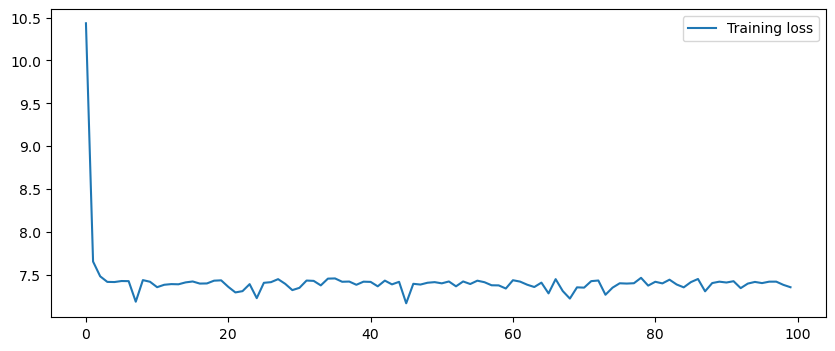

     prediction :  [3.1072027683258057, 3.109339952468872, 3.113858461380005, 3.1089768409729004, 3.1129648685455322, 3.1065356731414795, 3.107506275177002, 3.1129510402679443, 3.11125111579895]
     true       :  tensor([3., 8., 2., 7., 1., 2., 7., 4., 3.])
     RMSLE SCORE :  0.251177922055315


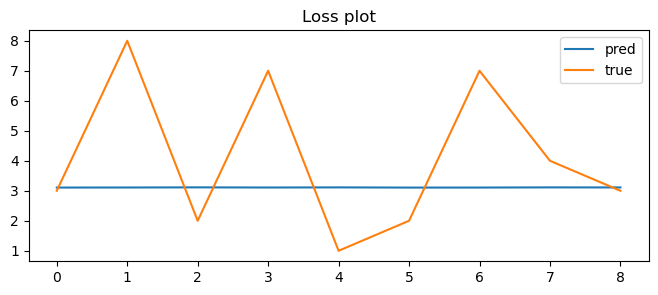

## BABY CARE_1
Epoch: 0000 train loss : 0.0021
Epoch: 0020 train loss : 0.0000
Epoch: 0040 train loss : 0.0000
Epoch: 0060 train loss : 0.0000
Epoch: 0080 train loss : 0.0000


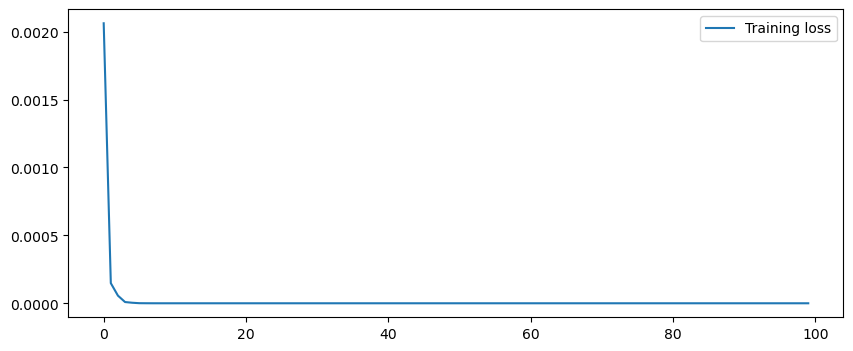

     prediction :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.0


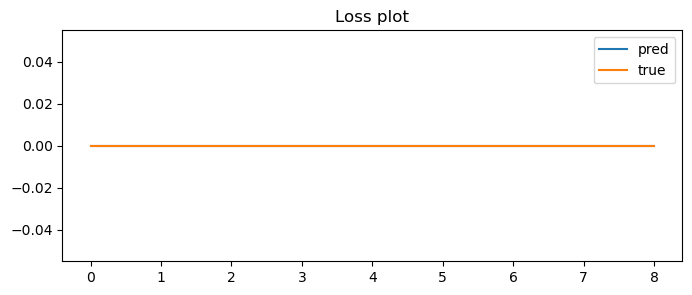

## BEAUTY_1
Epoch: 0000 train loss : 4.7246
Epoch: 0020 train loss : 2.8555
Epoch: 0040 train loss : 2.8675
Epoch: 0060 train loss : 2.8515
Epoch: 0080 train loss : 2.8630


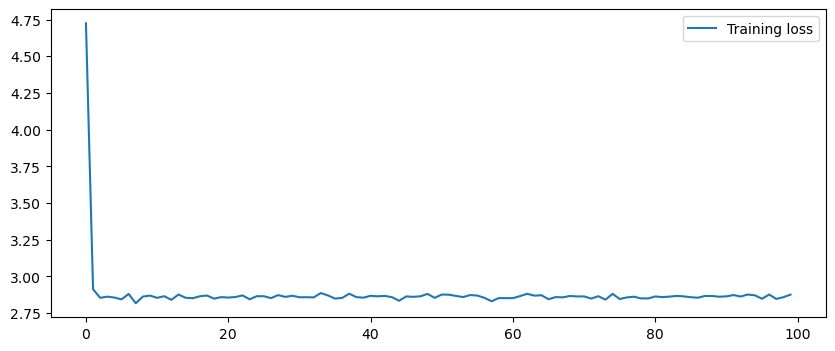

     prediction :  [2.0973622798919678, 2.0994601249694824, 2.099792242050171, 2.099316358566284, 2.097769021987915, 2.0954794883728027, 2.0982120037078857, 2.0987839698791504, 2.0996768474578857]
     true       :  tensor([3., 6., 8., 0., 1., 2., 2., 5., 2.])
     RMSLE SCORE :  0.4195465147386821


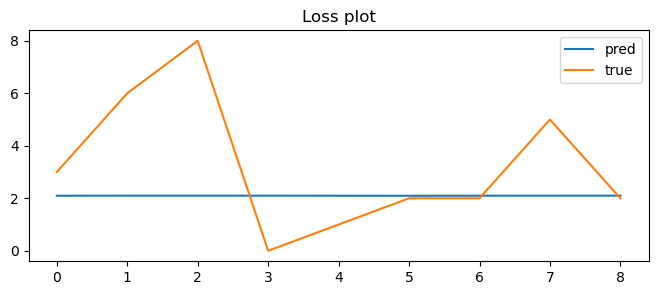

## BEVERAGES_1
Epoch: 0000 train loss : 2493795.5000
Epoch: 0020 train loss : 2295320.0000
Epoch: 0040 train loss : 2057215.3750
Epoch: 0060 train loss : 1877103.1250
Epoch: 0080 train loss : 1714381.1250


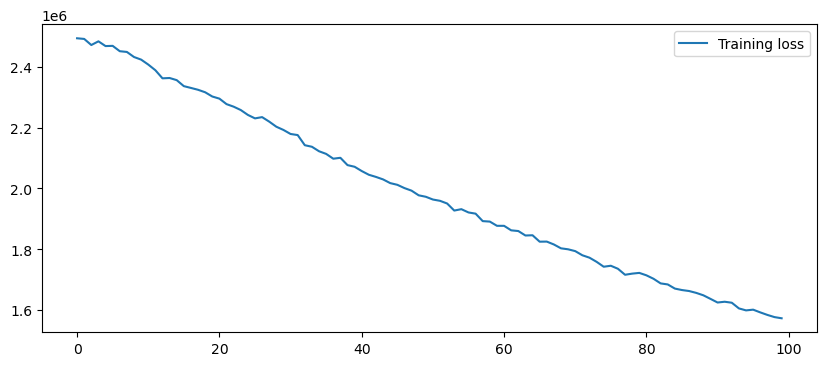

     prediction :  [379.3153991699219, 379.3153991699219, 379.3153991699219, 379.3153991699219, 379.3153991699219, 379.3153991699219, 379.3153991699219, 379.3153991699219, 379.3153991699219]
     true       :  tensor([2123., 2151., 1820., 2030., 2112.,  944., 1925., 1990., 2169.])
     RMSLE SCORE :  2.5995081699088973


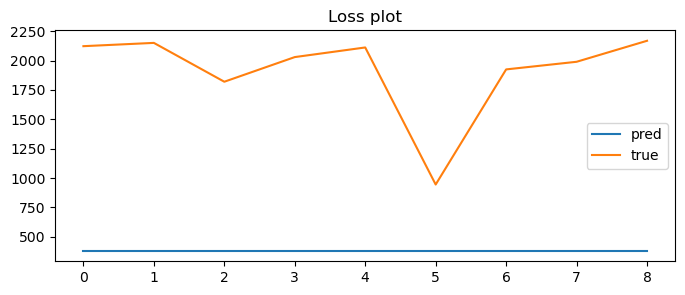

## BOOKS_1
Epoch: 0000 train loss : 0.0050
Epoch: 0020 train loss : 0.0000
Epoch: 0040 train loss : 0.0000
Epoch: 0060 train loss : 0.0000
Epoch: 0080 train loss : 0.0000


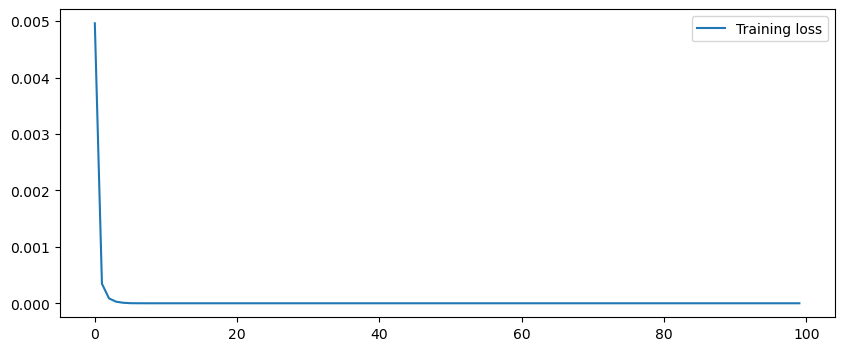

     prediction :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.0


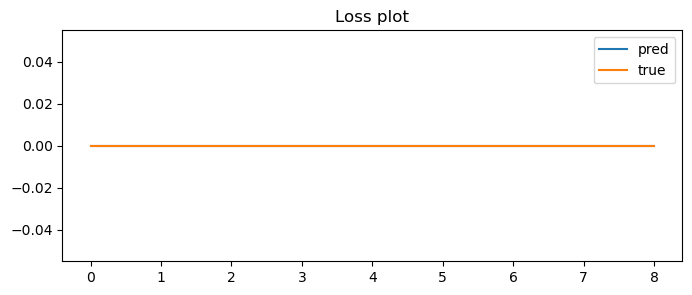

## BREAD/BAKERY_1
Epoch: 0000 train loss : 119785.7734
Epoch: 0020 train loss : 71533.4375
Epoch: 0040 train loss : 41616.1172
Epoch: 0060 train loss : 23487.5781
Epoch: 0080 train loss : 16069.7656


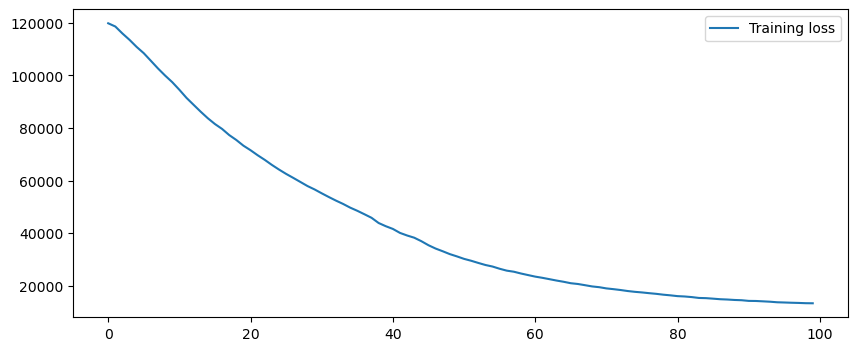

     prediction :  [293.90960693359375, 293.90960693359375, 293.90960693359375, 293.90960693359375, 293.90960693359375, 293.90960693359375, 293.90960693359375, 293.90960693359375, 293.90960693359375]
     true       :  tensor([389.6450, 442.7180, 301.8570, 402.2670, 378.2290, 155.2090, 391.1210,
        381.3920, 443.2730])
     RMSLE SCORE :  0.125353987462384


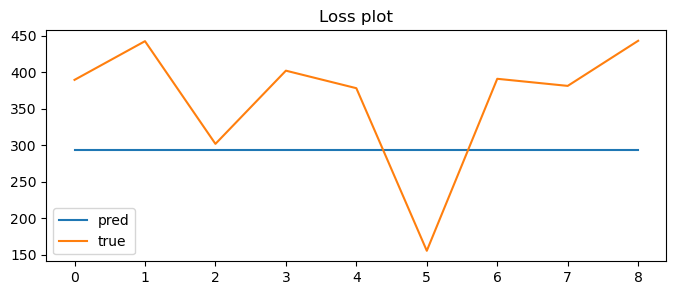

## CELEBRATION_1
Epoch: 0000 train loss : 1452.3115
Epoch: 0020 train loss : 1393.1440
Epoch: 0040 train loss : 1393.2460
Epoch: 0060 train loss : 1392.0746
Epoch: 0080 train loss : 1393.4948


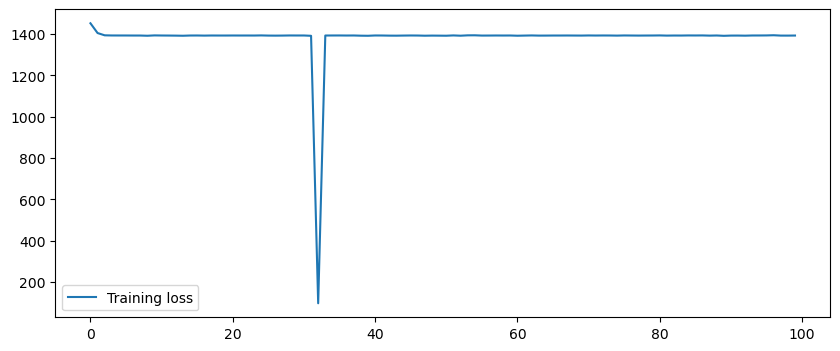

     prediction :  [8.277562141418457, 8.274344444274902, 8.274323463439941, 8.276191711425781, 8.281639099121094, 8.28033447265625, 8.273163795471191, 8.277536392211914, 8.278955459594727]
     true       :  tensor([ 7.,  7.,  9., 30., 19.,  6., 11., 14., 13.])
     RMSLE SCORE :  0.29339298570051386


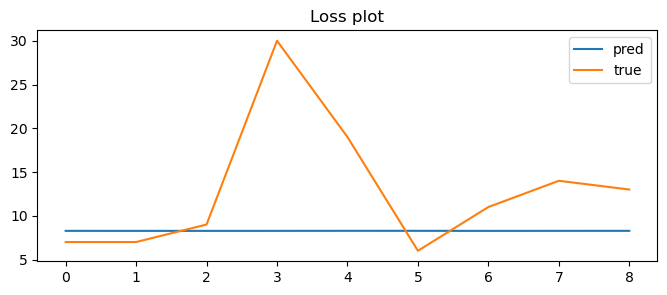

## CLEANING_1
Epoch: 0000 train loss : 449428.3438
Epoch: 0020 train loss : 368865.0938
Epoch: 0040 train loss : 269527.9688
Epoch: 0060 train loss : 198503.4062
Epoch: 0080 train loss : 150875.5000


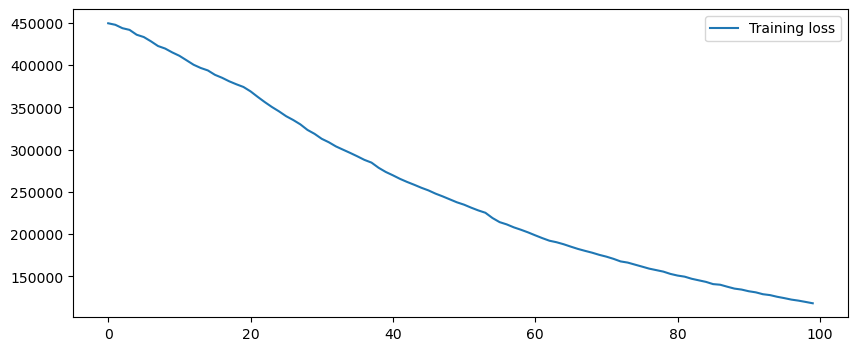

     prediction :  [370.4319152832031, 370.4319152832031, 370.4319152832031, 370.4319152832031, 370.4319152832031, 370.4319152832031, 370.4319152832031, 370.4319152832031, 370.4319152832031]
     true       :  tensor([707., 689., 640., 707., 549., 240., 541., 503., 811.])
     RMSLE SCORE :  0.30027527070175436


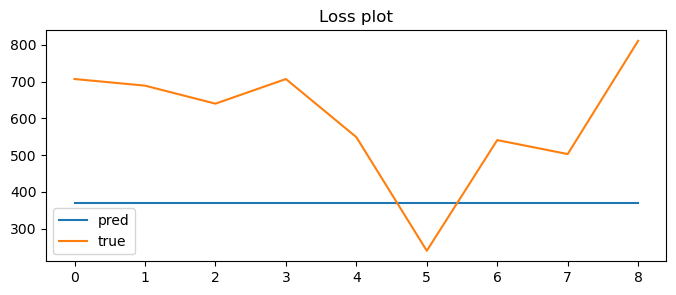

## DAIRY_1
Epoch: 0000 train loss : 399748.2188
Epoch: 0020 train loss : 311500.7812
Epoch: 0040 train loss : 230064.6562
Epoch: 0060 train loss : 173470.1875
Epoch: 0080 train loss : 125251.0781


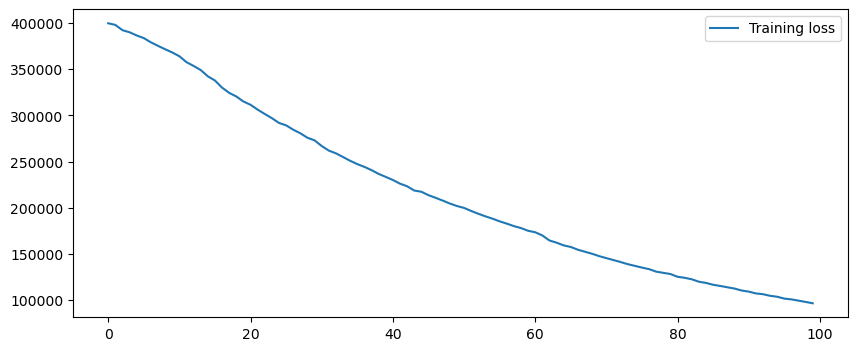

     prediction :  [367.1731872558594, 367.1731872558594, 367.1731872558594, 367.1731872558594, 367.1731872558594, 367.1731872558594, 367.1731872558594, 367.1731872558594, 367.1731872558594]
     true       :  tensor([676., 862., 613., 748., 720., 349., 697., 628., 882.])
     RMSLE SCORE :  0.4197923637231952


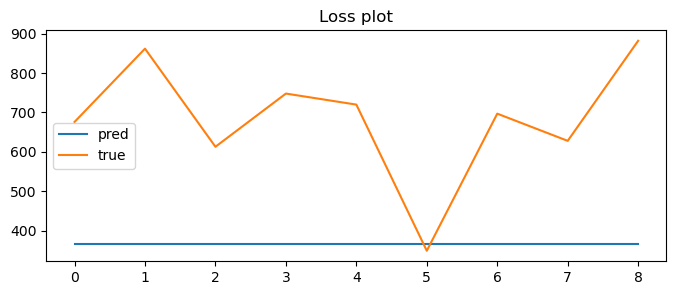

## DELI_1
Epoch: 0000 train loss : 15831.4277
Epoch: 0020 train loss : 3642.6716
Epoch: 0040 train loss : 1766.3815
Epoch: 0060 train loss : 1654.3376
Epoch: 0080 train loss : 1651.3959


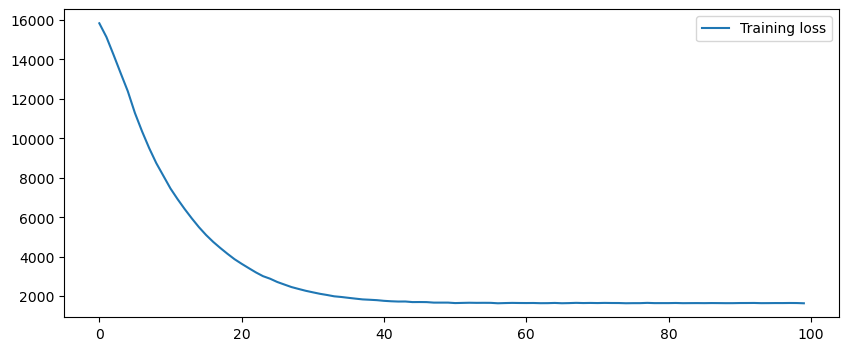

     prediction :  [120.39322662353516, 120.39322662353516, 120.39322662353516, 120.39322662353516, 120.39322662353516, 120.39322662353516, 120.39322662353516, 120.39322662353516, 120.39322662353516]
     true       :  tensor([117.8880, 131.1980, 115.6950, 183.5130, 107.7420,  44.0430, 131.3020,
        131.3770, 140.9790])
     RMSLE SCORE :  0.13544737402945886


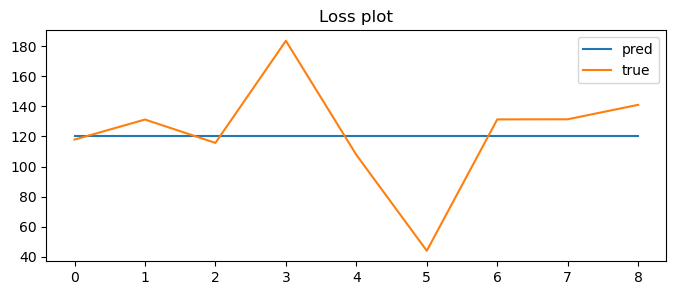

## EGGS_1
Epoch: 0000 train loss : 21146.2500
Epoch: 0020 train loss : 4990.9336
Epoch: 0040 train loss : 1741.4686
Epoch: 0060 train loss : 1425.7518
Epoch: 0080 train loss : 1412.4092


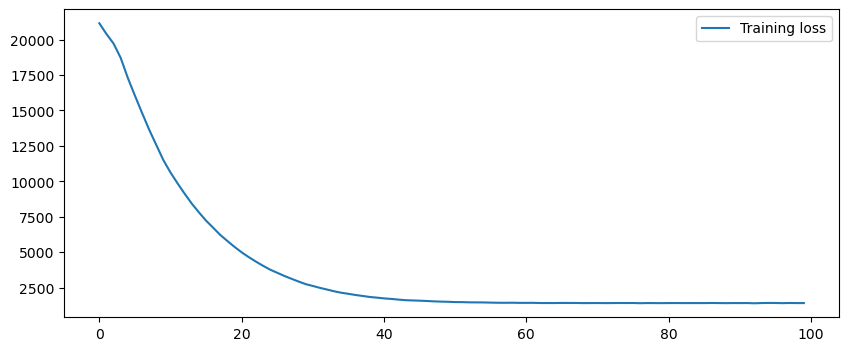

     prediction :  [141.7585906982422, 141.7585906982422, 141.7585906982422, 141.7585906982422, 141.7585906982422, 141.75857543945312, 141.75857543945312, 141.7585906982422, 141.7585906982422]
     true       :  tensor([110., 151.,  98., 144., 148.,  62., 145., 125., 156.])
     RMSLE SCORE :  0.09973353863411077


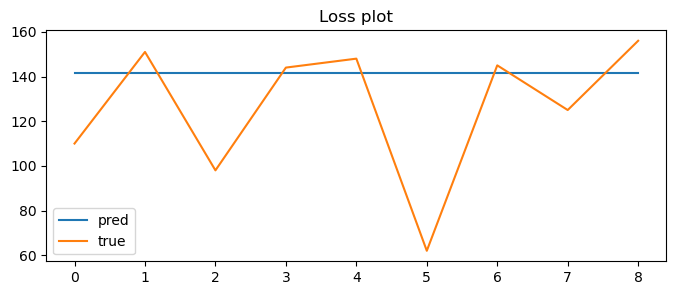

## FROZEN FOODS_1
Epoch: 0000 train loss : 49503.4453
Epoch: 0020 train loss : 35754.6055
Epoch: 0040 train loss : 33396.3086
Epoch: 0060 train loss : 33281.8789
Epoch: 0080 train loss : 33287.0234


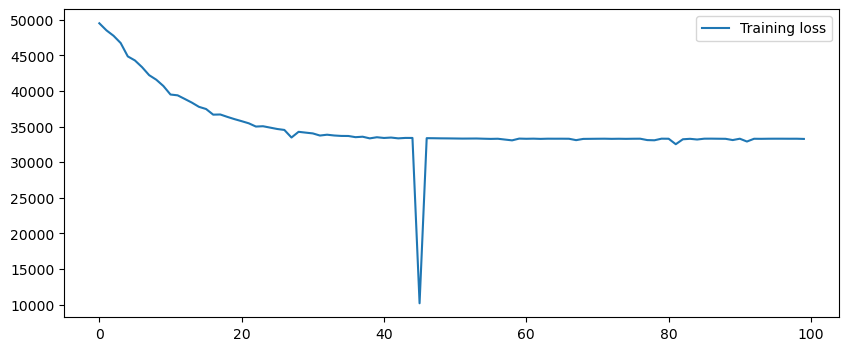

     prediction :  [128.4114532470703, 128.4114532470703, 128.4114532470703, 128.4114532470703, 128.4114532470703, 128.4114532470703, 128.4114532470703, 128.4114532470703, 128.4114532470703]
     true       :  tensor([113.0000, 179.4800, 105.0000, 132.0000, 120.0000,  46.0000,  91.0000,
         74.0000, 132.0000])
     RMSLE SCORE :  0.17915766168594707


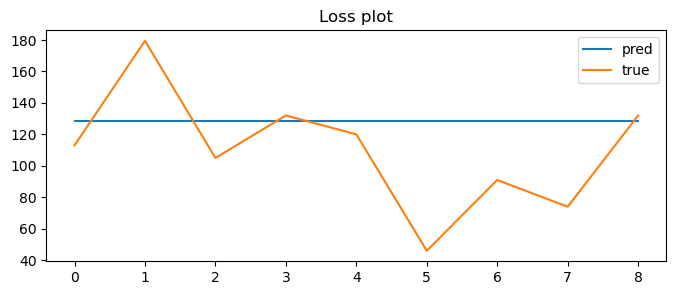

## GROCERY I_1
Epoch: 0000 train loss : 5016945.5000
Epoch: 0020 train loss : 4849770.0000
Epoch: 0040 train loss : 4592226.5000
Epoch: 0060 train loss : 4386242.5000
Epoch: 0080 train loss : 4197455.5000


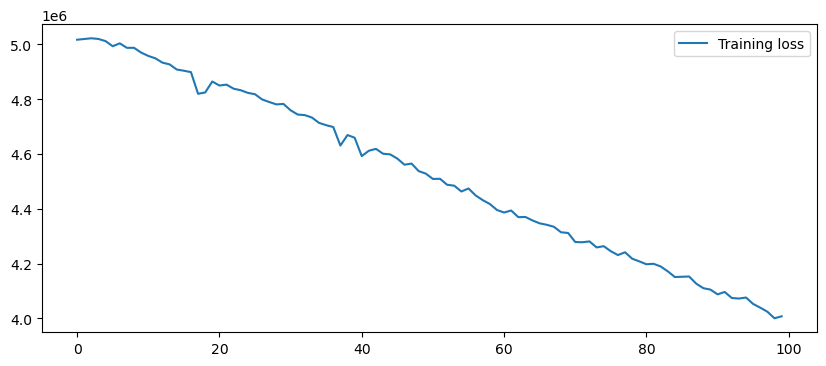

     prediction :  [256.80120849609375, 256.80120849609375, 256.80120849609375, 256.80120849609375, 256.80120849609375, 256.80120849609375, 256.80120849609375, 256.80120849609375, 256.80120849609375]
     true       :  tensor([2545., 2886., 1999., 2419., 2141., 1045., 2280., 2337., 2903.])
     RMSLE SCORE :  4.690654806321152


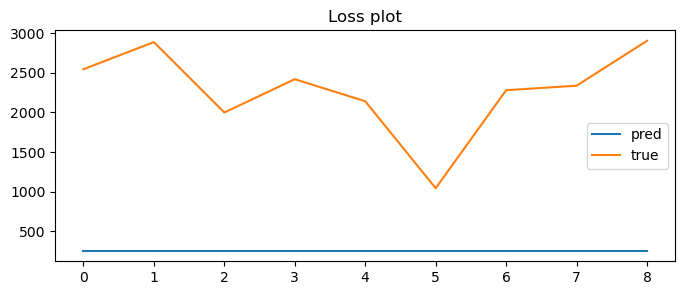

## GROCERY II_1
Epoch: 0000 train loss : 608.3570
Epoch: 0020 train loss : 200.7944
Epoch: 0040 train loss : 196.4926
Epoch: 0060 train loss : 200.9116
Epoch: 0080 train loss : 201.0993


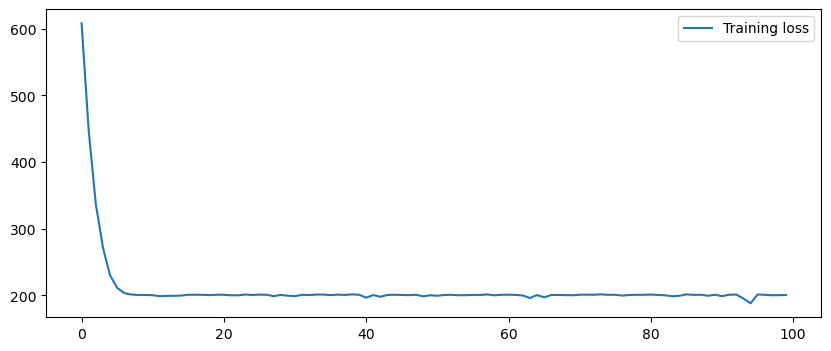

     prediction :  [22.36425018310547, 22.361064910888672, 22.364192962646484, 22.364696502685547, 22.36318588256836, 22.363117218017578, 22.362625122070312, 22.355308532714844, 22.364402770996094]
     true       :  tensor([ 8., 13., 15., 11., 11., 10.,  4., 14., 13.])
     RMSLE SCORE :  0.622895938311679


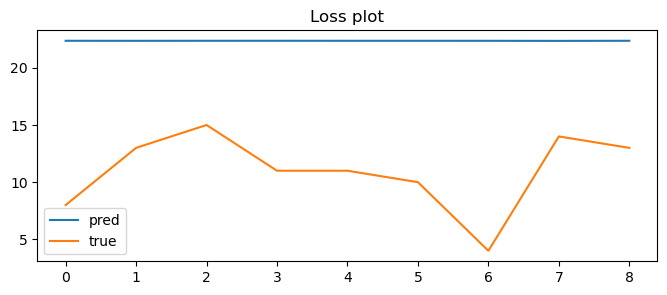

## HARDWARE_1
Epoch: 0000 train loss : 3.7767
Epoch: 0020 train loss : 2.8086
Epoch: 0040 train loss : 2.7982
Epoch: 0060 train loss : 2.7949
Epoch: 0080 train loss : 2.8013


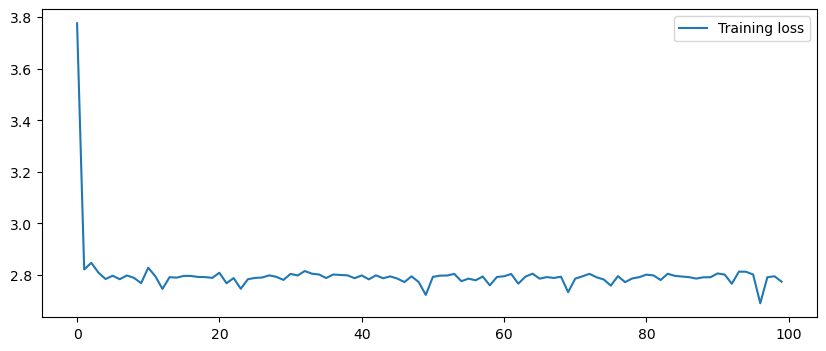

     prediction :  [1.5153895616531372, 1.5146019458770752, 1.513145089149475, 1.5162098407745361, 1.5164612531661987, 1.516183853149414, 1.5146839618682861, 1.5139931440353394, 1.516875147819519]
     true       :  tensor([1., 1., 2., 1., 5., 0., 1., 2., 1.])
     RMSLE SCORE :  0.2146713912193282


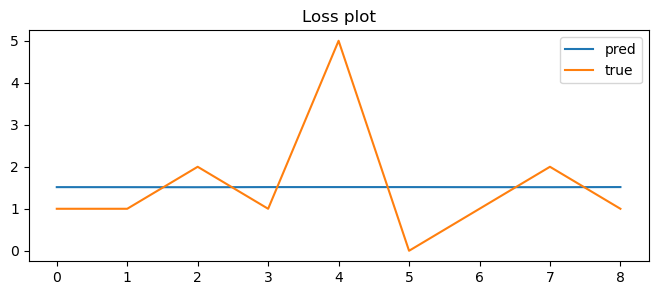

## HOME AND KITCHEN I_1
Epoch: 0000 train loss : 814.4117
Epoch: 0020 train loss : 669.7832
Epoch: 0040 train loss : 675.8154
Epoch: 0060 train loss : 675.7704
Epoch: 0080 train loss : 676.1815


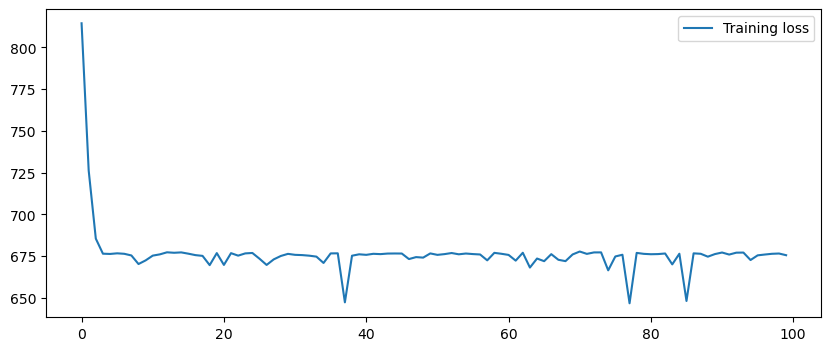

     prediction :  [13.13830280303955, 13.140179634094238, 13.140073776245117, 13.137385368347168, 13.139436721801758, 13.1399564743042, 13.137398719787598, 13.140602111816406, 13.14095401763916]
     true       :  tensor([18., 17.,  7., 13., 16.,  7., 24., 45., 10.])
     RMSLE SCORE :  0.28977139479326314


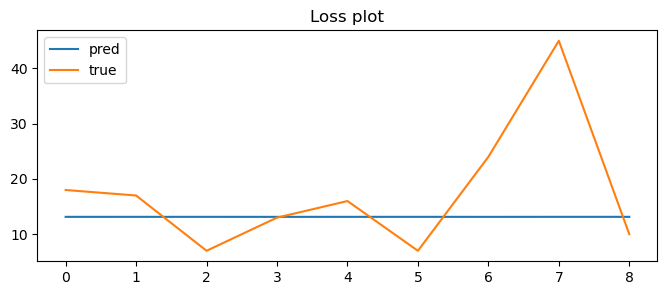

## HOME AND KITCHEN II_1
Epoch: 0000 train loss : 365.4008
Epoch: 0020 train loss : 303.4815
Epoch: 0040 train loss : 303.2353
Epoch: 0060 train loss : 303.2662
Epoch: 0080 train loss : 303.1711


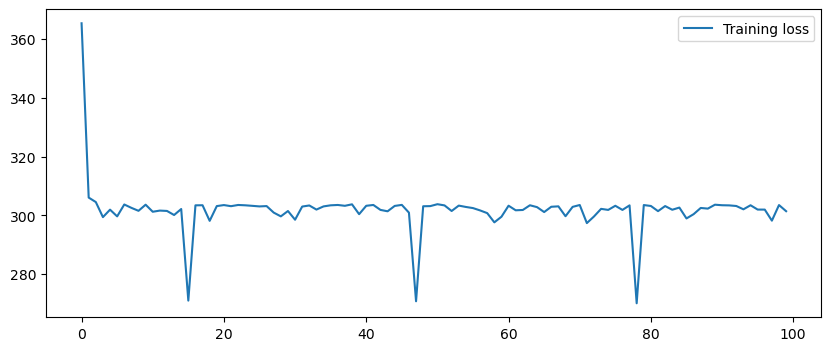

     prediction :  [10.078828811645508, 10.077357292175293, 10.07076644897461, 10.05709457397461, 10.065145492553711, 10.057355880737305, 9.979316711425781, 10.034706115722656, 10.018756866455078]
     true       :  tensor([26., 20., 19., 18., 19.,  2., 15., 13., 20.])
     RMSLE SCORE :  0.5013273599795637


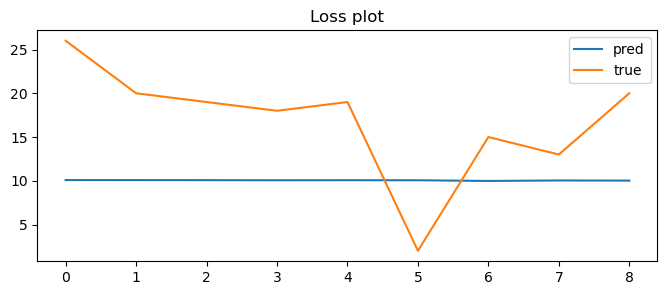

## HOME APPLIANCES_1
Epoch: 0000 train loss : 0.5266
Epoch: 0020 train loss : 0.4782
Epoch: 0040 train loss : 0.4777
Epoch: 0060 train loss : 0.4762
Epoch: 0080 train loss : 0.4760


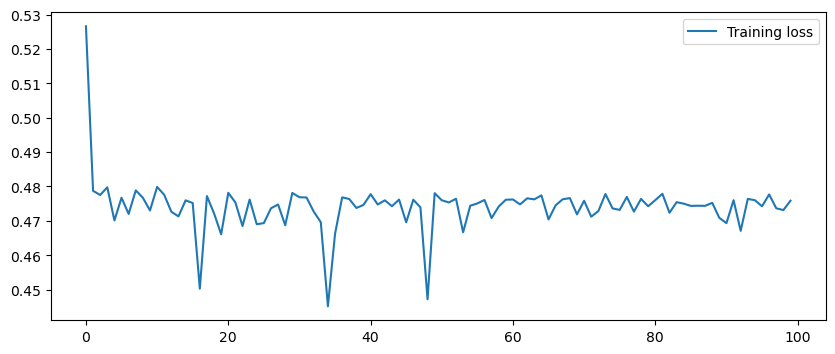

     prediction :  [0.33900150656700134, 0.33900150656700134, 0.33900150656700134, 0.33900150656700134, 0.33900150656700134, 0.33900150656700134, 0.33900150656700134, 0.33900150656700134, 0.33900150656700134]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.08521973378832308


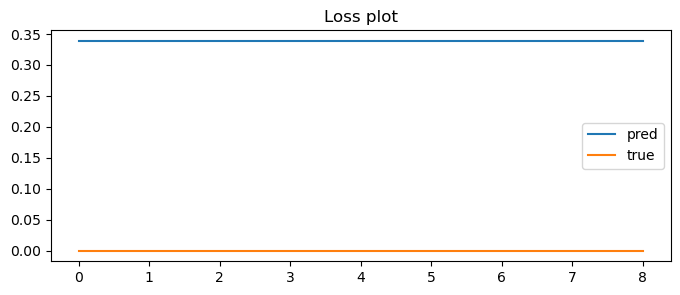

## HOME CARE_1
Epoch: 0000 train loss : 14246.9805
Epoch: 0020 train loss : 7916.3594
Epoch: 0040 train loss : 7743.9600
Epoch: 0060 train loss : 7717.9370
Epoch: 0080 train loss : 7732.6484


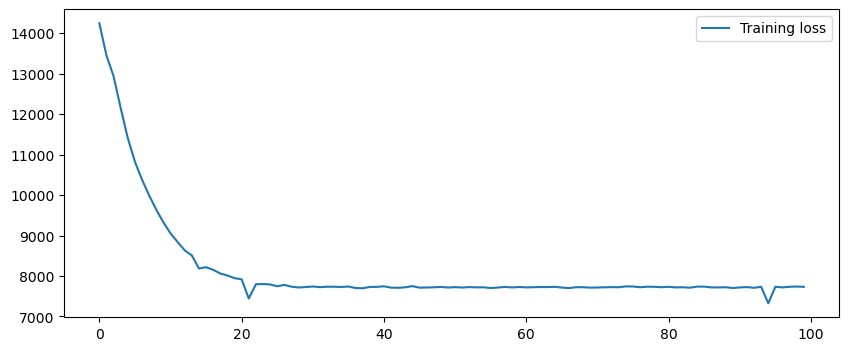

     prediction :  [82.07015228271484, 82.07015228271484, 82.07015228271484, 82.07015228271484, 82.07015228271484, 82.07015228271484, 82.07015228271484, 82.07015228271484, 82.07015228271484]
     true       :  tensor([176., 199., 146., 153., 155.,  71., 163., 169., 174.])
     RMSLE SCORE :  0.4443568621731198


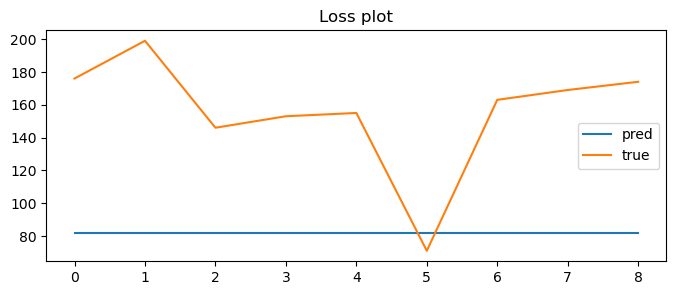

## LADIESWEAR_1
Epoch: 0000 train loss : 140.2124
Epoch: 0020 train loss : 100.2123
Epoch: 0040 train loss : 100.2060
Epoch: 0060 train loss : 100.4767
Epoch: 0080 train loss : 99.5238


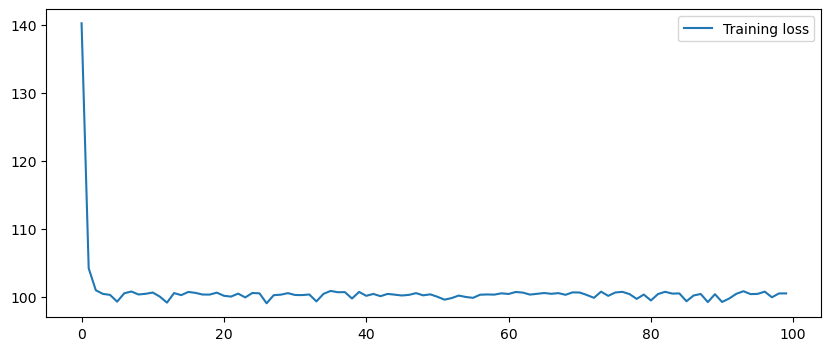

     prediction :  [8.323726654052734, 8.321621894836426, 8.325806617736816, 8.322877883911133, 8.3198881149292, 8.324658393859863, 8.313658714294434, 8.325811386108398, 8.324689865112305]
     true       :  tensor([11., 26., 13.,  9., 18.,  5., 26., 18.,  2.])
     RMSLE SCORE :  0.5546457468136482


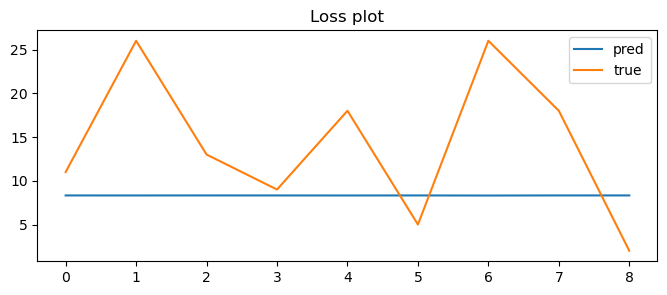

## LAWN AND GARDEN_1
Epoch: 0000 train loss : 51.5100
Epoch: 0020 train loss : 25.3548
Epoch: 0040 train loss : 25.4238
Epoch: 0060 train loss : 25.1704
Epoch: 0080 train loss : 25.0785


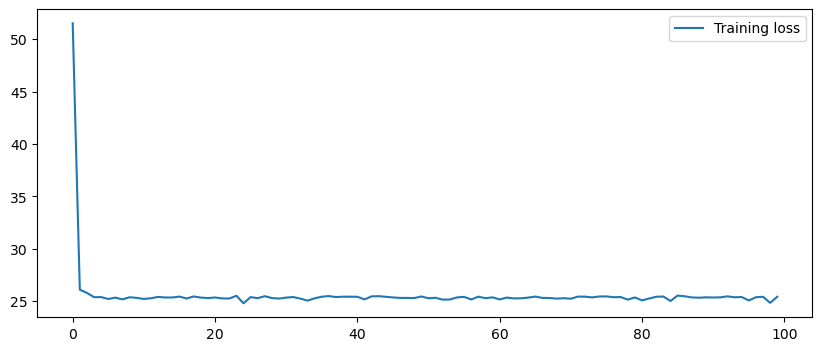

     prediction :  [7.425351619720459, 7.423740386962891, 7.433096408843994, 7.430624485015869, 7.426619052886963, 7.427748203277588, 7.428665637969971, 7.4217376708984375, 7.428685188293457]
     true       :  tensor([ 4., 13., 11.,  6.,  7.,  8.,  3.,  8., 19.])
     RMSLE SCORE :  0.2225529148209881


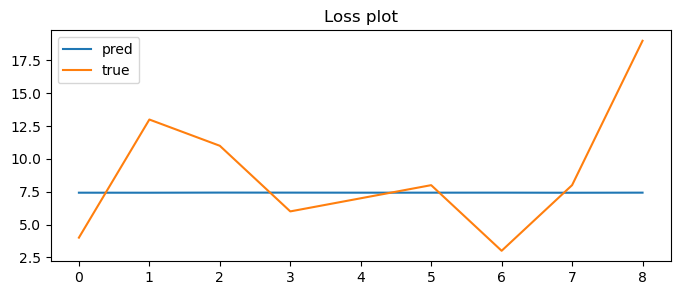

## LINGERIE_1
Epoch: 0000 train loss : 56.2728
Epoch: 0020 train loss : 33.9253
Epoch: 0040 train loss : 33.5192
Epoch: 0060 train loss : 33.8812
Epoch: 0080 train loss : 33.9248


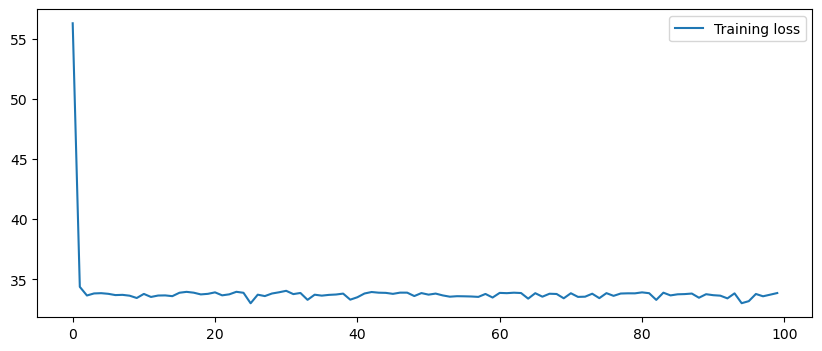

     prediction :  [6.857102394104004, 6.866223335266113, 6.8640007972717285, 6.857174396514893, 6.863860607147217, 6.857339382171631, 6.860754013061523, 6.8573479652404785, 6.860864162445068]
     true       :  tensor([3., 2., 0., 2., 0., 1., 0., 1., 5.])
     RMSLE SCORE :  2.0985463210860043


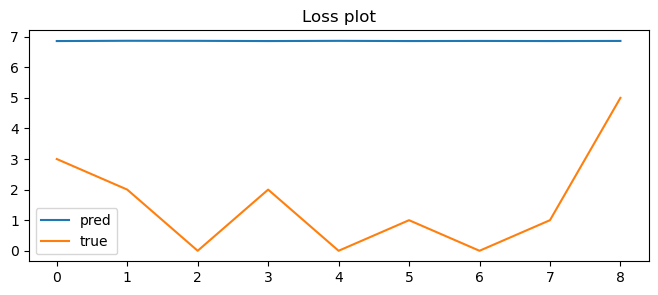

## LIQUOR,WINE,BEER_1
Epoch: 0000 train loss : 14629.5234
Epoch: 0020 train loss : 5351.8096
Epoch: 0040 train loss : 4647.0825
Epoch: 0060 train loss : 4666.9746
Epoch: 0080 train loss : 4667.3242


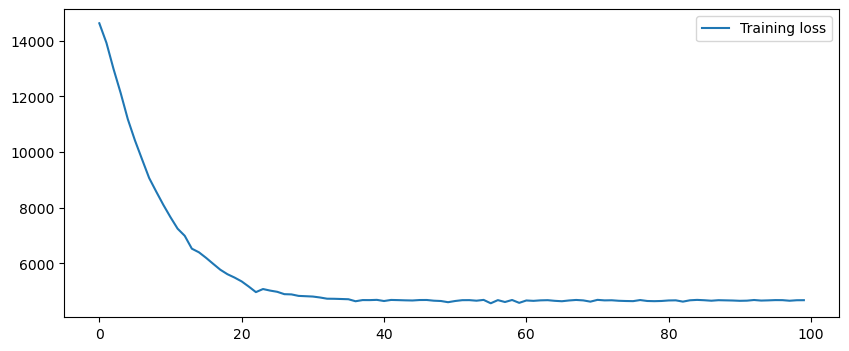

     prediction :  [100.60975646972656, 100.60975646972656, 100.60975646972656, 100.60975646972656, 100.60975646972656, 100.60974884033203, 100.60975646972656, 100.60975646972656, 100.60975646972656]
     true       :  tensor([128., 125., 109., 196., 146.,  51.,  61.,  94., 111.])
     RMSLE SCORE :  0.15456186096740387


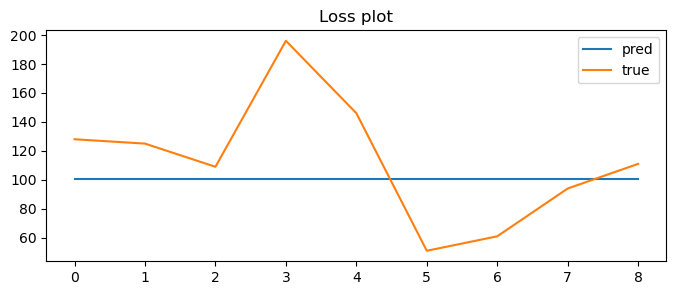

## MAGAZINES_1
Epoch: 0000 train loss : 14.6593
Epoch: 0020 train loss : 12.5705
Epoch: 0040 train loss : 12.7789
Epoch: 0060 train loss : 12.6783
Epoch: 0080 train loss : 12.8450


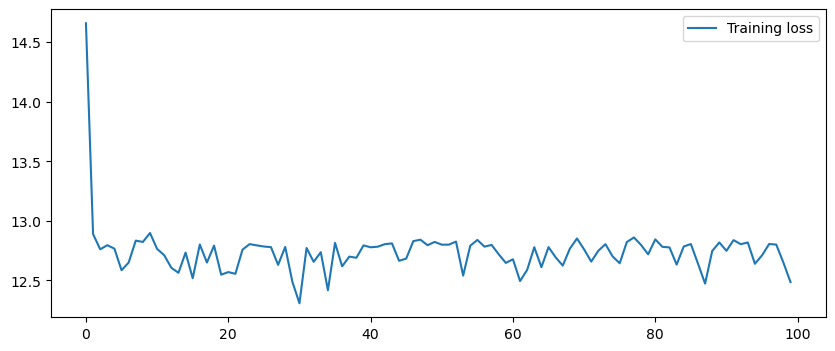

     prediction :  [2.156121253967285, 2.1991493701934814, 2.1830894947052, 2.133432626724243, 2.1720452308654785, 2.182955503463745, 2.135254383087158, 2.1718878746032715, 2.1624085903167725]
     true       :  tensor([14.,  6.,  1.,  6.,  7.,  1.,  6.,  4.,  6.])
     RMSLE SCORE :  0.7177747662986433


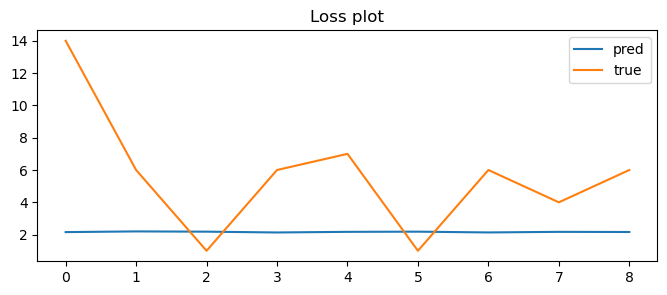

## MEATS_1
Epoch: 0000 train loss : 124233.0391
Epoch: 0020 train loss : 75493.8906
Epoch: 0040 train loss : 49507.6250
Epoch: 0060 train loss : 35929.1250
Epoch: 0080 train loss : 29493.6914


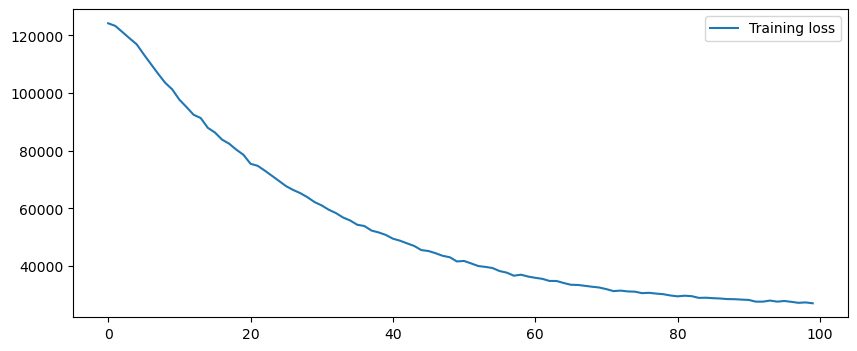

     prediction :  [282.90460205078125, 282.90460205078125, 282.90460205078125, 282.90460205078125, 282.90460205078125, 282.90460205078125, 282.90460205078125, 282.90460205078125, 282.90460205078125]
     true       :  tensor([235.4550, 293.7210, 243.3350, 616.6010, 358.4280,  96.2040, 248.4060,
        221.7460, 241.0940])
     RMSLE SCORE :  0.21854353048441866


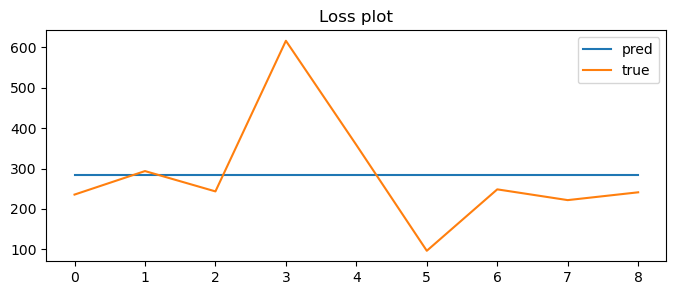

## PERSONAL CARE_1
Epoch: 0000 train loss : 17640.5957
Epoch: 0020 train loss : 4514.2700
Epoch: 0040 train loss : 2552.5874
Epoch: 0060 train loss : 2423.7842
Epoch: 0080 train loss : 2427.9458


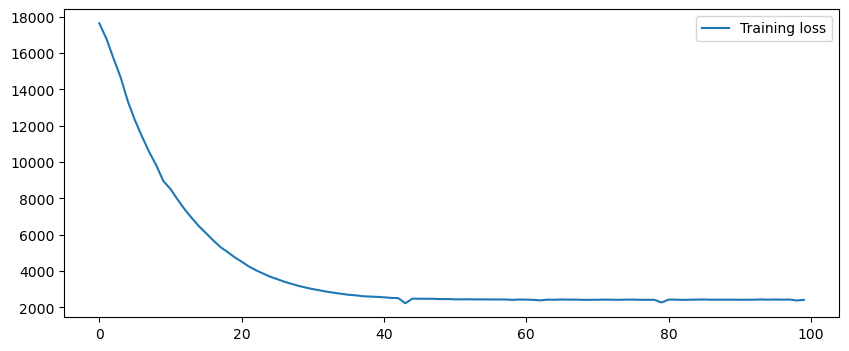

     prediction :  [124.33491516113281, 124.33491516113281, 124.33491516113281, 124.33491516113281, 124.33491516113281, 124.33491516113281, 124.33491516113281, 124.33491516113281, 124.33491516113281]
     true       :  tensor([174., 147., 139., 135., 159.,  71., 152., 152., 176.])
     RMSLE SCORE :  0.08039542036802014


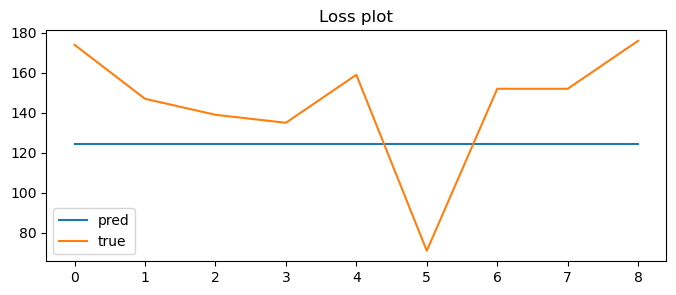

## PET SUPPLIES_1
Epoch: 0000 train loss : 16.6707
Epoch: 0020 train loss : 13.6407
Epoch: 0040 train loss : 13.7370
Epoch: 0060 train loss : 13.7517
Epoch: 0080 train loss : 13.7842


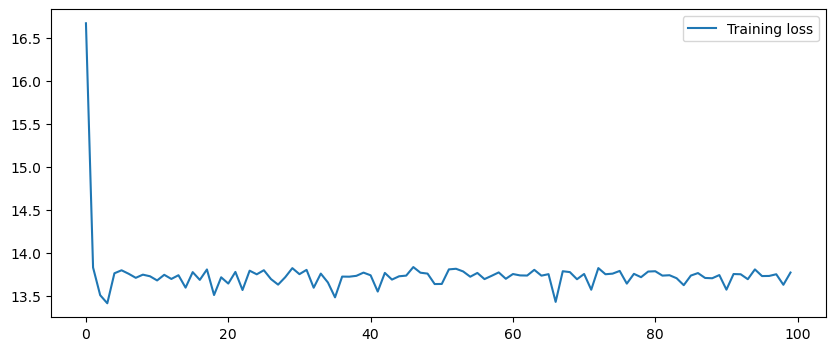

     prediction :  [2.9571373462677, 2.946214199066162, 2.9635884761810303, 2.951418161392212, 2.9459989070892334, 2.9619195461273193, 2.940053701400757, 2.954585552215576, 2.919816732406616]
     true       :  tensor([3., 9., 4., 3., 8., 2., 5., 0., 8.])
     RMSLE SCORE :  0.4926675951462336


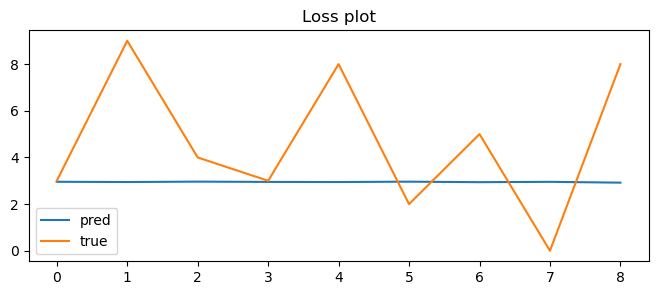

## PLAYERS AND ELECTRONICS_1
Epoch: 0000 train loss : 43.4584
Epoch: 0020 train loss : 34.5500
Epoch: 0040 train loss : 34.6410
Epoch: 0060 train loss : 34.5918
Epoch: 0080 train loss : 34.6352


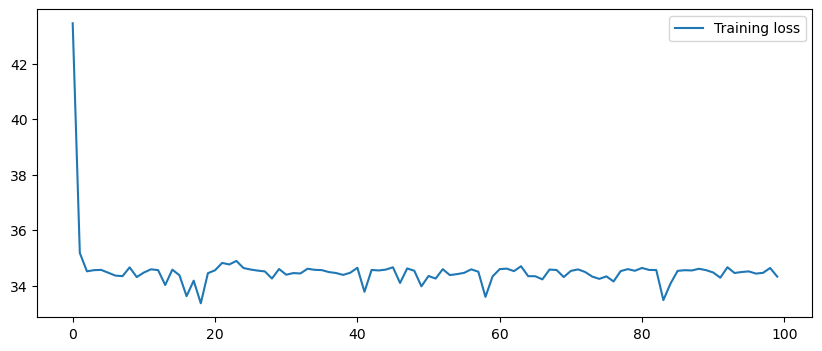

     prediction :  [4.178090572357178, 4.180749893188477, 4.180809497833252, 4.15431547164917, 4.175910949707031, 4.1688127517700195, 4.168430328369141, 4.187361717224121, 4.155627727508545]
     true       :  tensor([13., 13.,  4., 11.,  8.,  8., 17.,  4.,  9.])
     RMSLE SCORE :  0.5893108480486056


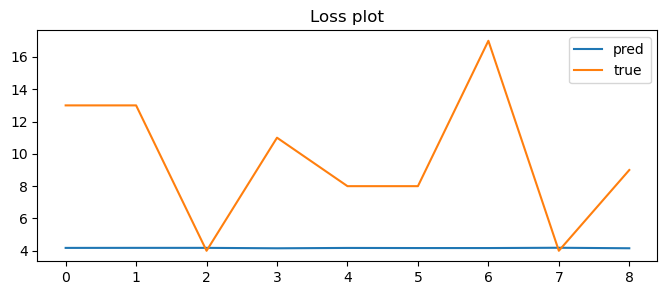

## POULTRY_1
Epoch: 0000 train loss : 94959.9219
Epoch: 0020 train loss : 54969.3477
Epoch: 0040 train loss : 33768.1953
Epoch: 0060 train loss : 23840.2871
Epoch: 0080 train loss : 19662.1172


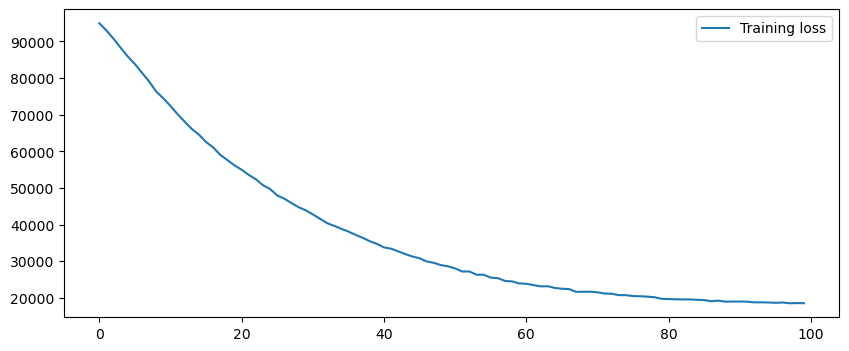

     prediction :  [256.5334167480469, 256.5334167480469, 256.5334167480469, 256.5334167480469, 256.5334167480469, 256.5334167480469, 256.5334167480469, 256.5334167480469, 256.5334167480469]
     true       :  tensor([196.6420, 297.3860, 227.9150, 394.4210, 263.0730, 146.2700, 324.1710,
        271.4250, 310.2440])
     RMSLE SCORE :  0.07732133463970328


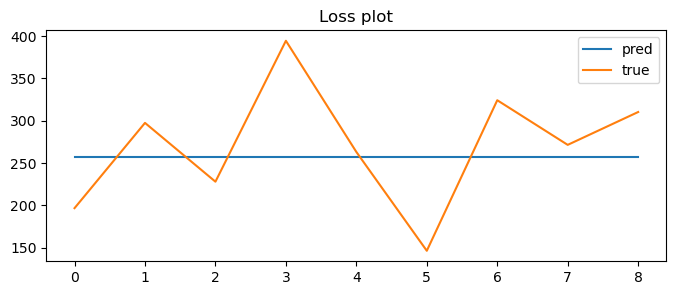

## PREPARED FOODS_1
Epoch: 0000 train loss : 7174.4199
Epoch: 0020 train loss : 1033.5419
Epoch: 0040 train loss : 842.1019
Epoch: 0060 train loss : 839.0865
Epoch: 0080 train loss : 841.8592


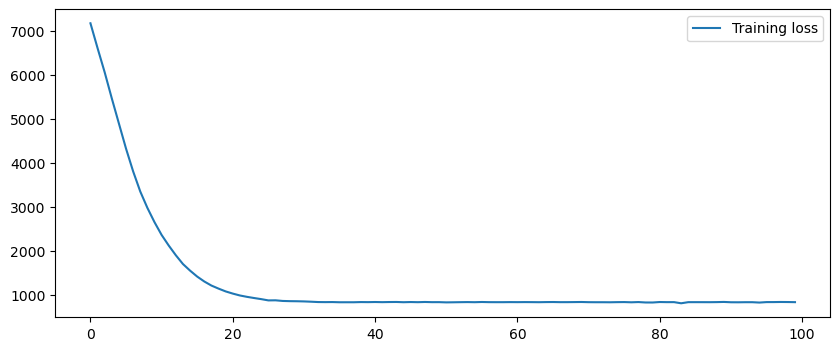

     prediction :  [80.71192932128906, 80.71192932128906, 80.71192932128906, 80.71192932128906, 80.71192932128906, 80.71192932128906, 80.71190643310547, 80.71192932128906, 80.7119369506836]
     true       :  tensor([ 79.4020, 115.5230,  75.8520,  89.5240,  98.1810,  32.1530,  81.8490,
         65.0190,  73.1410])
     RMSLE SCORE :  0.1163157571336762


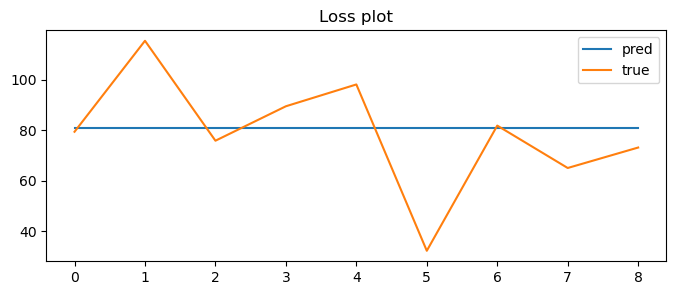

## PRODUCE_1
Epoch: 0000 train loss : 3112506.5000
Epoch: 0020 train loss : 2906914.2500
Epoch: 0040 train loss : 2730928.2500
Epoch: 0060 train loss : 2591630.7500
Epoch: 0080 train loss : 2454689.7500


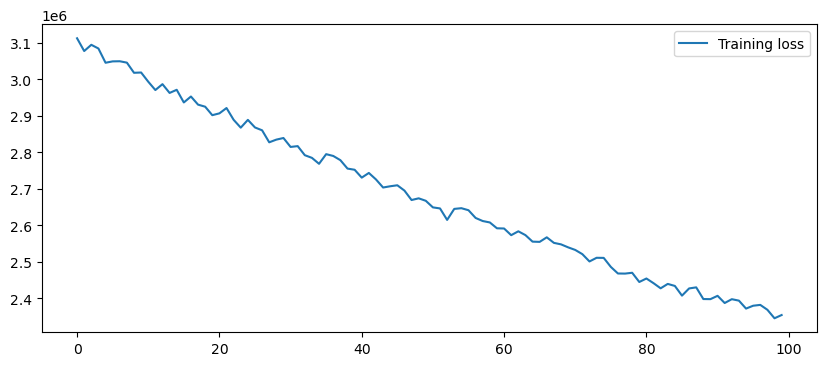

     prediction :  [390.711181640625, 390.711181640625, 390.711181640625, 390.711181640625, 390.711181640625, 390.711181640625, 390.711181640625, 390.711181640625, 390.711181640625]
     true       :  tensor([2081.9509, 3988.2151, 1942.7371, 2294.2000, 2136.9189, 1174.6890,
        2326.5410, 2020.0530, 3889.8870])
     RMSLE SCORE :  3.2330567010943168


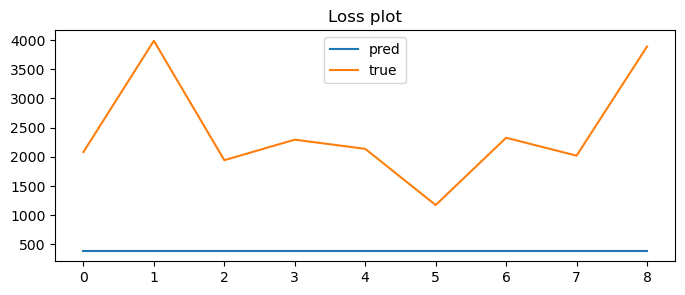

## SCHOOL AND OFFICE SUPPLIES_1
Epoch: 0000 train loss : 0.1934
Epoch: 0020 train loss : 0.1913
Epoch: 0040 train loss : 0.1915
Epoch: 0060 train loss : 0.1910
Epoch: 0080 train loss : 0.1915


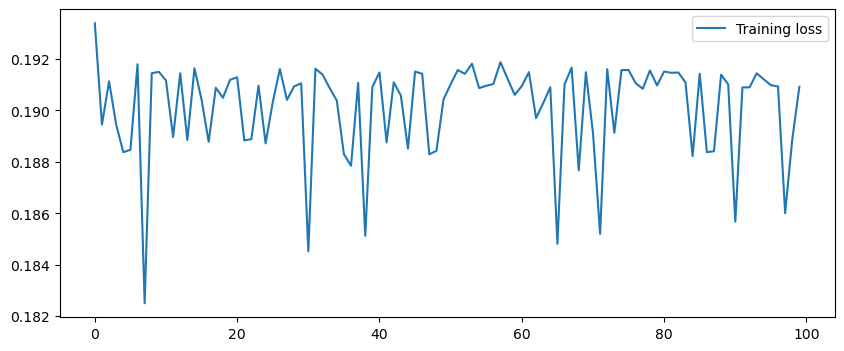

     prediction :  [0.1282850056886673, 0.1282850056886673, 0.12987932562828064, 0.1292671412229538, 0.12928909063339233, 0.1287345141172409, 0.13024446368217468, 0.12967419624328613, 0.1288982778787613]
     true       :  tensor([0., 3., 0., 1., 0., 5., 0., 0., 1.])
     RMSLE SCORE :  0.568971317187169


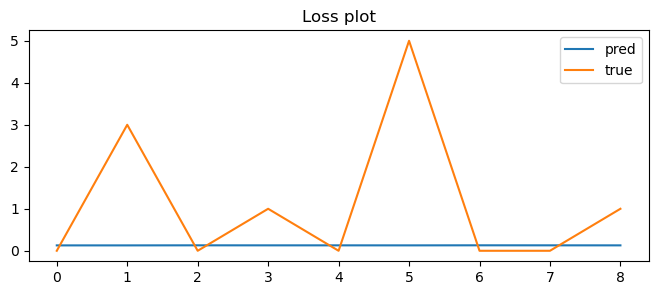

## SEAFOOD_1
Epoch: 0000 train loss : 683.2517
Epoch: 0020 train loss : 114.8502
Epoch: 0040 train loss : 114.6227
Epoch: 0060 train loss : 114.6750
Epoch: 0080 train loss : 113.3552


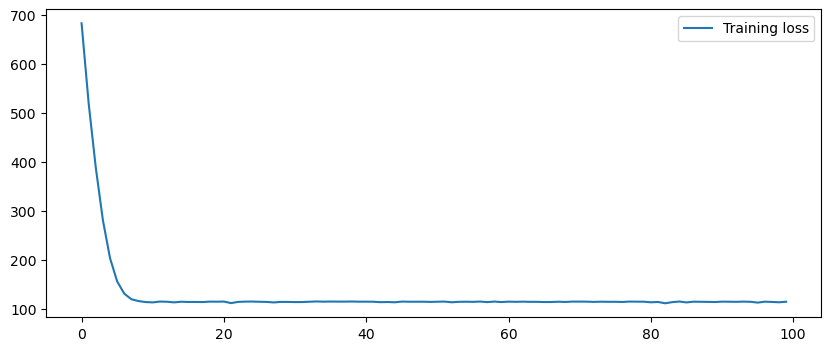

     prediction :  [25.815824508666992, 25.8157958984375, 25.815898895263672, 25.815608978271484, 25.815906524658203, 25.815868377685547, 25.81276512145996, 25.815860748291016, 25.815765380859375]
     true       :  tensor([26.5770, 35.5390, 20.1600, 42.5690, 32.9290,  8.8550, 31.4230, 24.3010,
        28.4050])
     RMSLE SCORE :  0.16595036092331975


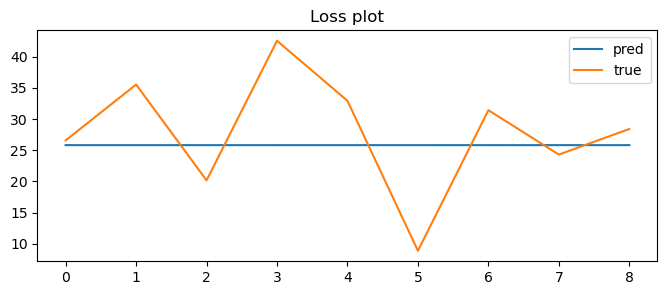

## AUTOMOTIVE_10
Epoch: 0000 train loss : 10.2813
Epoch: 0020 train loss : 7.0504
Epoch: 0040 train loss : 7.0330
Epoch: 0060 train loss : 7.0781
Epoch: 0080 train loss : 7.0079


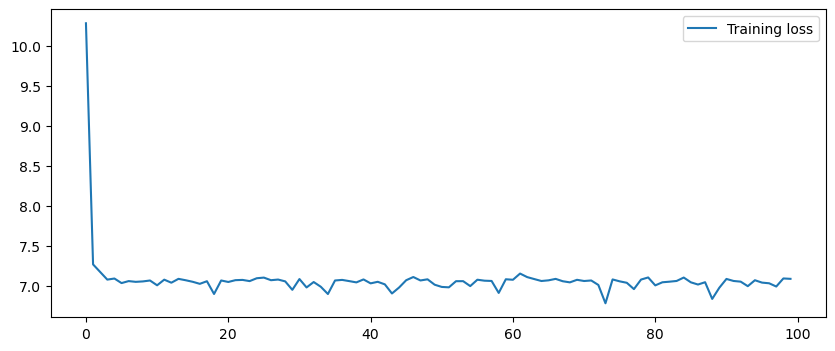

     prediction :  [3.190584182739258, 3.174048662185669, 3.1728978157043457, 3.1725902557373047, 3.2017574310302734, 3.179935932159424, 3.1949703693389893, 3.1783981323242188, 3.1863512992858887]
     true       :  tensor([ 0.,  0.,  0., 12.,  1.,  6.,  1.,  3.,  1.])
     RMSLE SCORE :  1.0378120792203804


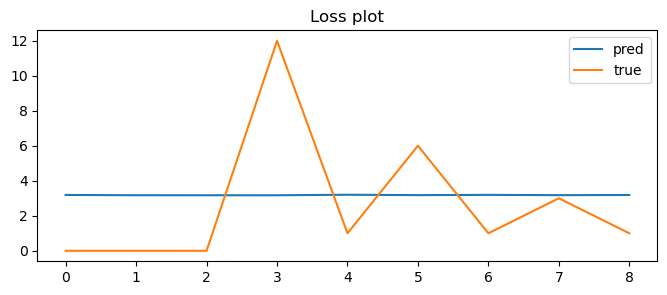

## BABY CARE_10
Epoch: 0000 train loss : 1.5917
Epoch: 0020 train loss : 1.5676
Epoch: 0040 train loss : 1.5074
Epoch: 0060 train loss : 1.5508
Epoch: 0080 train loss : 1.5313


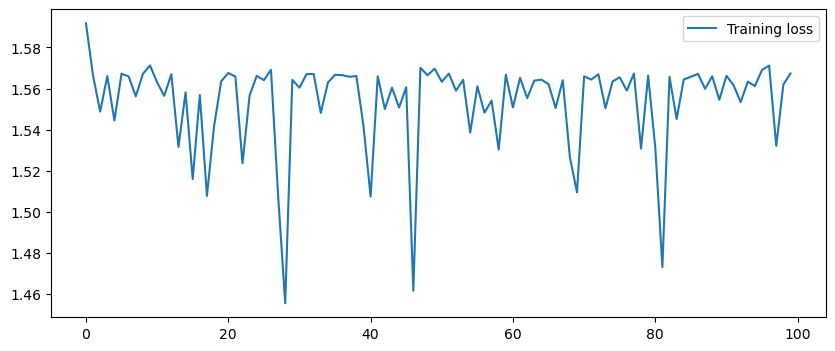

     prediction :  [0.2868809401988983, 0.2868722975254059, 0.2868722975254059, 0.2868722975254059, 0.29907166957855225, 0.28828850388526917, 0.2873745262622833, 0.28695207834243774, 0.28689515590667725]
     true       :  tensor([0., 0., 0., 1., 0., 0., 0., 0., 1.])
     RMSLE SCORE :  0.09330545762374204


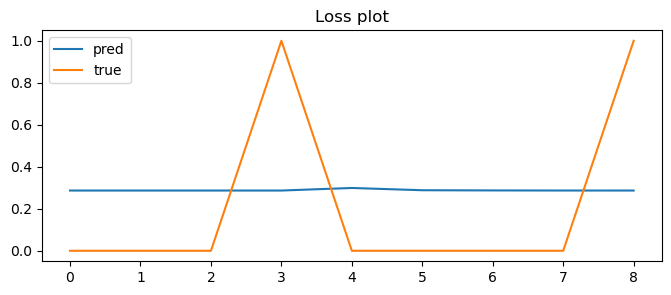

## BEAUTY_10
Epoch: 0000 train loss : 2.3755
Epoch: 0020 train loss : 1.8192
Epoch: 0040 train loss : 1.8258
Epoch: 0060 train loss : 1.8290
Epoch: 0080 train loss : 1.8236


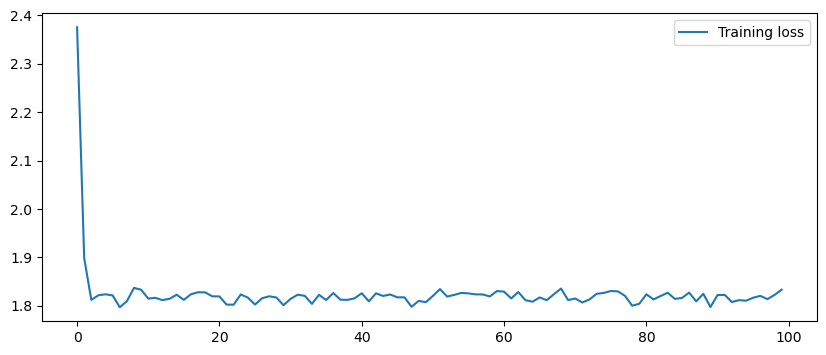

     prediction :  [1.3630071878433228, 1.3491711616516113, 1.3580234050750732, 1.3619564771652222, 1.3650990724563599, 1.3552628755569458, 1.3529739379882812, 1.3516454696655273, 1.3658583164215088]
     true       :  tensor([1., 0., 2., 2., 2., 1., 1., 2., 0.])
     RMSLE SCORE :  0.1981055608862698


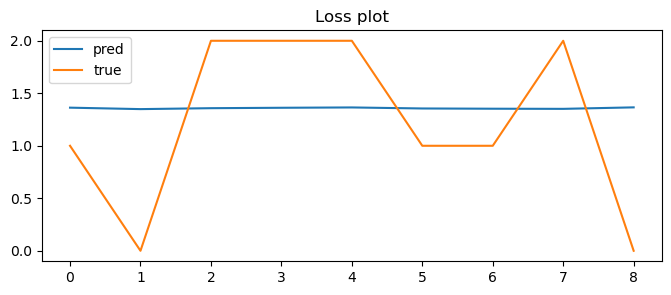

## BEVERAGES_10
Epoch: 0000 train loss : 810748.1875
Epoch: 0020 train loss : 708075.5625
Epoch: 0040 train loss : 610224.3125
Epoch: 0060 train loss : 518650.9375
Epoch: 0080 train loss : 433720.1562


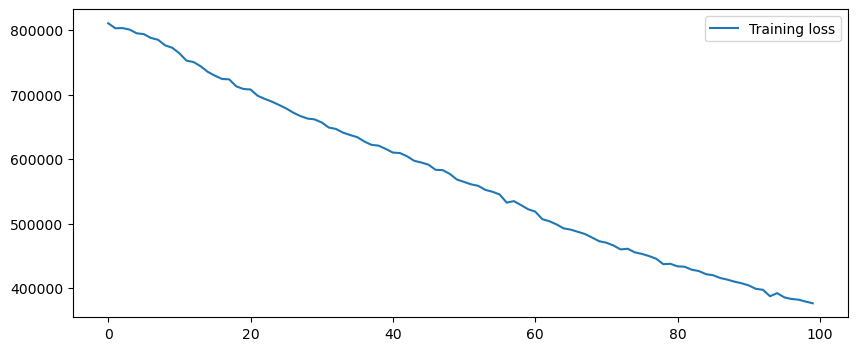

     prediction :  [338.86541748046875, 338.86541748046875, 338.86541748046875, 338.86541748046875, 338.86541748046875, 338.86541748046875, 338.86541748046875, 338.86541748046875, 338.86541748046875]
     true       :  tensor([1049.,  862.,  883.,  949., 1253., 1198.,  918.,  972.,  979.])
     RMSLE SCORE :  1.1802494441455444


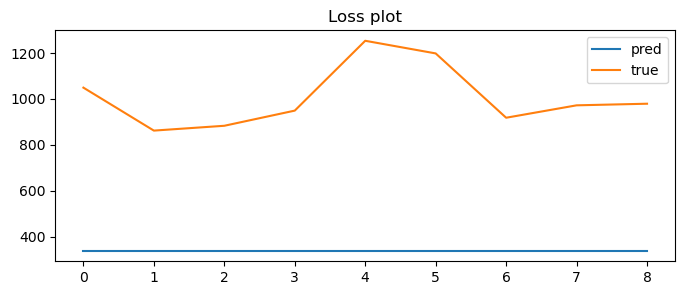

## BOOKS_10
Epoch: 0000 train loss : 0.0012
Epoch: 0020 train loss : 0.0000
Epoch: 0040 train loss : 0.0000
Epoch: 0060 train loss : 0.0000
Epoch: 0080 train loss : 0.0000


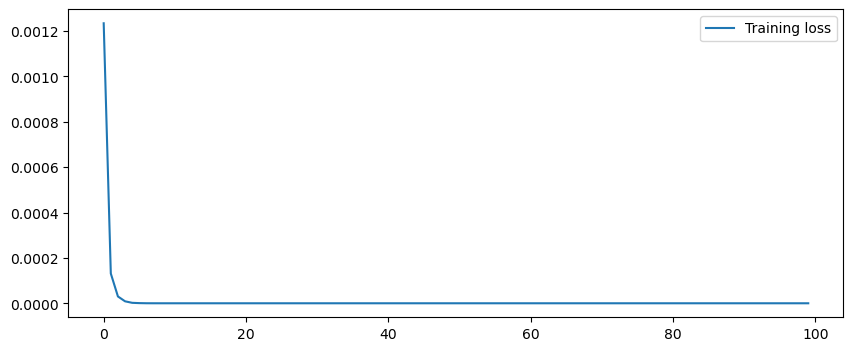

     prediction :  [3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  1.3877787756115668e-17


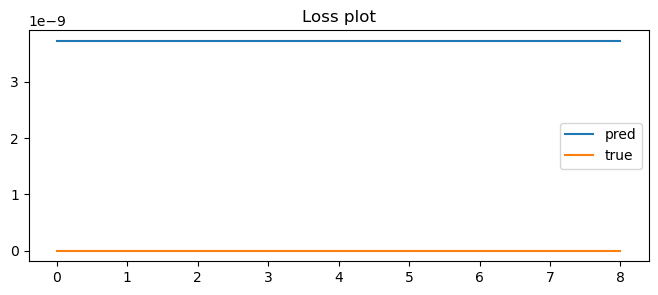

## BREAD/BAKERY_10
Epoch: 0000 train loss : 14678.5771
Epoch: 0020 train loss : 2892.2268
Epoch: 0040 train loss : 1518.1265
Epoch: 0060 train loss : 1468.1863
Epoch: 0080 train loss : 1452.5569


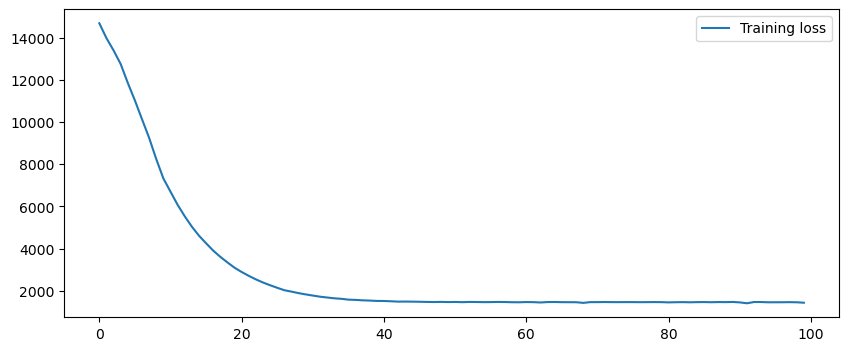

     prediction :  [115.82382202148438, 115.82381439208984, 115.82382202148438, 115.82382202148438, 115.82382202148438, 115.82381439208984, 115.82382202148438, 115.82382202148438, 115.82382202148438]
     true       :  tensor([ 87.,  90.,  92.,  90., 110.,  78., 110., 117.,  77.])
     RMSLE SCORE :  0.06429590541968981


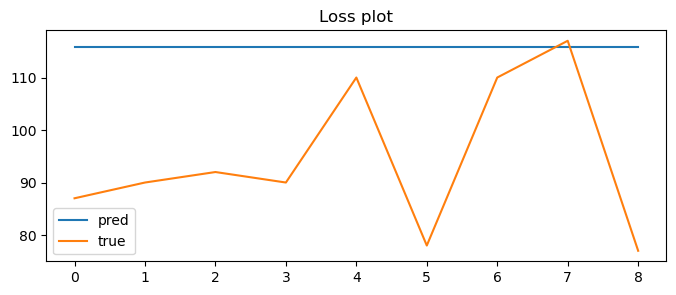

## CELEBRATION_10
Epoch: 0000 train loss : 16.9266
Epoch: 0020 train loss : 14.8176
Epoch: 0040 train loss : 14.9119
Epoch: 0060 train loss : 14.8070
Epoch: 0080 train loss : 14.8930


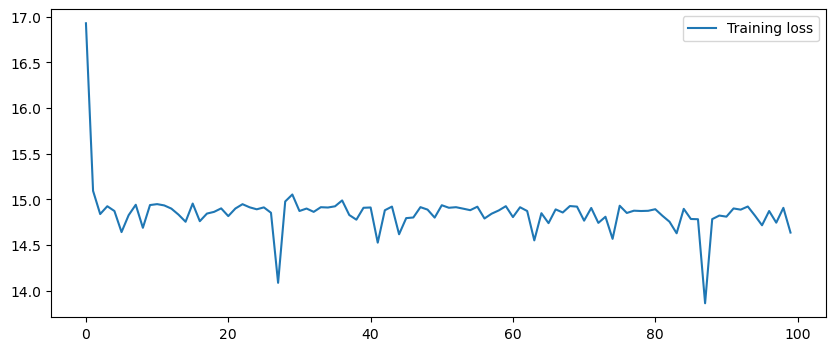

     prediction :  [2.427625894546509, 2.4242677688598633, 2.423581600189209, 2.4102935791015625, 2.4222397804260254, 2.417828321456909, 2.428652286529541, 2.4149117469787598, 2.420366048812866]
     true       :  tensor([ 3.,  8.,  1.,  3., 11.,  6., 18.,  2.,  5.])
     RMSLE SCORE :  0.7360619233810672


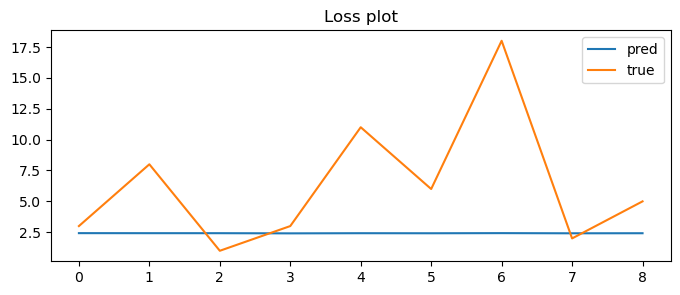

## CLEANING_10
Epoch: 0000 train loss : 730473.3125
Epoch: 0020 train loss : 687581.6250
Epoch: 0040 train loss : 616969.3750
Epoch: 0060 train loss : 556808.0625
Epoch: 0080 train loss : 491828.3125


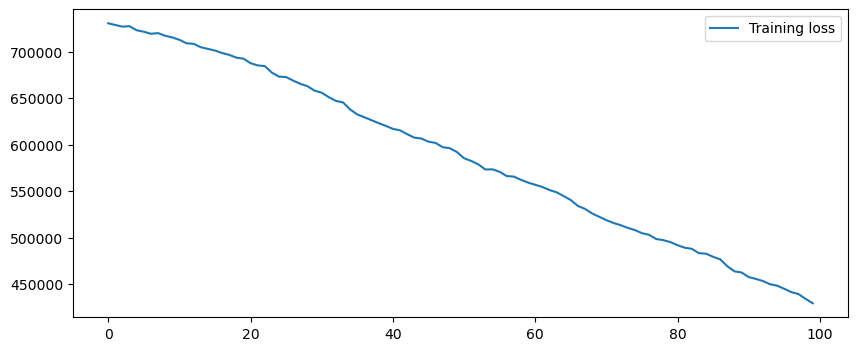

     prediction :  [226.1939239501953, 226.1939239501953, 226.1939239501953, 226.1939239501953, 226.1939239501953, 226.1939239501953, 226.1939239501953, 226.1939239501953, 226.1939239501953]
     true       :  tensor([632., 613., 446., 577., 953., 626., 617., 700., 635.])
     RMSLE SCORE :  1.0875669494489166


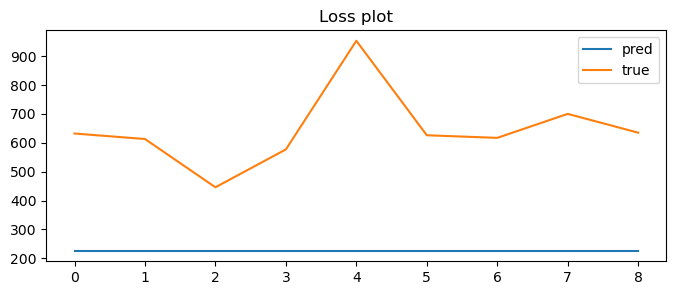

## DAIRY_10
Epoch: 0000 train loss : 64713.8125
Epoch: 0020 train loss : 33931.9766
Epoch: 0040 train loss : 19051.9082
Epoch: 0060 train loss : 13924.5410
Epoch: 0080 train loss : 12577.6143


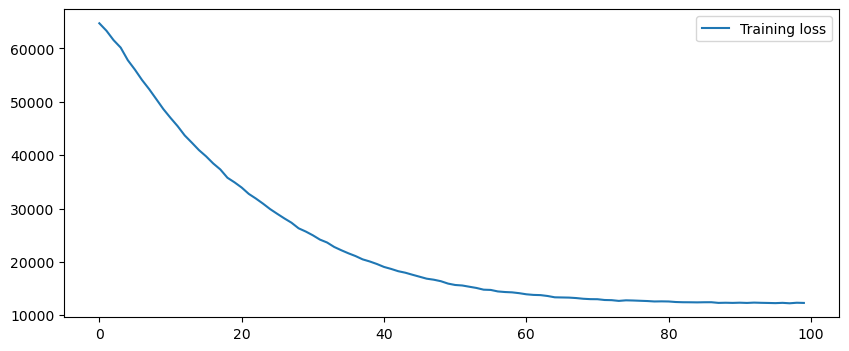

     prediction :  [224.19302368164062, 224.19302368164062, 224.19302368164062, 224.19302368164062, 224.19302368164062, 224.19302368164062, 224.19302368164062, 224.19302368164062, 224.19302368164062]
     true       :  tensor([255., 244., 195., 157., 372., 305., 219., 270., 335.])
     RMSLE SCORE :  0.07911232100118733


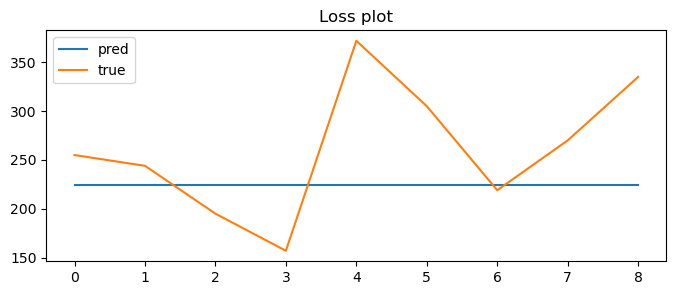

## DELI_10
Epoch: 0000 train loss : 65192.5234
Epoch: 0020 train loss : 31213.0938
Epoch: 0040 train loss : 14919.0439
Epoch: 0060 train loss : 8419.5371
Epoch: 0080 train loss : 6360.7236


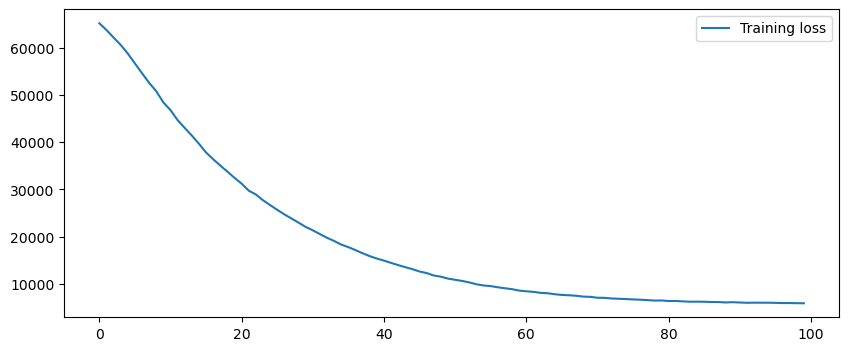

     prediction :  [234.88453674316406, 234.88453674316406, 234.88453674316406, 234.88453674316406, 234.88453674316406, 234.88453674316406, 234.88453674316406, 234.88453674316406, 234.88453674316406]
     true       :  tensor([197., 182., 185., 219., 279., 242., 281., 200., 253.])
     RMSLE SCORE :  0.027739550753477598


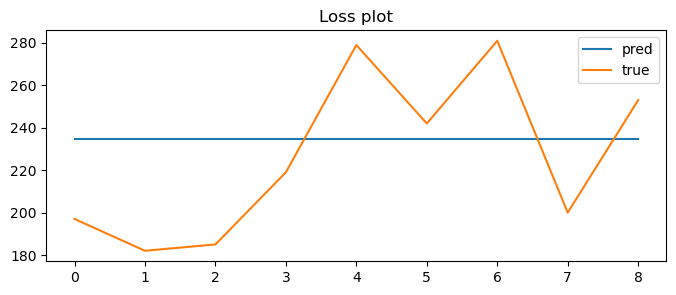

## EGGS_10
Epoch: 0000 train loss : 3241.6826
Epoch: 0020 train loss : 949.7747
Epoch: 0040 train loss : 946.3240
Epoch: 0060 train loss : 952.7822
Epoch: 0080 train loss : 953.4800


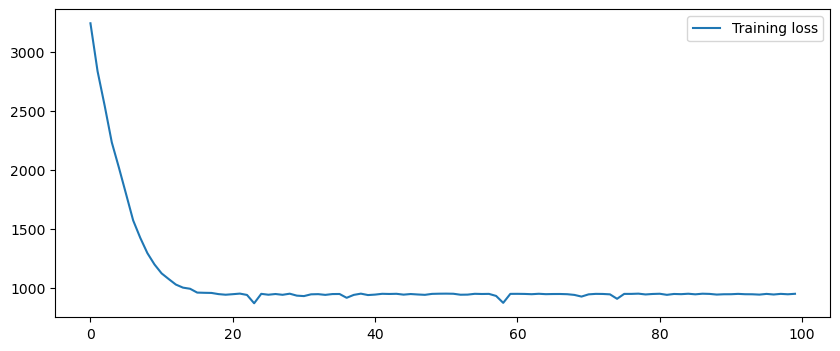

     prediction :  [49.67446517944336, 49.674346923828125, 49.674442291259766, 49.674442291259766, 49.67324447631836, 49.67447280883789, 49.67437744140625, 49.674476623535156, 49.67446517944336]
     true       :  tensor([ 30.,  47.,  44.,  14.,  68.,  32., 107.,  49.,  31.])
     RMSLE SCORE :  0.3115462231034188


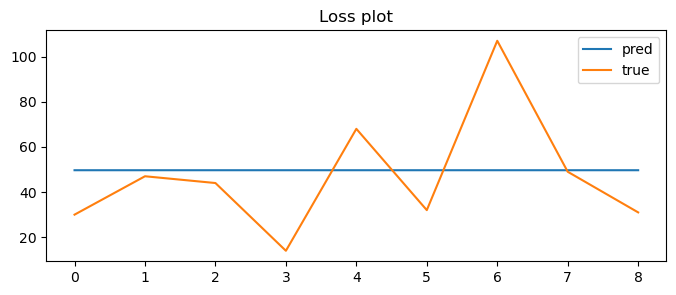

## FROZEN FOODS_10
Epoch: 0000 train loss : 7825.9004
Epoch: 0020 train loss : 6191.5366
Epoch: 0040 train loss : 6191.9937
Epoch: 0060 train loss : 6189.9180
Epoch: 0080 train loss : 6192.0820


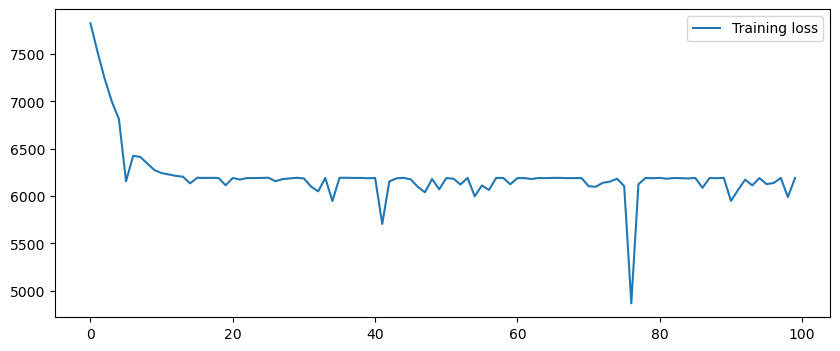

     prediction :  [42.34739685058594, 42.34735107421875, 42.34722900390625, 42.347164154052734, 42.347137451171875, 42.347415924072266, 42.34737777709961, 42.34716796875, 42.34690475463867]
     true       :  tensor([34., 26., 24., 23., 67., 37., 24., 19., 37.])
     RMSLE SCORE :  0.22898943470056599


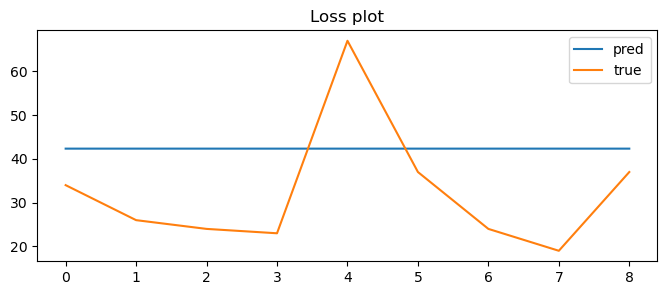

## GROCERY I_10
Epoch: 0000 train loss : 6196978.0000
Epoch: 0020 train loss : 6079951.0000
Epoch: 0040 train loss : 5972244.0000
Epoch: 0060 train loss : 5875085.0000
Epoch: 0080 train loss : 5786413.0000


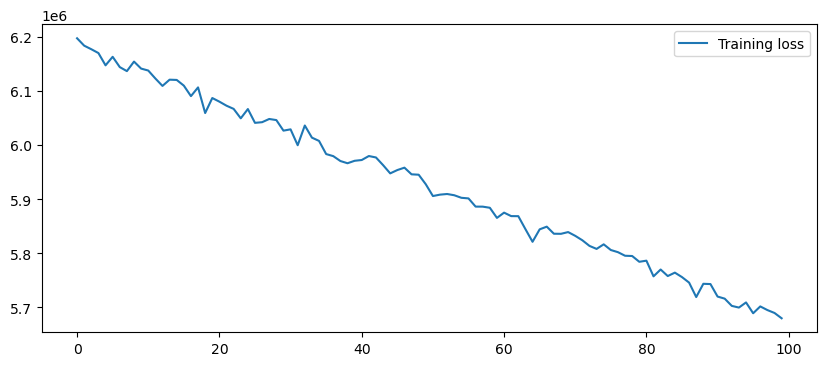

     prediction :  [105.95258331298828, 105.95258331298828, 105.95258331298828, 105.95258331298828, 105.95258331298828, 105.95258331298828, 105.95258331298828, 105.95258331298828, 105.95258331298828]
     true       :  tensor([2071., 1930., 1888., 1977., 2812., 2307., 2149., 2162., 2566.])
     RMSLE SCORE :  9.131745756030723


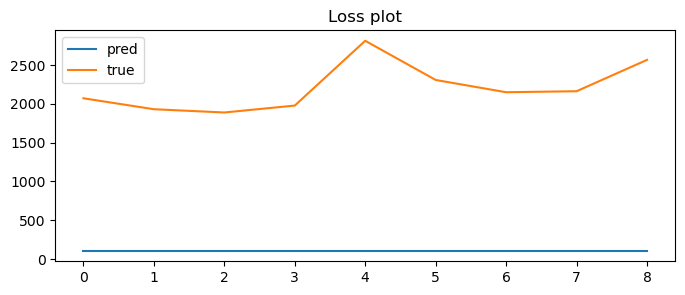

## GROCERY II_10
Epoch: 0000 train loss : 26.5585
Epoch: 0020 train loss : 18.8172
Epoch: 0040 train loss : 22.0084
Epoch: 0060 train loss : 21.9788
Epoch: 0080 train loss : 21.7874


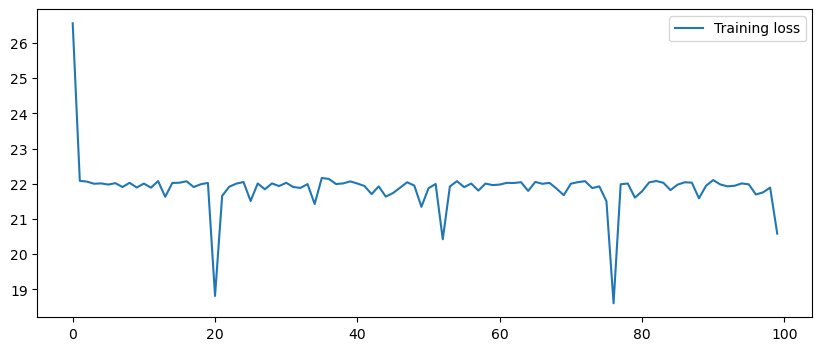

     prediction :  [3.553067684173584, 3.54463267326355, 3.5592076778411865, 3.562379837036133, 3.5601799488067627, 3.5767905712127686, 3.5646955966949463, 3.572343349456787, 3.5542969703674316]
     true       :  tensor([ 0.,  4.,  5.,  4., 20.,  6., 12.,  2.,  3.])
     RMSLE SCORE :  0.6881265726973728


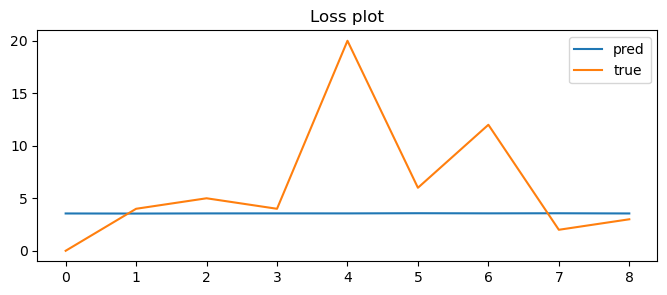

## HARDWARE_10
Epoch: 0000 train loss : 1.2101
Epoch: 0020 train loss : 1.0915
Epoch: 0040 train loss : 1.0791
Epoch: 0060 train loss : 1.0881
Epoch: 0080 train loss : 1.0743


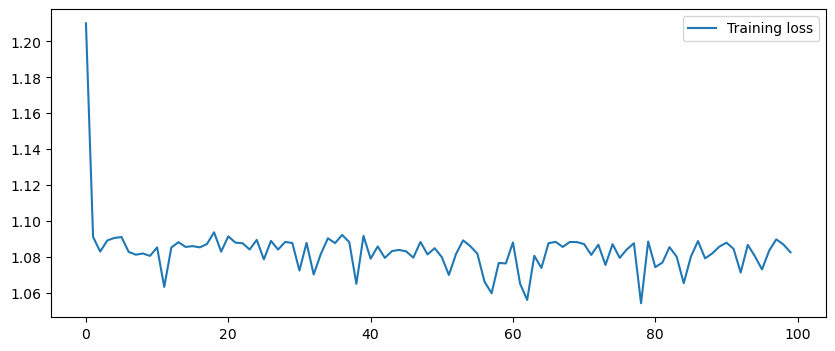

     prediction :  [0.7989274859428406, 0.7968472838401794, 0.7949314117431641, 0.7944369316101074, 0.7939616441726685, 0.7938269376754761, 0.7935082912445068, 0.7931293249130249, 0.796755313873291]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 1., 2.])
     RMSLE SCORE :  0.2968076135387837


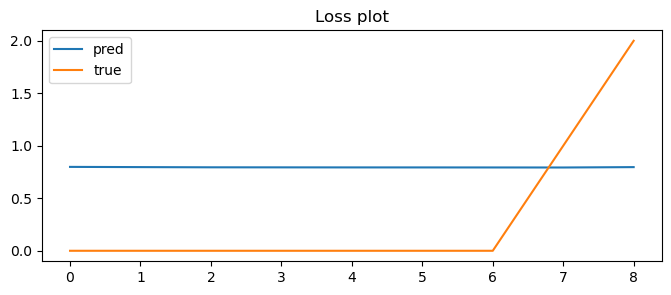

## HOME AND KITCHEN I_10
Epoch: 0000 train loss : 93.1677
Epoch: 0020 train loss : 73.3214
Epoch: 0040 train loss : 73.9216
Epoch: 0060 train loss : 72.5442
Epoch: 0080 train loss : 73.2443


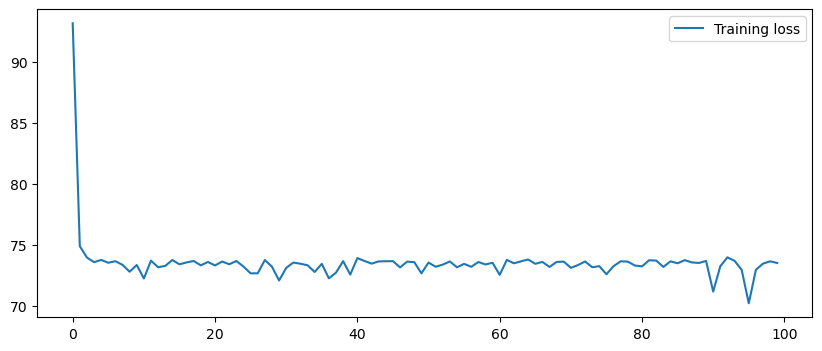

     prediction :  [6.720689296722412, 6.704218864440918, 6.6993279457092285, 6.710634708404541, 6.723756790161133, 6.722344875335693, 6.704249858856201, 6.718311786651611, 6.718411445617676]
     true       :  tensor([ 4.,  3.,  6., 15., 14.,  4., 10., 10.,  6.])
     RMSLE SCORE :  0.22797372249943593


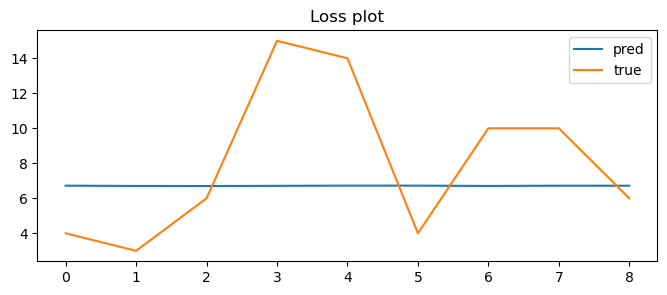

## HOME AND KITCHEN II_10
Epoch: 0000 train loss : 45.1538
Epoch: 0020 train loss : 33.1460
Epoch: 0040 train loss : 33.2402
Epoch: 0060 train loss : 32.7056
Epoch: 0080 train loss : 33.0762


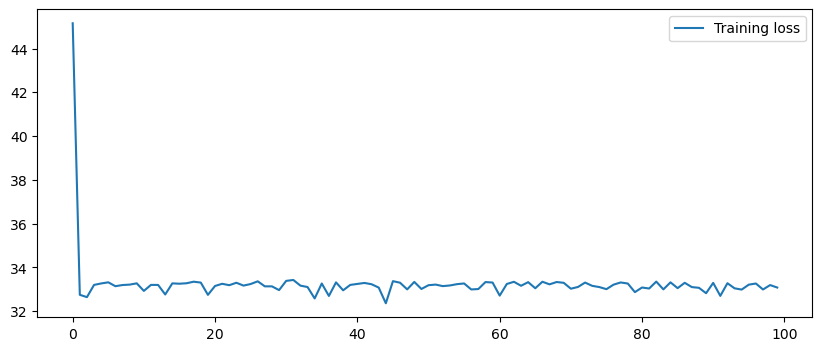

     prediction :  [4.876729488372803, 4.8542585372924805, 4.866792678833008, 4.876525402069092, 4.887149810791016, 4.887256622314453, 4.880690574645996, 4.90519380569458, 4.890766620635986]
     true       :  tensor([ 2.,  4.,  6.,  7.,  9.,  7., 15.,  8., 12.])
     RMSLE SCORE :  0.309337915277523


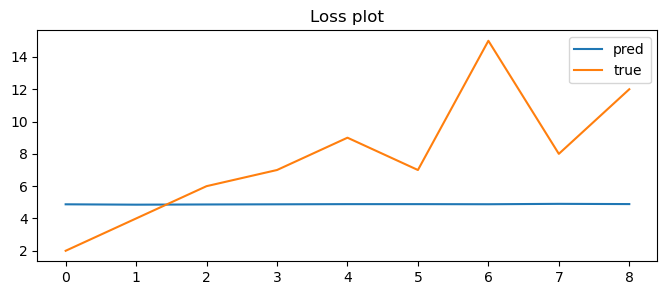

## HOME APPLIANCES_10
Epoch: 0000 train loss : 0.2211
Epoch: 0020 train loss : 0.2188
Epoch: 0040 train loss : 0.2184
Epoch: 0060 train loss : 0.2179
Epoch: 0080 train loss : 0.2178


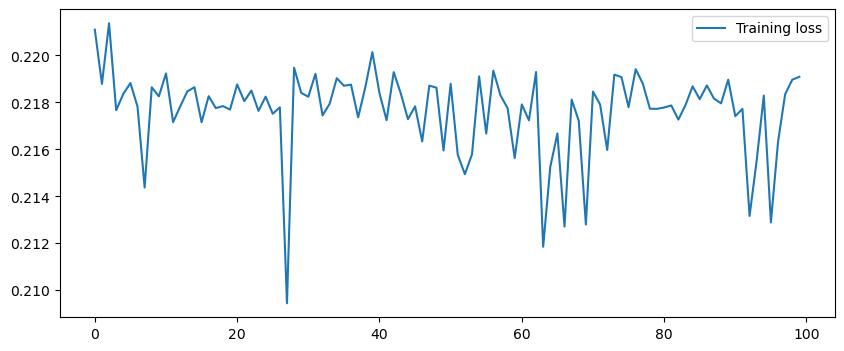

     prediction :  [0.19923755526542664, 0.1992344856262207, 0.19923236966133118, 0.19923236966133118, 0.19923236966133118, 0.19923236966133118, 0.19923236966133118, 0.19923236966133118, 0.19923236966133118]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.03300847145533741


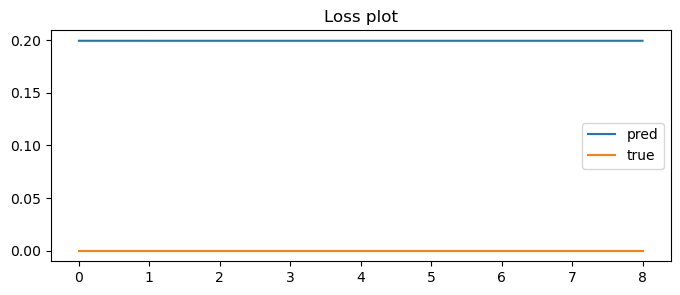

## HOME CARE_10
Epoch: 0000 train loss : 22383.3711
Epoch: 0020 train loss : 12669.4883
Epoch: 0040 train loss : 11899.0420
Epoch: 0060 train loss : 11832.2568
Epoch: 0080 train loss : 11830.0039


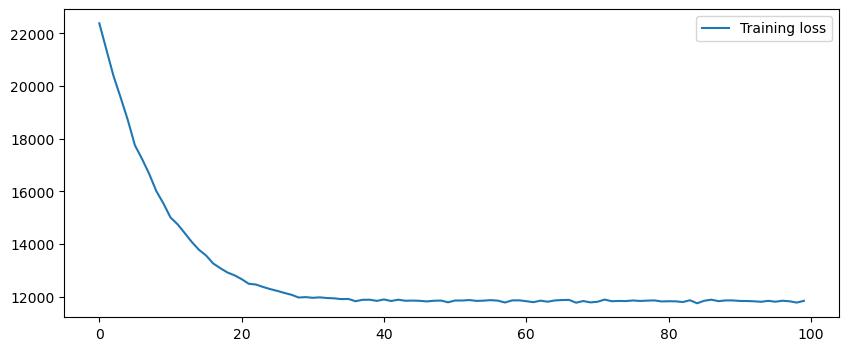

     prediction :  [102.58332061767578, 102.58332061767578, 102.58332061767578, 102.58332061767578, 102.58332061767578, 102.58332061767578, 102.58332061767578, 102.58332061767578, 102.58332061767578]
     true       :  tensor([149., 135., 118., 204., 252., 208., 147., 211., 186.])
     RMSLE SCORE :  0.33065978871341595


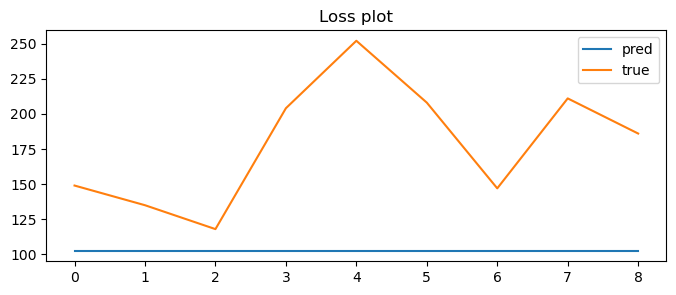

## LADIESWEAR_10
Epoch: 0000 train loss : 26.0862
Epoch: 0020 train loss : 22.4906
Epoch: 0040 train loss : 22.6571
Epoch: 0060 train loss : 22.6449
Epoch: 0080 train loss : 22.9157


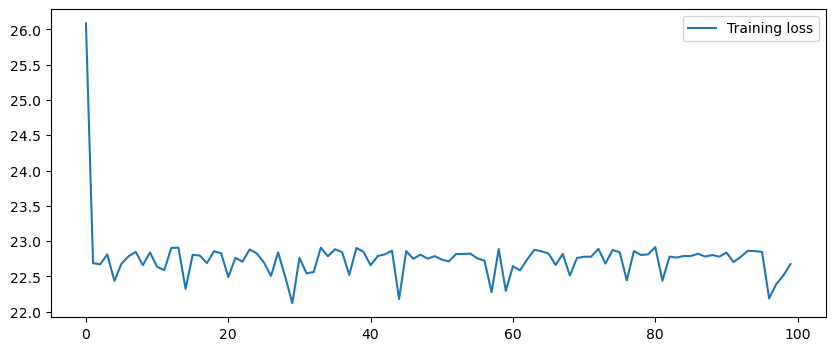

     prediction :  [2.7935571670532227, 2.780937671661377, 2.773514747619629, 2.778480052947998, 2.7672362327575684, 2.777393341064453, 2.815051555633545, 2.788304328918457, 2.780247211456299]
     true       :  tensor([ 4.,  3.,  4.,  2.,  4., 10.,  5.,  4.,  1.])
     RMSLE SCORE :  0.23575812344869293


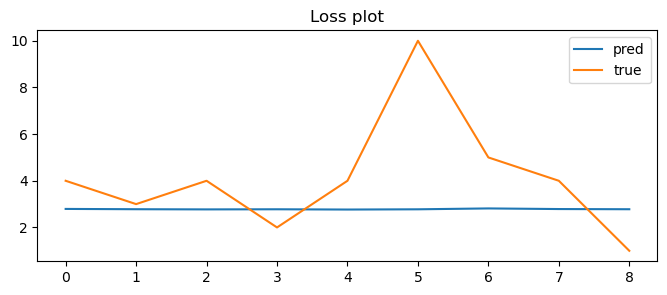

## LAWN AND GARDEN_10
Epoch: 0000 train loss : 0.0617
Epoch: 0020 train loss : 0.0613
Epoch: 0040 train loss : 0.0612
Epoch: 0060 train loss : 0.0612
Epoch: 0080 train loss : 0.0614


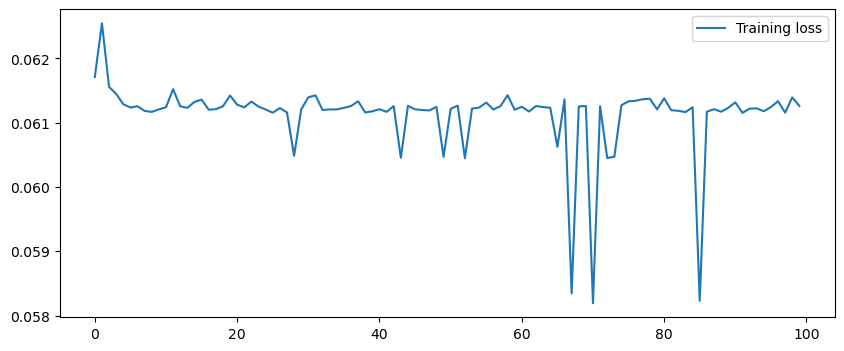

     prediction :  [0.027254676446318626, 0.027254676446318626, 0.027254676446318626, 0.027254676446318626, 0.027254676446318626, 0.027254676446318626, 0.027254676446318626, 0.027254676446318626, 0.027254676446318626]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.0007230657090470187


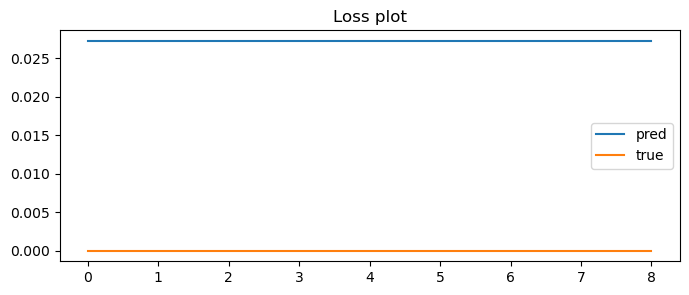

## LINGERIE_10
Epoch: 0000 train loss : 22.8092
Epoch: 0020 train loss : 18.5582
Epoch: 0040 train loss : 18.5690
Epoch: 0060 train loss : 18.4701
Epoch: 0080 train loss : 18.6733


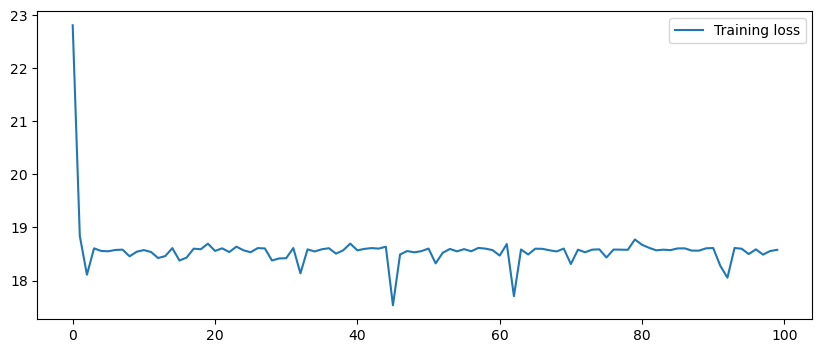

     prediction :  [3.6644654273986816, 3.6484508514404297, 3.6820921897888184, 3.6494269371032715, 3.664273738861084, 3.6649460792541504, 3.675544261932373, 3.6654553413391113, 3.6651835441589355]
     true       :  tensor([0., 6., 0., 2., 2., 4., 2., 2., 1.])
     RMSLE SCORE :  0.7136722104150682


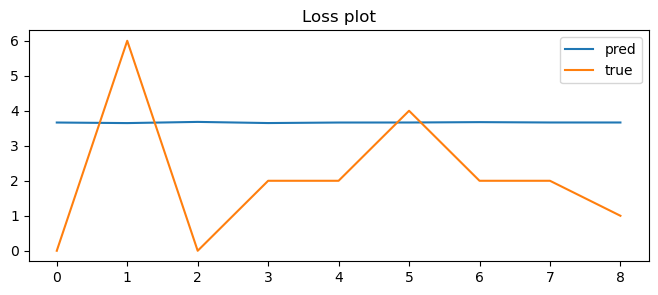

## LIQUOR,WINE,BEER_10
Epoch: 0000 train loss : 445.5157
Epoch: 0020 train loss : 331.2494
Epoch: 0040 train loss : 323.6017
Epoch: 0060 train loss : 334.1585
Epoch: 0080 train loss : 334.8439


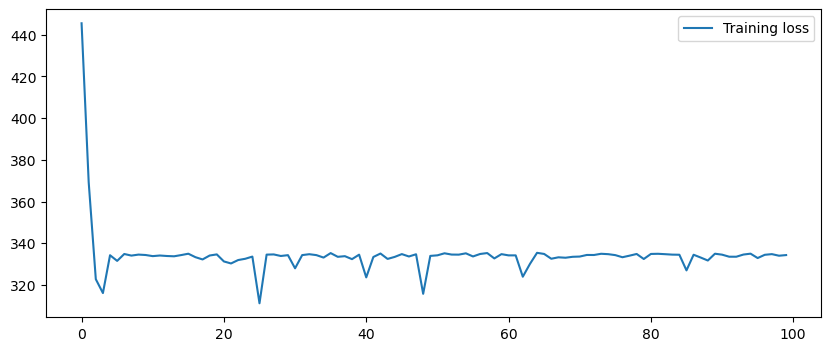

     prediction :  [12.314230918884277, 12.306161880493164, 12.322240829467773, 12.317791938781738, 12.323010444641113, 12.32125473022461, 12.320124626159668, 12.322453498840332, 12.318885803222656]
     true       :  tensor([ 0., 11.,  5., 13., 25.,  9., 13.,  6.,  3.])
     RMSLE SCORE :  1.0827056490783178


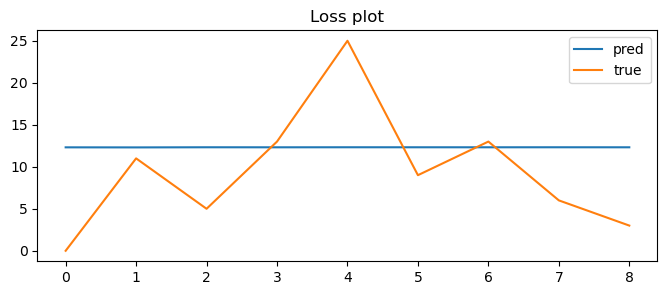

## MAGAZINES_10
Epoch: 0000 train loss : 0.2510
Epoch: 0020 train loss : 0.2508
Epoch: 0040 train loss : 0.2527
Epoch: 0060 train loss : 0.2545
Epoch: 0080 train loss : 0.2534


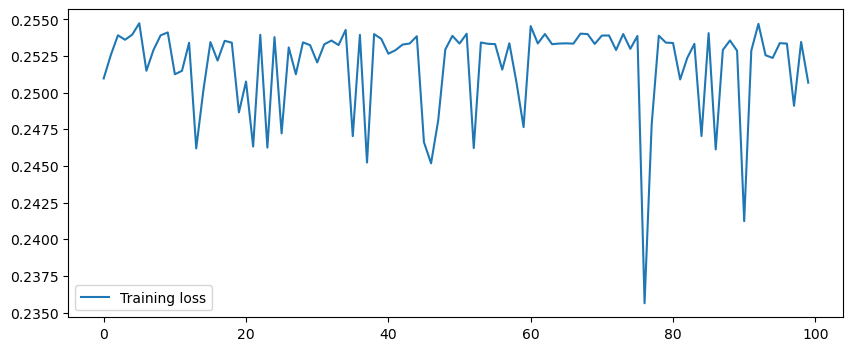

     prediction :  [0.1544046849012375, 0.1527821570634842, 0.15203222632408142, 0.15516385436058044, 0.15469227731227875, 0.1529037207365036, 0.15374410152435303, 0.15250550210475922, 0.15359319746494293]
     true       :  tensor([0., 0., 2., 1., 0., 1., 0., 1., 1.])
     RMSLE SCORE :  0.24548377268592836


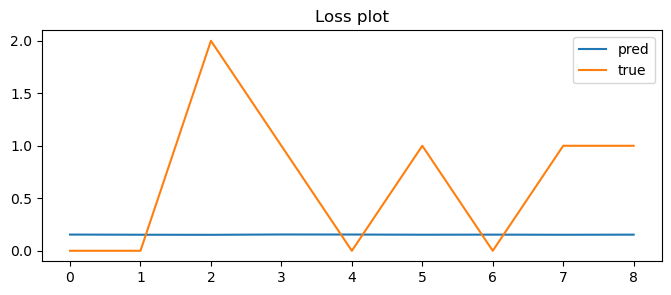

## MEATS_10
Epoch: 0000 train loss : 40402.5273
Epoch: 0020 train loss : 15471.8740
Epoch: 0040 train loss : 5938.1216
Epoch: 0060 train loss : 3443.9246
Epoch: 0080 train loss : 2996.3457


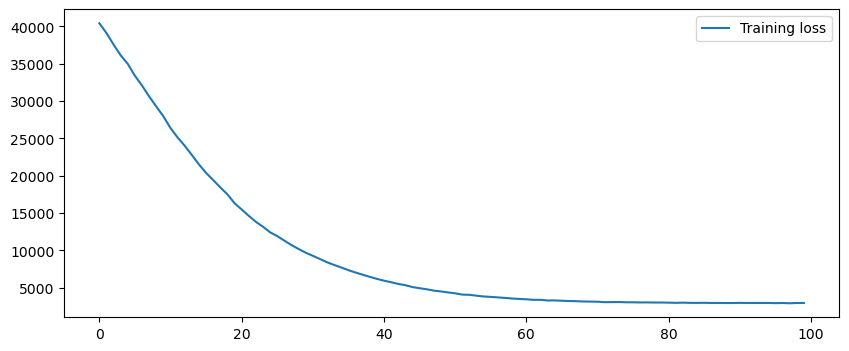

     prediction :  [192.90719604492188, 192.90719604492188, 192.90719604492188, 192.90719604492188, 192.90719604492188, 192.90719604492188, 192.90719604492188, 192.90719604492188, 192.90719604492188]
     true       :  tensor([156.8030, 135.9430, 186.8380,  99.8030, 159.5160, 166.6930, 133.4650,
        127.3960, 148.4590])
     RMSLE SCORE :  0.11344407017072194


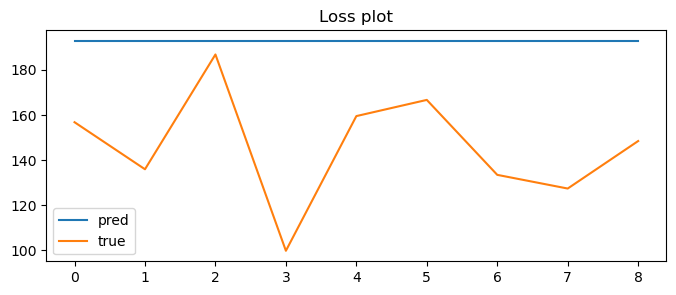

## PERSONAL CARE_10
Epoch: 0000 train loss : 34211.1992
Epoch: 0020 train loss : 11634.4580
Epoch: 0040 train loss : 4792.0918
Epoch: 0060 train loss : 3531.9346
Epoch: 0080 train loss : 3401.7100


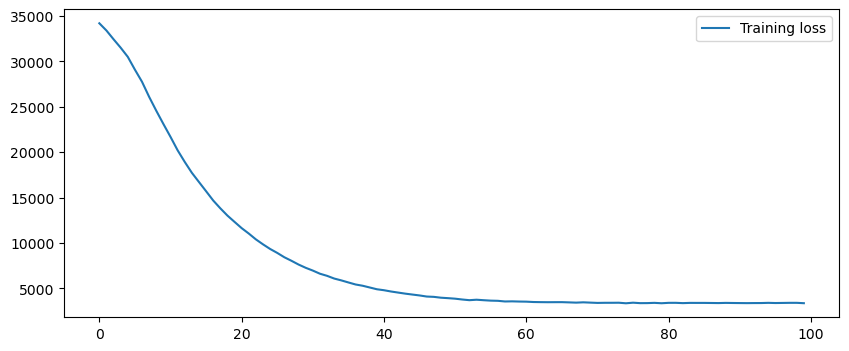

     prediction :  [175.9567108154297, 175.9567108154297, 175.9567108154297, 175.9567108154297, 175.9567108154297, 175.9567108154297, 175.9567108154297, 175.9567108154297, 175.9567108154297]
     true       :  tensor([161., 152., 130., 112., 226., 174., 185., 160., 195.])
     RMSLE SCORE :  0.044951158553089926


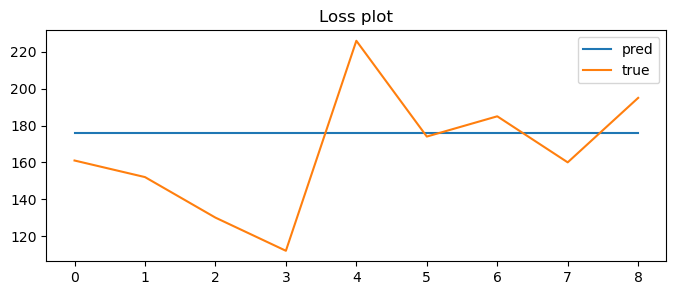

## PET SUPPLIES_10
Epoch: 0000 train loss : 0.2383
Epoch: 0020 train loss : 0.2226
Epoch: 0040 train loss : 0.2230
Epoch: 0060 train loss : 0.2207
Epoch: 0080 train loss : 0.2222


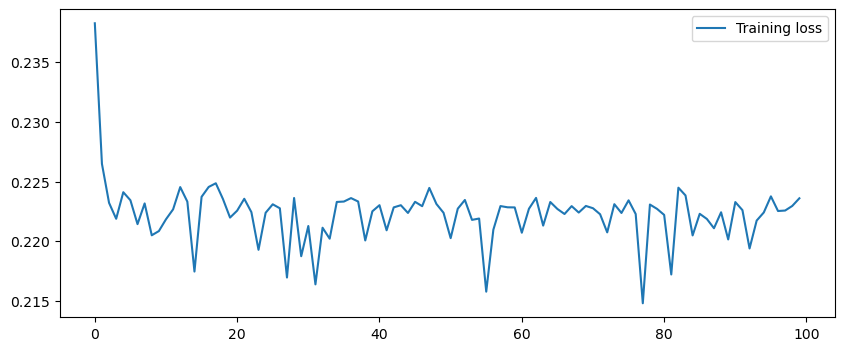

     prediction :  [0.15335360169410706, 0.1534072607755661, 0.15376538038253784, 0.15352903306484222, 0.1528935432434082, 0.15247827768325806, 0.1509055495262146, 0.15367883443832397, 0.15341198444366455]
     true       :  tensor([1., 0., 0., 0., 0., 2., 0., 1., 0.])
     RMSLE SCORE :  0.1825104965639171


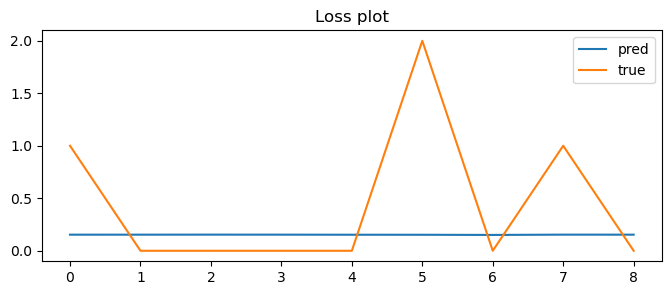

## PLAYERS AND ELECTRONICS_10
Epoch: 0000 train loss : 8.2070
Epoch: 0020 train loss : 7.0714
Epoch: 0040 train loss : 7.0215
Epoch: 0060 train loss : 7.0584
Epoch: 0080 train loss : 7.0416


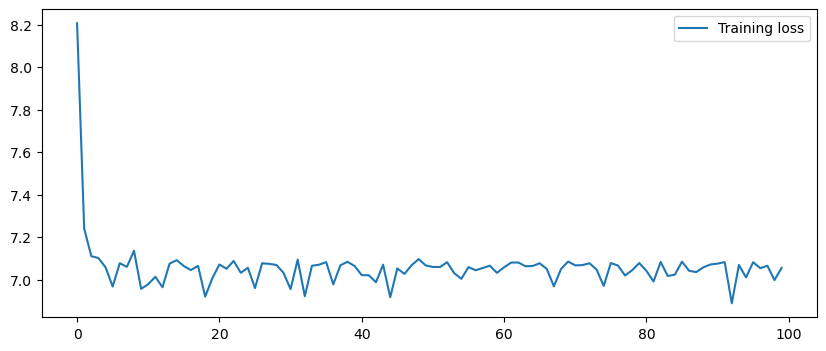

     prediction :  [1.848130464553833, 1.8488869667053223, 1.8509371280670166, 1.8506062030792236, 1.854238748550415, 1.8460206985473633, 1.8540115356445312, 1.8395743370056152, 1.8398163318634033]
     true       :  tensor([4., 4., 7., 2., 6., 2., 1., 2., 3.])
     RMSLE SCORE :  0.30607937401477087


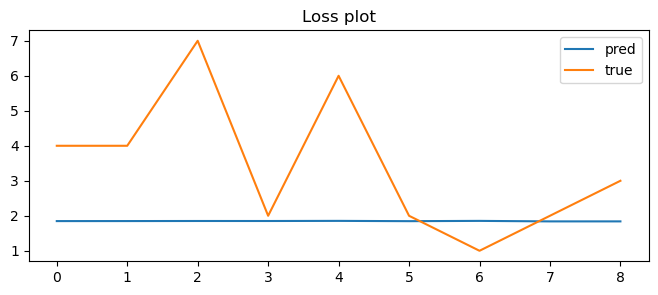

## POULTRY_10
Epoch: 0000 train loss : 37975.3867
Epoch: 0020 train loss : 15499.6973
Epoch: 0040 train loss : 7584.9429
Epoch: 0060 train loss : 5752.7720
Epoch: 0080 train loss : 5453.8550


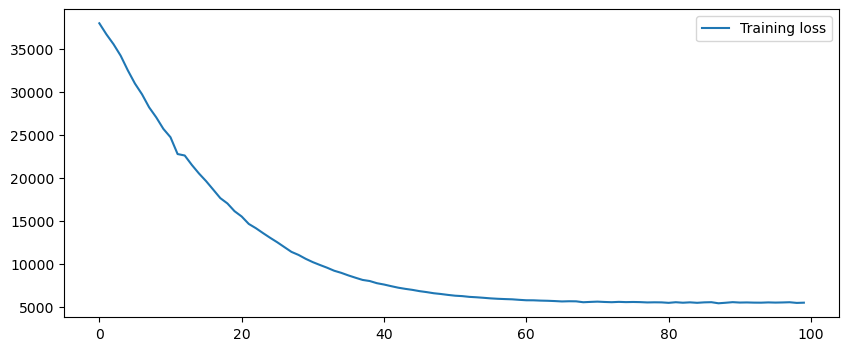

     prediction :  [181.07406616210938, 181.07406616210938, 181.07406616210938, 181.07406616210938, 181.07406616210938, 181.07406616210938, 181.07406616210938, 181.07406616210938, 181.07406616210938]
     true       :  tensor([113.1940, 105.4590, 159.3670, 188.4610, 144.5390, 174.4110, 110.5840,
        143.8790, 134.0960])
     RMSLE SCORE :  0.10621162573122753


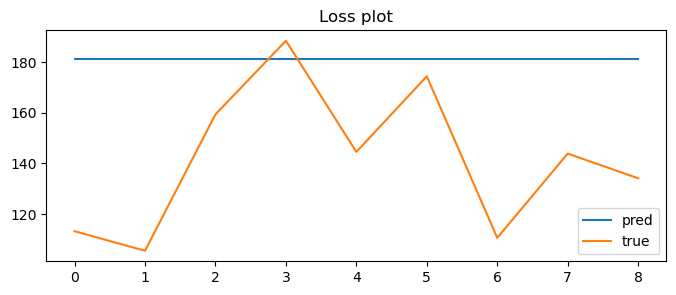

## PREPARED FOODS_10
Epoch: 0000 train loss : 396.5417
Epoch: 0020 train loss : 133.2190
Epoch: 0040 train loss : 133.3272
Epoch: 0060 train loss : 133.3053
Epoch: 0080 train loss : 133.0930


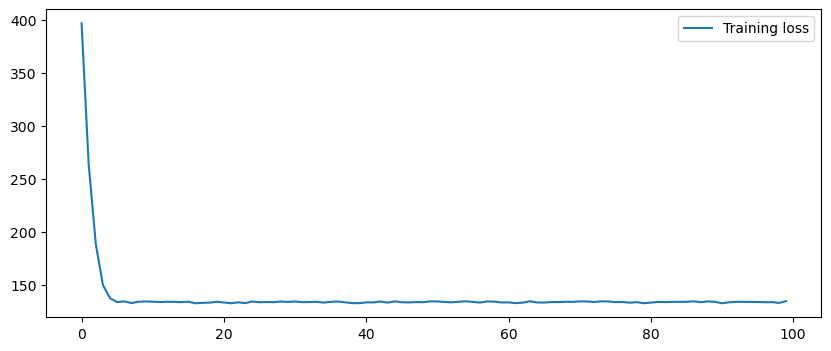

     prediction :  [18.359729766845703, 18.35969352722168, 18.35968780517578, 18.359394073486328, 18.35926055908203, 18.35968780517578, 18.359331130981445, 18.359638214111328, 18.359716415405273]
     true       :  tensor([35., 27., 29., 27., 37., 28., 35., 36., 48.])
     RMSLE SCORE :  0.3482065055205246


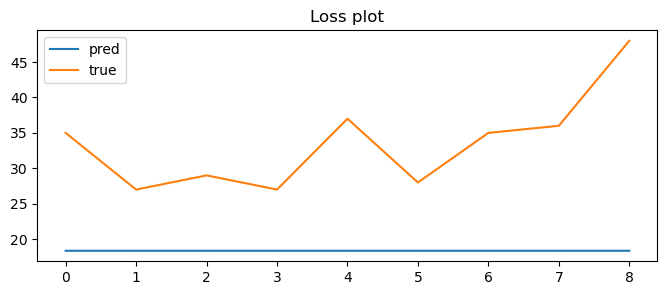

## PRODUCE_10
Epoch: 0000 train loss : 32468.6074
Epoch: 0020 train loss : 20879.1406
Epoch: 0040 train loss : 18294.0742
Epoch: 0060 train loss : 17930.9082
Epoch: 0080 train loss : 17798.6641


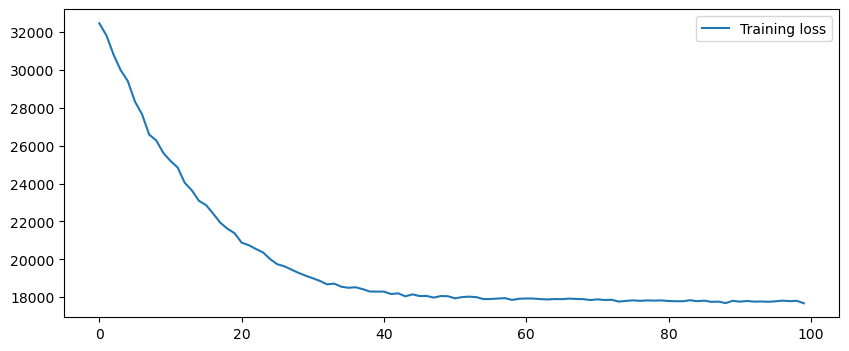

     prediction :  [117.03817749023438, 117.03817749023438, 117.03817749023438, 117.03817749023438, 117.03817749023438, 117.03817749023438, 117.03817749023438, 117.03817749023438, 117.03817749023438]
     true       :  tensor([293.3070, 194.2240, 170.5800, 196.0420, 272.9040, 258.9690, 224.3720,
        289.7820, 206.0120])
     RMSLE SCORE :  0.48544066860503965


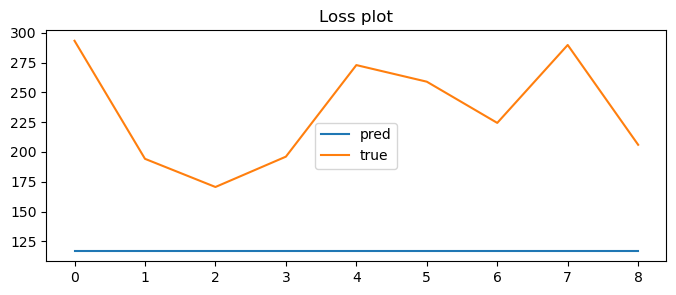

## SCHOOL AND OFFICE SUPPLIES_10
Epoch: 0000 train loss : 6.7048
Epoch: 0020 train loss : 6.6529
Epoch: 0040 train loss : 6.6559
Epoch: 0060 train loss : 6.6531
Epoch: 0080 train loss : 6.6520


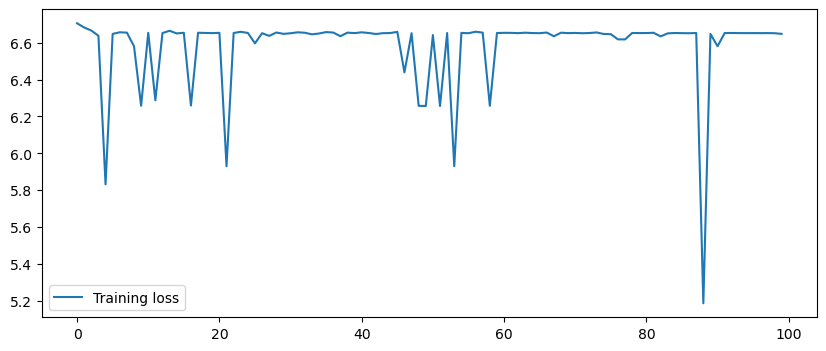

     prediction :  [0.39556917548179626, 0.6335384845733643, 0.5325028896331787, 0.31620094180107117, 0.5206151008605957, 0.5626575350761414, 0.6581870913505554, 0.32825562357902527, 0.4432753026485443]
     true       :  tensor([22., 30.,  1., 19., 17., 25.,  5.,  6.,  3.])
     RMSLE SCORE :  4.828643355771365


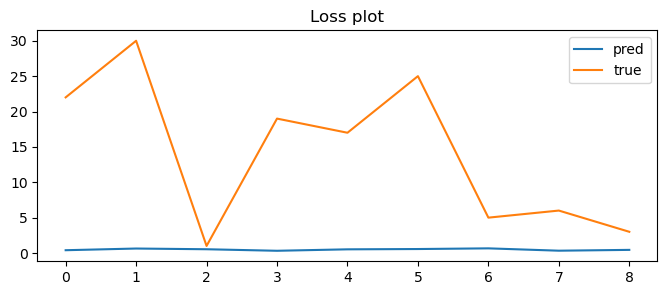

## SEAFOOD_10
Epoch: 0000 train loss : 12.4700
Epoch: 0020 train loss : 8.7156
Epoch: 0040 train loss : 8.6579
Epoch: 0060 train loss : 8.6847
Epoch: 0080 train loss : 8.7780


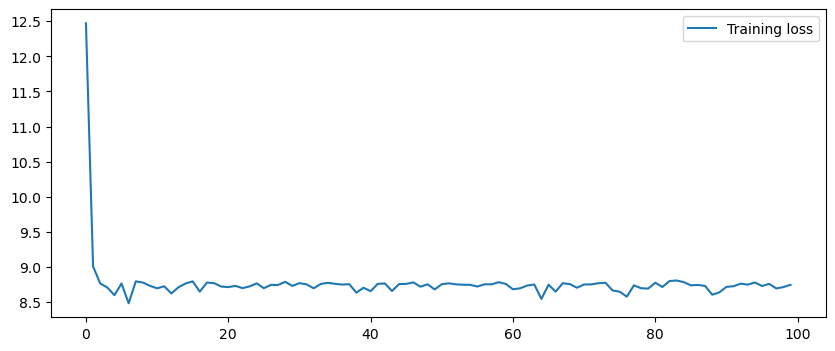

     prediction :  [3.0376639366149902, 3.0286049842834473, 3.032745361328125, 3.0283477306365967, 3.0226311683654785, 3.0465598106384277, 3.0172207355499268, 3.041924238204956, 3.023235321044922]
     true       :  tensor([2., 3., 2., 1., 5., 0., 6., 1., 0.])
     RMSLE SCORE :  0.6134771796407054


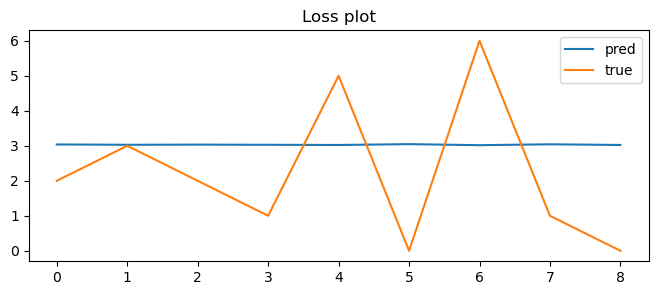

## AUTOMOTIVE_11
Epoch: 0000 train loss : 41.4687
Epoch: 0020 train loss : 17.3908
Epoch: 0040 train loss : 17.4749
Epoch: 0060 train loss : 17.3657
Epoch: 0080 train loss : 17.3768


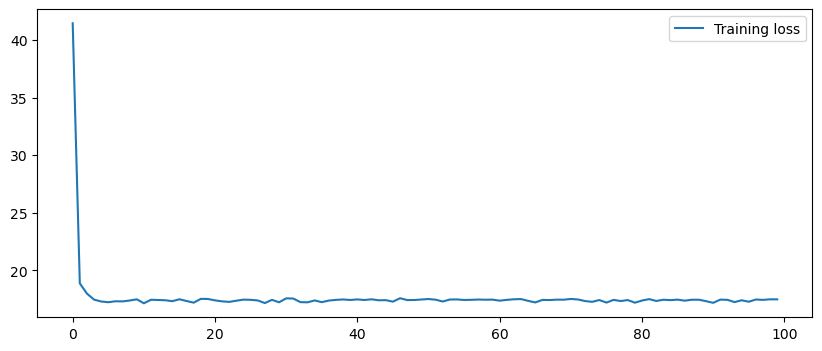

     prediction :  [6.504270553588867, 6.495202541351318, 6.506201267242432, 6.504269123077393, 6.504265785217285, 6.509095668792725, 6.507773399353027, 6.511043071746826, 6.4905853271484375]
     true       :  tensor([ 3.,  7.,  6.,  6.,  9.,  8., 11.,  2.,  4.])
     RMSLE SCORE :  0.19451825819823604


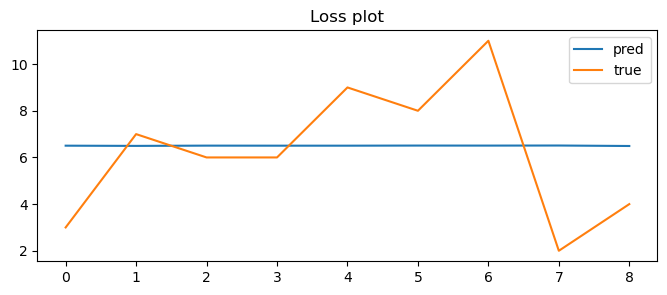

## BABY CARE_11
Epoch: 0000 train loss : 0.1845
Epoch: 0020 train loss : 0.1755
Epoch: 0040 train loss : 0.1784
Epoch: 0060 train loss : 0.1784
Epoch: 0080 train loss : 0.1778


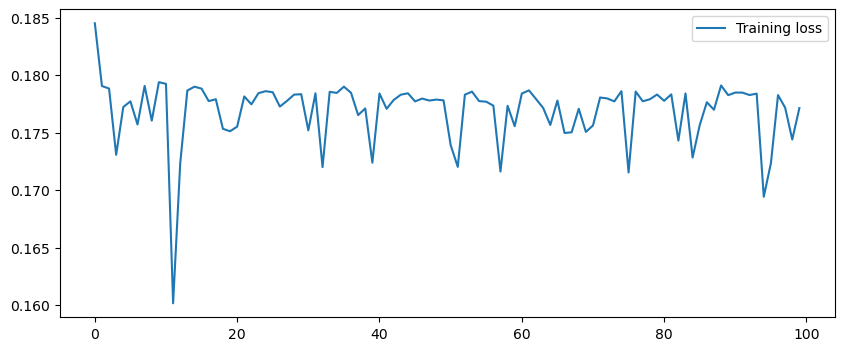

     prediction :  [0.10965848714113235, 0.1094580888748169, 0.11397558450698853, 0.11016832292079926, 0.1096380203962326, 0.10940604656934738, 0.10927154868841171, 0.11389442533254623, 0.11938563734292984]
     true       :  tensor([0., 1., 0., 0., 0., 0., 1., 3., 1.])
     RMSLE SCORE :  0.30232289667183165


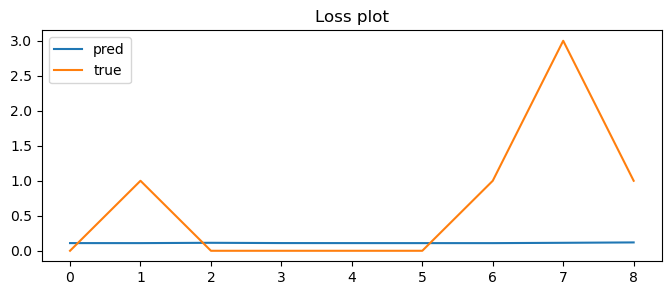

## BEAUTY_11
Epoch: 0000 train loss : 17.0242
Epoch: 0020 train loss : 9.2457
Epoch: 0040 train loss : 9.3403
Epoch: 0060 train loss : 9.3341
Epoch: 0080 train loss : 9.2978


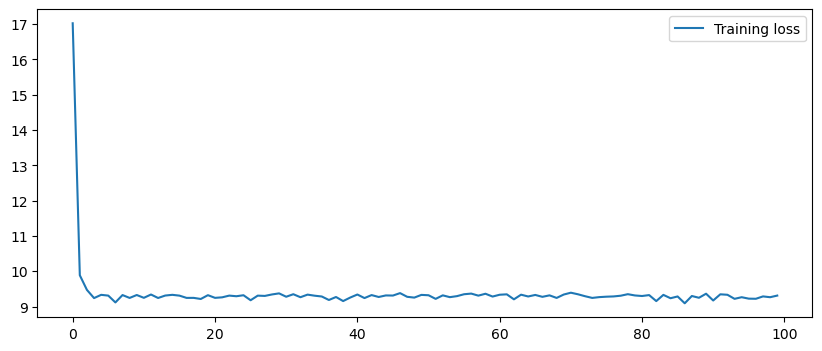

     prediction :  [4.273941993713379, 4.272621154785156, 4.269017219543457, 4.273990631103516, 4.26584005355835, 4.268091201782227, 4.275154113769531, 4.2717509269714355, 4.255406856536865]
     true       :  tensor([ 9.,  7., 10.,  7.,  8., 11., 10.,  4.,  4.])
     RMSLE SCORE :  0.31209843067025533


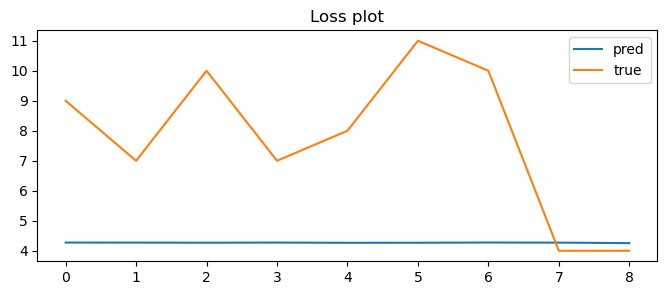

## BEVERAGES_11
Epoch: 0000 train loss : 12625684.0000
Epoch: 0020 train loss : 12409954.0000
Epoch: 0040 train loss : 12201364.0000
Epoch: 0060 train loss : 11961572.0000
Epoch: 0080 train loss : 11725906.0000


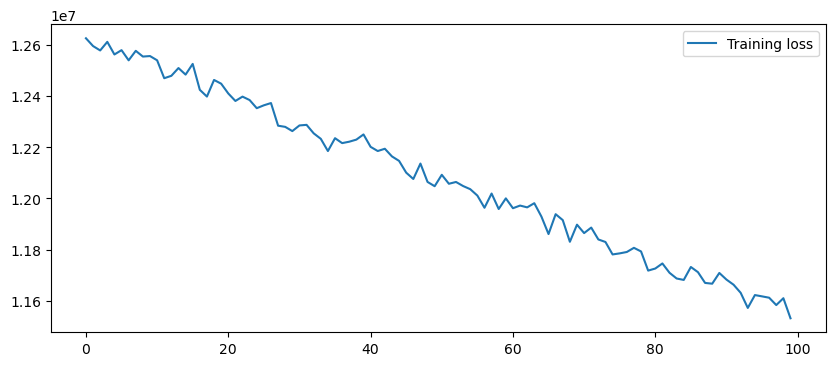

     prediction :  [160.72323608398438, 160.72323608398438, 160.72323608398438, 160.72323608398438, 160.72323608398438, 160.72323608398438, 160.72323608398438, 160.72323608398438, 160.72323608398438]
     true       :  tensor([3909., 3615., 4301., 4842., 4636., 5030., 3867., 2852., 3622.])
     RMSLE SCORE :  10.353809485383097


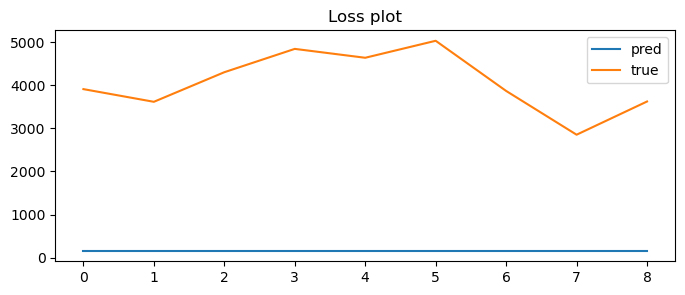

## BOOKS_11
Epoch: 0000 train loss : 0.0006
Epoch: 0020 train loss : 0.0000
Epoch: 0040 train loss : 0.0000
Epoch: 0060 train loss : 0.0000
Epoch: 0080 train loss : 0.0000


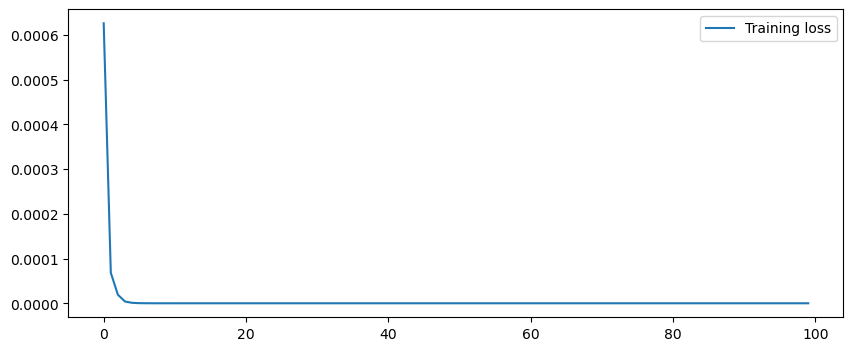

     prediction :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.0


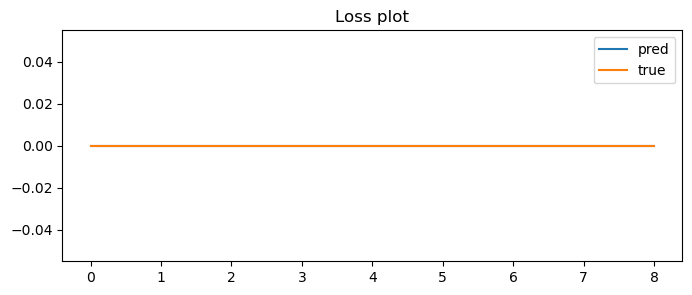

## BREAD/BAKERY_11
Epoch: 0000 train loss : 367491.2812
Epoch: 0020 train loss : 318895.4688
Epoch: 0040 train loss : 236156.6875
Epoch: 0060 train loss : 168890.0625
Epoch: 0080 train loss : 122955.3125


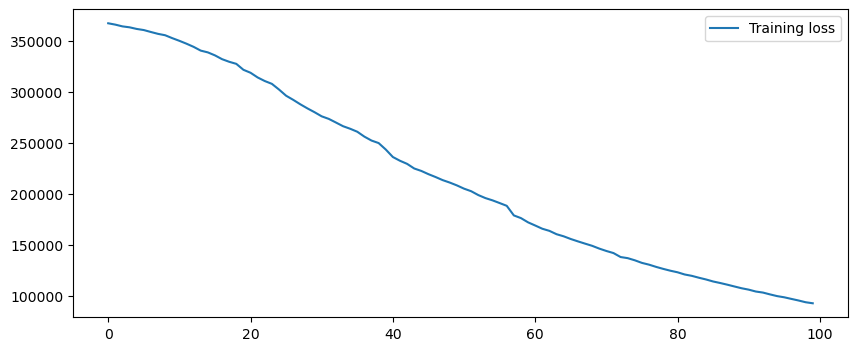

     prediction :  [315.355224609375, 315.355224609375, 315.355224609375, 315.355224609375, 315.355224609375, 315.355224609375, 315.355224609375, 315.355224609375, 315.355224609375]
     true       :  tensor([603., 485., 580., 553., 547., 627., 532., 413., 593.])
     RMSLE SCORE :  0.31104780788617226


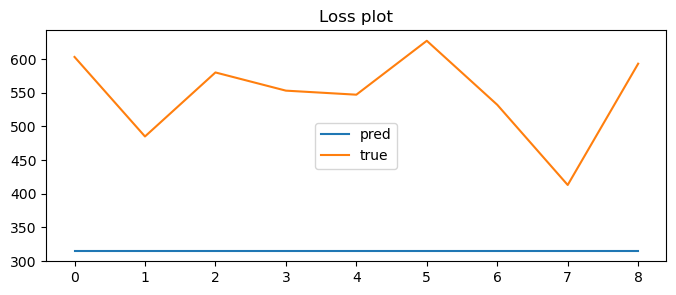

## CELEBRATION_11
Epoch: 0000 train loss : 185.4447
Epoch: 0020 train loss : 135.1020
Epoch: 0040 train loss : 134.8250
Epoch: 0060 train loss : 134.4226
Epoch: 0080 train loss : 133.3926


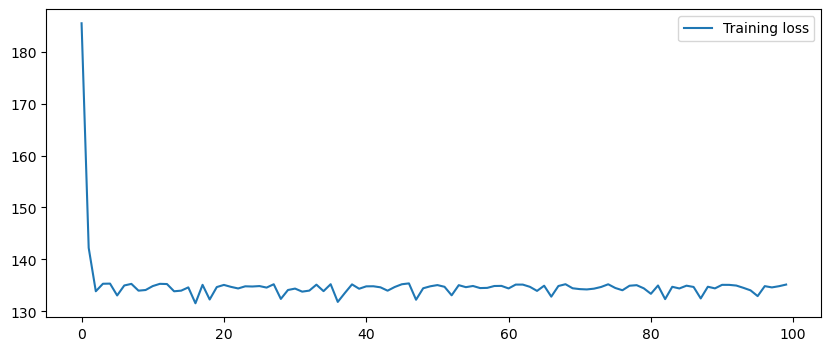

     prediction :  [9.139910697937012, 9.141557693481445, 9.142663955688477, 9.145471572875977, 9.14476490020752, 9.145275115966797, 9.137314796447754, 9.107532501220703, 9.143298149108887]
     true       :  tensor([15., 16., 27., 21., 25., 13.,  9., 17., 17.])
     RMSLE SCORE :  0.41741947141862995


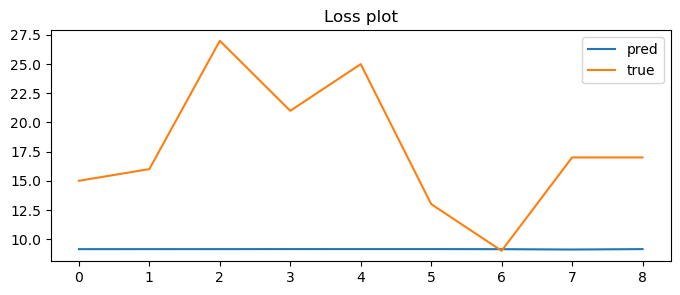

## CLEANING_11
Epoch: 0000 train loss : 3917256.0000
Epoch: 0020 train loss : 3809977.5000
Epoch: 0040 train loss : 3697316.2500
Epoch: 0060 train loss : 3521757.5000
Epoch: 0080 train loss : 3338027.5000


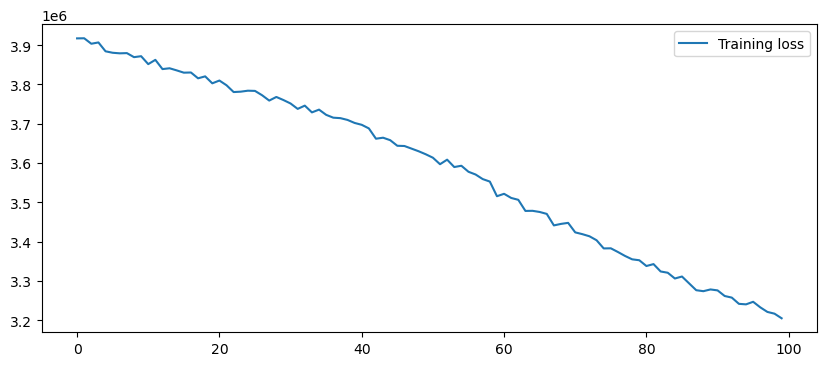

     prediction :  [197.2929229736328, 197.2929229736328, 197.2929229736328, 197.2929229736328, 197.2929229736328, 197.2929229736328, 197.2929229736328, 197.2929229736328, 197.2929229736328]
     true       :  tensor([1952., 1544., 1572., 1686., 1640., 1631., 1640., 1458., 1736.])
     RMSLE SCORE :  4.487507320692232


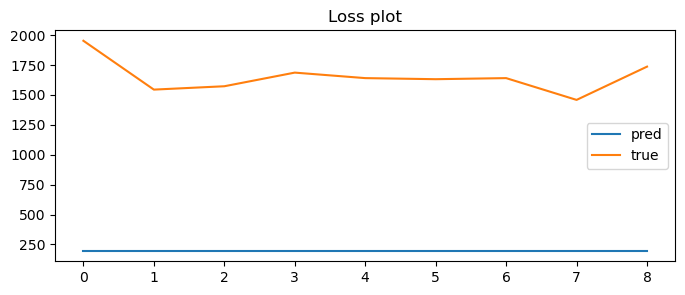

## DAIRY_11
Epoch: 0000 train loss : 256266.2969
Epoch: 0020 train loss : 193601.8438
Epoch: 0040 train loss : 139064.1094
Epoch: 0060 train loss : 98383.4531
Epoch: 0080 train loss : 74976.2188


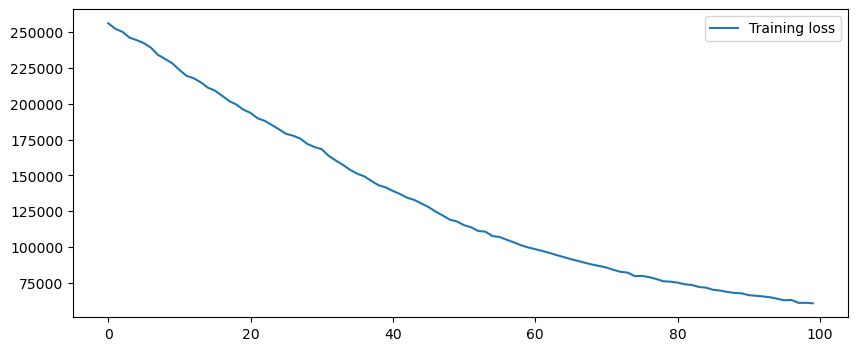

     prediction :  [331.6379699707031, 331.6379699707031, 331.6379699707031, 331.6379699707031, 331.6379699707031, 331.6379699707031, 331.6379699707031, 331.6379699707031, 331.6379699707031]
     true       :  tensor([503., 582., 426., 476., 577., 670., 534., 492., 644.])
     RMSLE SCORE :  0.25518232720596784


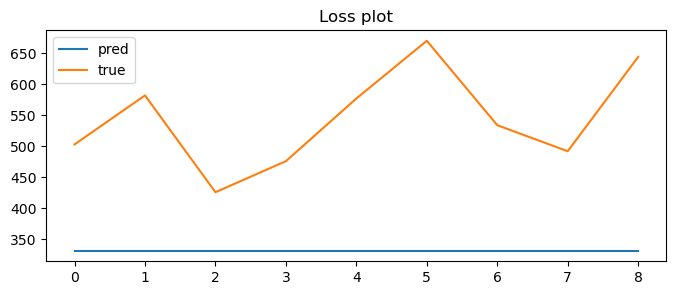

## DELI_11
Epoch: 0000 train loss : 178908.6094
Epoch: 0020 train loss : 122596.4609
Epoch: 0040 train loss : 78835.9062
Epoch: 0060 train loss : 52617.8281
Epoch: 0080 train loss : 36007.8711


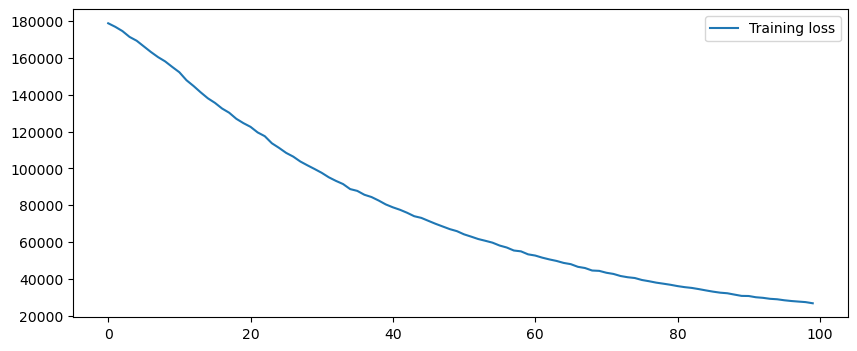

     prediction :  [306.97265625, 306.97265625, 306.97265625, 306.97265625, 306.97265625, 306.97265625, 306.97265625, 306.97265625, 306.97265625]
     true       :  tensor([488.0000, 455.0420, 347.5750, 509.7010, 457.3550, 493.2850, 357.4180,
        394.5690, 431.5320])
     RMSLE SCORE :  0.1357765212598533


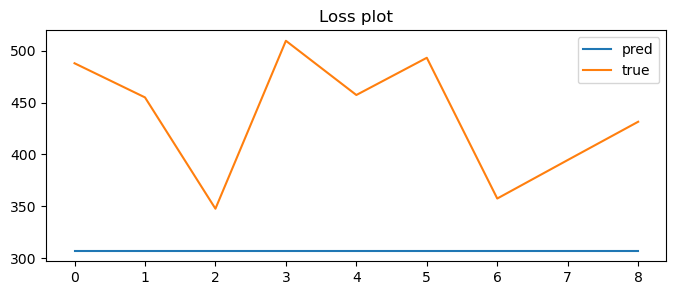

## EGGS_11
Epoch: 0000 train loss : 39542.1562
Epoch: 0020 train loss : 22391.1406
Epoch: 0040 train loss : 17633.0371
Epoch: 0060 train loss : 16744.2031
Epoch: 0080 train loss : 16754.4844


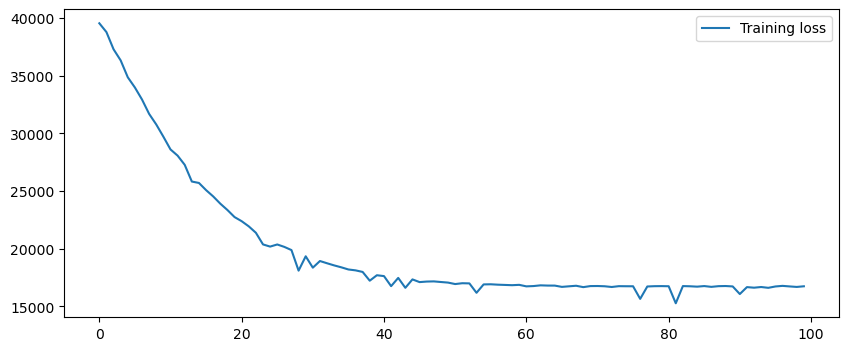

     prediction :  [152.06236267089844, 152.06236267089844, 152.06236267089844, 152.06236267089844, 152.06236267089844, 152.06236267089844, 152.06236267089844, 152.06236267089844, 152.06236267089844]
     true       :  tensor([276., 119.,  92.,  81., 135., 156., 309.,  66., 165.])
     RMSLE SCORE :  0.25007040735497066


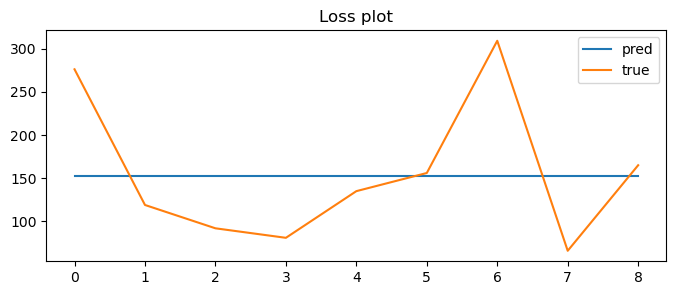

## FROZEN FOODS_11
Epoch: 0000 train loss : 20859.3125
Epoch: 0020 train loss : 12218.8730
Epoch: 0040 train loss : 11536.4102
Epoch: 0060 train loss : 11525.4092
Epoch: 0080 train loss : 11519.8213


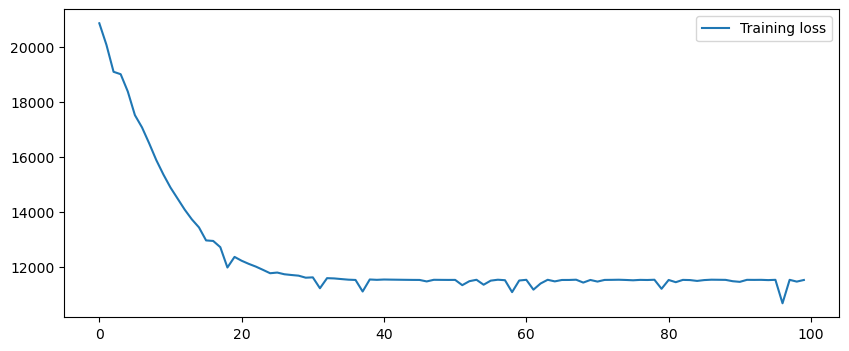

     prediction :  [97.78369140625, 97.78369140625, 97.78369140625, 97.78369140625, 97.78369140625, 97.78369140625, 97.78369140625, 97.78369140625, 97.78369140625]
     true       :  tensor([105.0000,  64.0000,  84.0000,  76.0000, 103.0000,  75.6750,  52.0000,
         85.0000,  84.0000])
     RMSLE SCORE :  0.08456771081960611


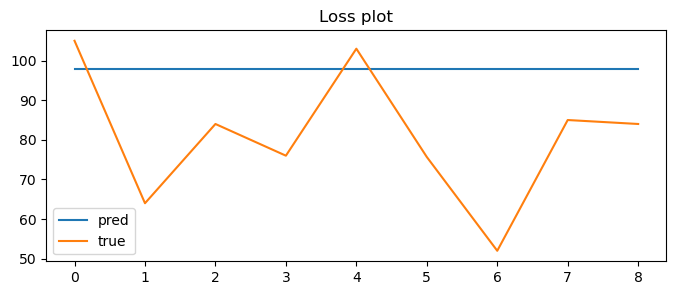

## GROCERY I_11
Epoch: 0000 train loss : 43488612.0000
Epoch: 0020 train loss : 43417472.0000
Epoch: 0040 train loss : 43102884.0000
Epoch: 0060 train loss : 43116064.0000
Epoch: 0080 train loss : 42824320.0000


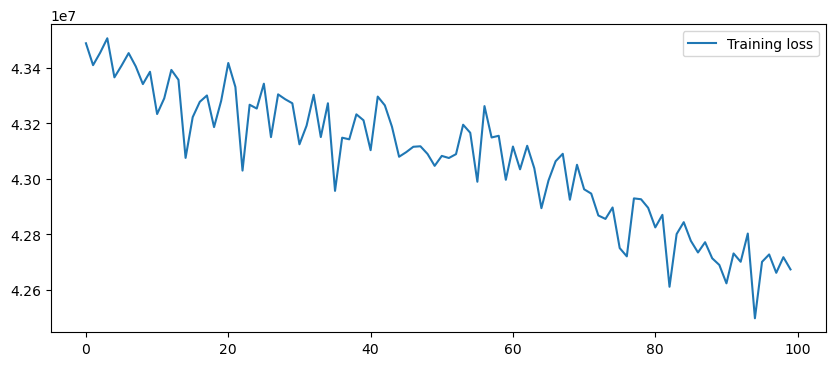

     prediction :  [62.43375778198242, 62.43375778198242, 62.43375778198242, 62.43375778198242, 62.43375778198242, 62.43375778198242, 62.43375778198242, 62.43375778198242, 62.43375778198242]
     true       :  tensor([5894.3462, 5437.9771, 5108.4512, 5653.6841, 6077.6172, 6036.0000,
        6477.6621, 5106.7139, 5806.6089])
     RMSLE SCORE :  20.268003788330404


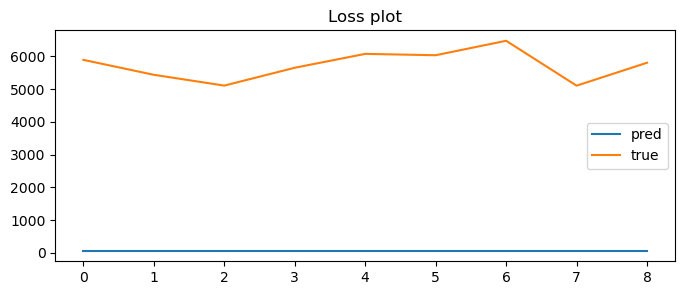

## GROCERY II_11
Epoch: 0000 train loss : 349.4195
Epoch: 0020 train loss : 154.8876
Epoch: 0040 train loss : 154.3367
Epoch: 0060 train loss : 154.4579
Epoch: 0080 train loss : 152.1873


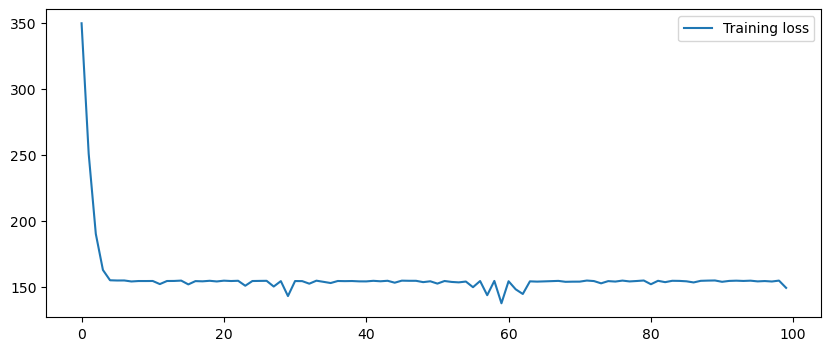

     prediction :  [15.84763240814209, 15.85192584991455, 15.850763320922852, 15.853626251220703, 15.857316970825195, 15.85793399810791, 15.855401039123535, 15.849369049072266, 15.849343299865723]
     true       :  tensor([ 8.,  7., 10., 22., 33., 12.,  6.,  6.,  5.])
     RMSLE SCORE :  0.4884965535913617


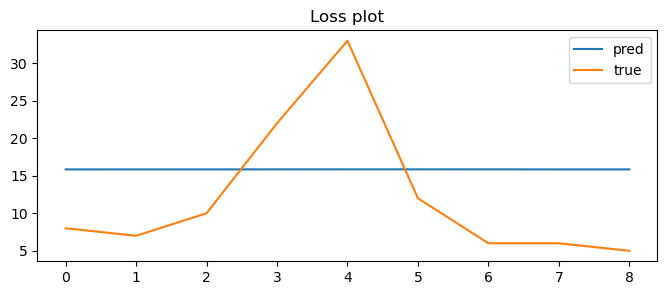

## HARDWARE_11
Epoch: 0000 train loss : 1.4070
Epoch: 0020 train loss : 1.2432
Epoch: 0040 train loss : 1.2363
Epoch: 0060 train loss : 1.2391
Epoch: 0080 train loss : 1.2396


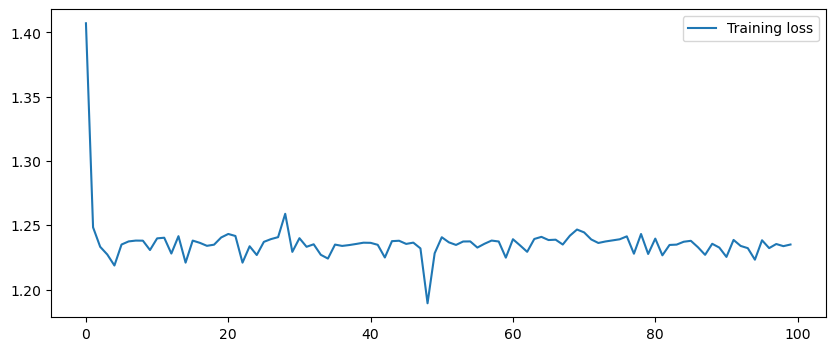

     prediction :  [0.7322311401367188, 0.7338026762008667, 0.7323157787322998, 0.731691837310791, 0.7301867008209229, 0.7325389385223389, 0.7298450469970703, 0.7297927141189575, 0.7294483184814453]
     true       :  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.27007668824605646


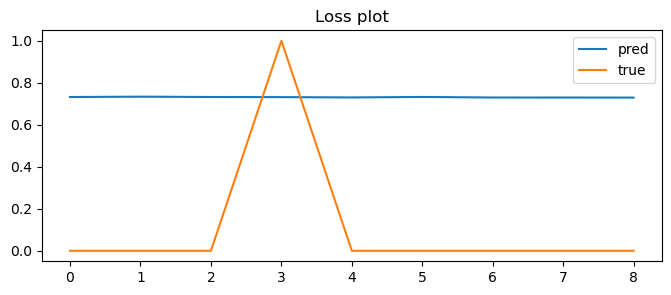

## HOME AND KITCHEN I_11
Epoch: 0000 train loss : 844.6702
Epoch: 0020 train loss : 524.9513
Epoch: 0040 train loss : 527.7528
Epoch: 0060 train loss : 525.9017
Epoch: 0080 train loss : 525.4051


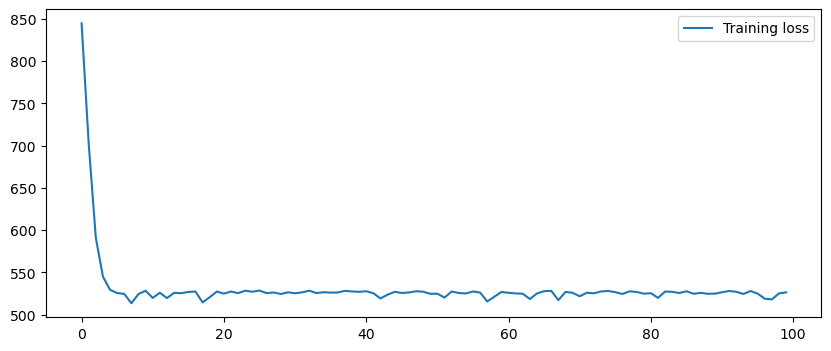

     prediction :  [19.643203735351562, 19.642789840698242, 19.64250373840332, 19.64211082458496, 19.643404006958008, 19.643587112426758, 19.64325714111328, 19.63688850402832, 19.643142700195312]
     true       :  tensor([24., 22., 20., 34., 55., 30., 12., 28., 27.])
     RMSLE SCORE :  0.21235470891433403


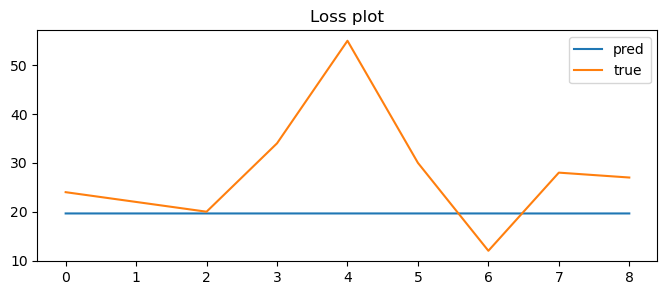

## HOME AND KITCHEN II_11
Epoch: 0000 train loss : 242.6859
Epoch: 0020 train loss : 141.1012
Epoch: 0040 train loss : 139.3214
Epoch: 0060 train loss : 141.1883
Epoch: 0080 train loss : 141.4913


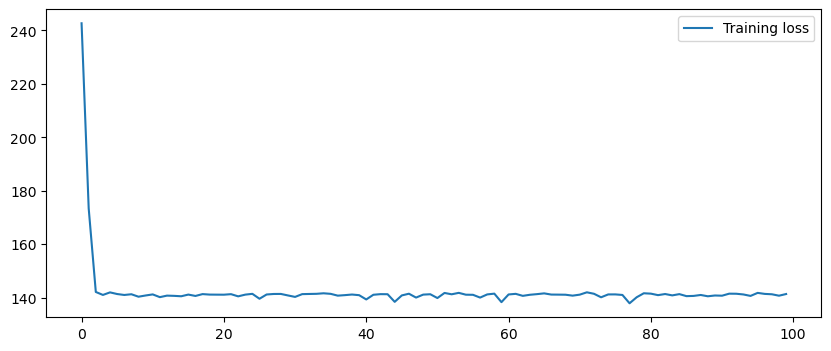

     prediction :  [11.148463249206543, 11.160916328430176, 11.157376289367676, 11.157322883605957, 11.15427017211914, 11.027837753295898, 11.155375480651855, 11.160774230957031, 11.121231079101562]
     true       :  tensor([16., 10., 10.,  9.,  2., 10., 15.,  6.,  4.])
     RMSLE SCORE :  0.36680246600675265


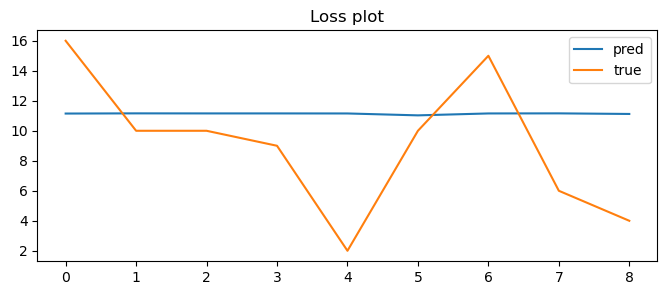

## HOME APPLIANCES_11
Epoch: 0000 train loss : 0.5794
Epoch: 0020 train loss : 0.5228
Epoch: 0040 train loss : 0.5214
Epoch: 0060 train loss : 0.5262
Epoch: 0080 train loss : 0.5262


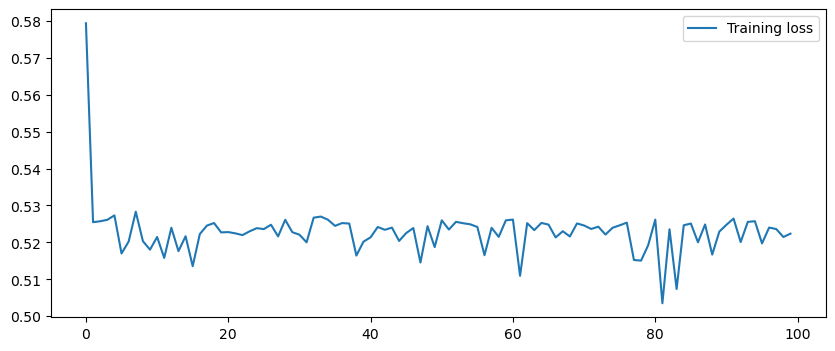

     prediction :  [0.39727580547332764, 0.39727580547332764, 0.39727580547332764, 0.39727580547332764, 0.39727580547332764, 0.39727580547332764, 0.39727580547332764, 0.39727580547332764, 0.39727580547332764]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.11190663290840923


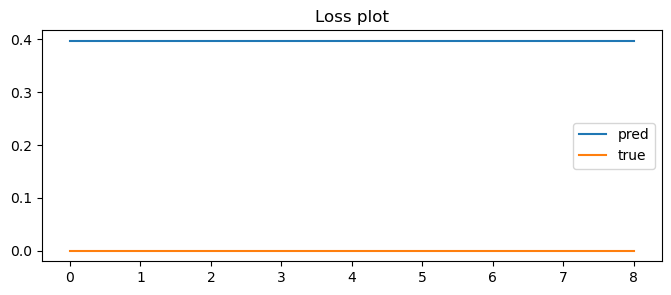

## HOME CARE_11
Epoch: 0000 train loss : 158940.0469
Epoch: 0020 train loss : 127940.2422
Epoch: 0040 train loss : 107506.5859
Epoch: 0060 train loss : 96434.7266
Epoch: 0080 train loss : 90447.2891


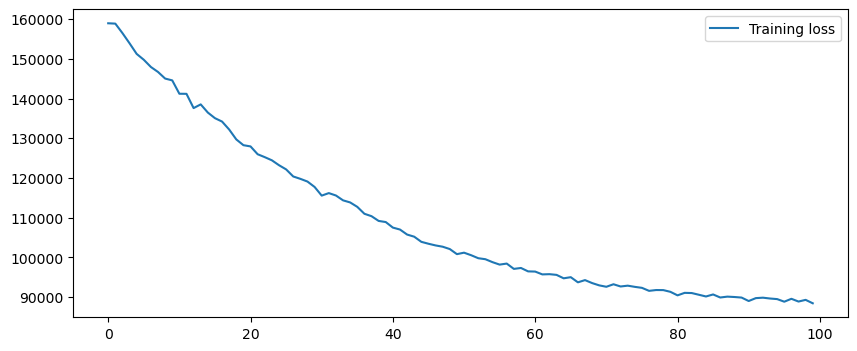

     prediction :  [185.7991485595703, 185.7991485595703, 185.7991485595703, 185.7991485595703, 185.7991485595703, 185.7991485595703, 185.7991485595703, 185.7991485595703, 185.7991485595703]
     true       :  tensor([467., 456., 348., 370., 418., 461., 456., 365., 414.])
     RMSLE SCORE :  0.6519985267268905


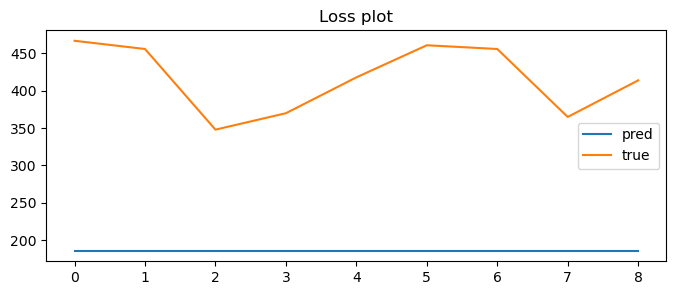

## LADIESWEAR_11
Epoch: 0000 train loss : 92.8662
Epoch: 0020 train loss : 69.9083
Epoch: 0040 train loss : 70.9013
Epoch: 0060 train loss : 70.9700
Epoch: 0080 train loss : 70.8905


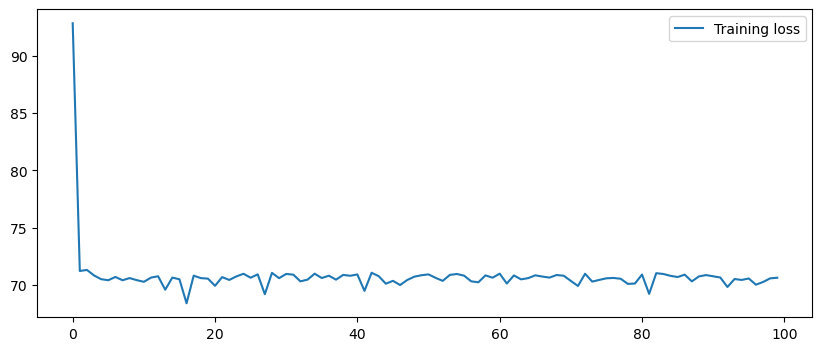

     prediction :  [6.325310707092285, 6.278777599334717, 6.314022064208984, 6.324746608734131, 6.326737880706787, 6.322697639465332, 6.3226704597473145, 6.30230188369751, 6.214815616607666]
     true       :  tensor([ 7., 11., 18., 23., 15., 15.,  9.,  2., 17.])
     RMSLE SCORE :  0.6136420546775914


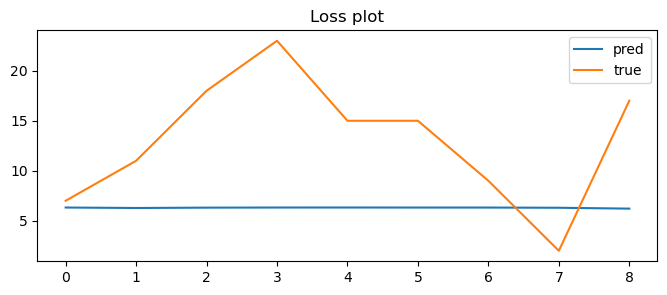

## LAWN AND GARDEN_11
Epoch: 0000 train loss : 3.5310
Epoch: 0020 train loss : 3.1006
Epoch: 0040 train loss : 3.1111
Epoch: 0060 train loss : 3.0932
Epoch: 0080 train loss : 3.0748


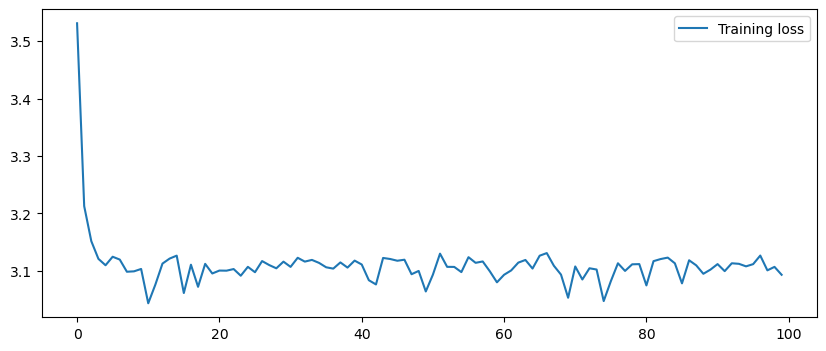

     prediction :  [1.3405628204345703, 1.3342474699020386, 1.3384333848953247, 1.3369592428207397, 1.3384766578674316, 1.3337936401367188, 1.3373099565505981, 1.3323034048080444, 1.3361473083496094]
     true       :  tensor([1., 1., 1., 0., 2., 0., 1., 0., 1.])
     RMSLE SCORE :  0.2599437032322349


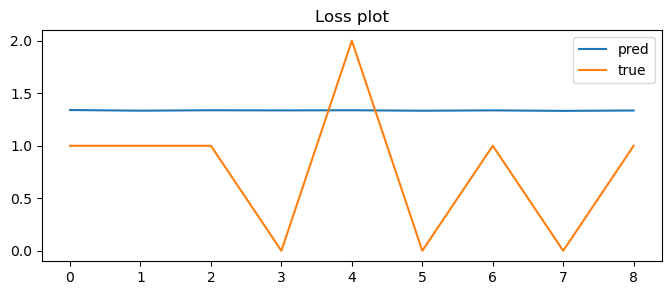

## LINGERIE_11
Epoch: 0000 train loss : 145.6649
Epoch: 0020 train loss : 52.8993
Epoch: 0040 train loss : 53.6571
Epoch: 0060 train loss : 54.0138
Epoch: 0080 train loss : 53.5936


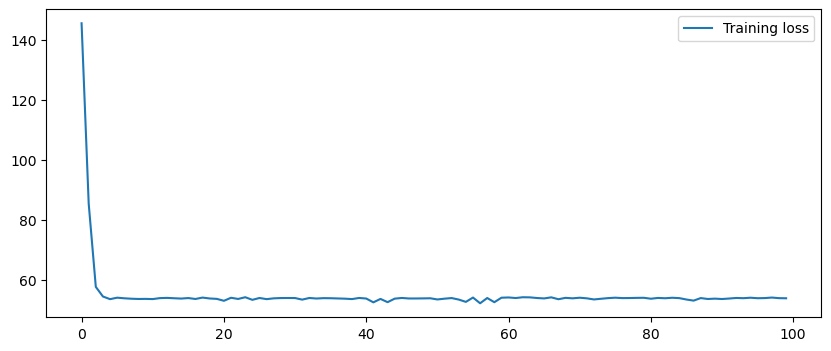

     prediction :  [11.459564208984375, 11.463518142700195, 11.463427543640137, 11.463553428649902, 11.453001976013184, 11.459624290466309, 11.468483924865723, 11.465906143188477, 11.461941719055176]
     true       :  tensor([ 7.,  7.,  7.,  3.,  5., 14.,  9.,  6.,  4.])
     RMSLE SCORE :  0.4071590811747797


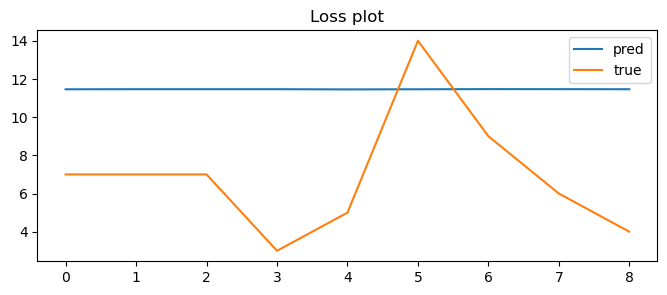

## LIQUOR,WINE,BEER_11
Epoch: 0000 train loss : 5901.4697
Epoch: 0020 train loss : 4187.3818
Epoch: 0040 train loss : 4191.6074
Epoch: 0060 train loss : 4195.3086
Epoch: 0080 train loss : 4196.6187


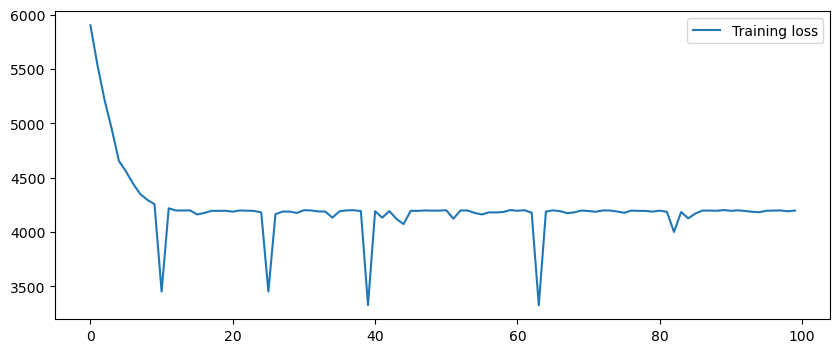

     prediction :  [42.88793182373047, 42.88766098022461, 42.88788604736328, 42.88780975341797, 42.887935638427734, 42.88793182373047, 42.887569427490234, 42.88700485229492, 42.88790512084961]
     true       :  tensor([17., 33., 22., 50., 55., 15.,  8., 35., 18.])
     RMSLE SCORE :  0.625294517431675


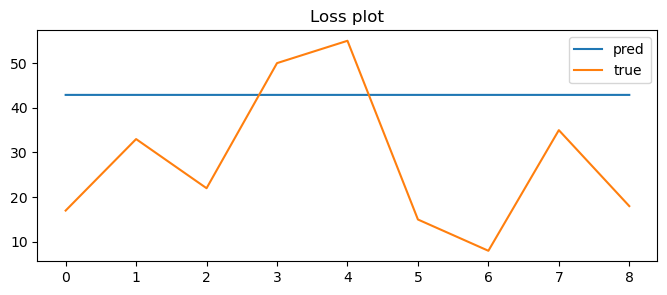

## MAGAZINES_11
Epoch: 0000 train loss : 4.1757
Epoch: 0020 train loss : 4.0276
Epoch: 0040 train loss : 4.0023
Epoch: 0060 train loss : 4.0139
Epoch: 0080 train loss : 4.0099


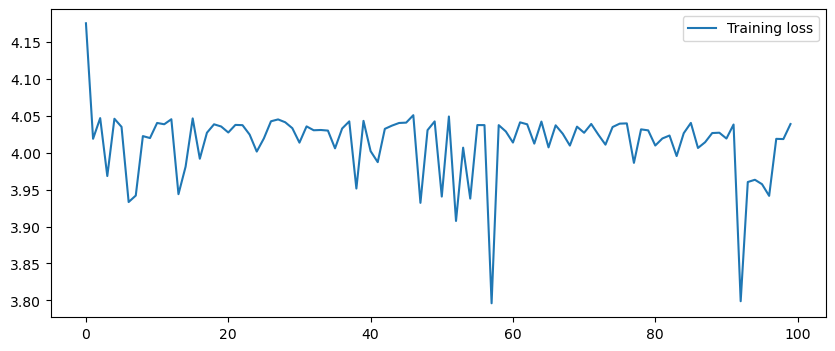

     prediction :  [0.9270213842391968, 0.9342373013496399, 0.9084948897361755, 0.9405144453048706, 0.9218626022338867, 0.9288743734359741, 0.9396682977676392, 0.9243769645690918, 0.9401443600654602]
     true       :  tensor([5., 0., 7., 3., 4., 6., 3., 6., 1.])
     RMSLE SCORE :  1.0078018182154422


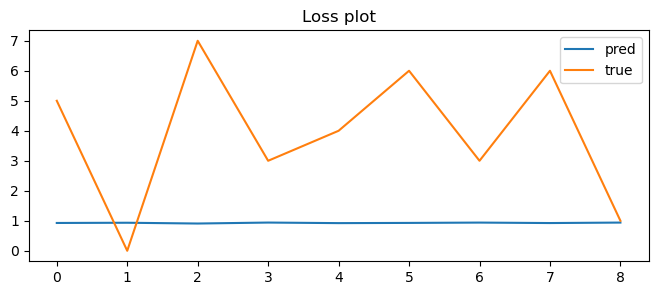

## MEATS_11
Epoch: 0000 train loss : 401343.2188
Epoch: 0020 train loss : 304575.2188
Epoch: 0040 train loss : 216993.2031
Epoch: 0060 train loss : 156054.4062
Epoch: 0080 train loss : 111946.0469


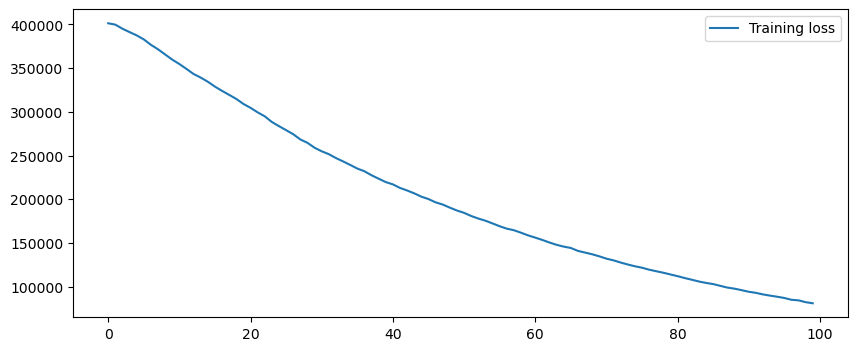

     prediction :  [375.1015625, 375.1015625, 375.1015625, 375.1015625, 375.1015625, 375.1015625, 375.1015625, 375.1015625, 375.1015625]
     true       :  tensor([574.2550, 524.0360, 782.1440, 550.5230, 534.6760, 646.9060, 554.9600,
        517.2340, 518.7980])
     RMSLE SCORE :  0.19527908750069797


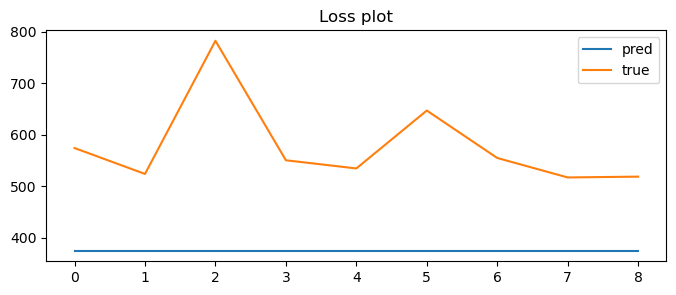

## PERSONAL CARE_11
Epoch: 0000 train loss : 161364.7656
Epoch: 0020 train loss : 114103.2344
Epoch: 0040 train loss : 76222.8984
Epoch: 0060 train loss : 51662.7773
Epoch: 0080 train loss : 37239.8320


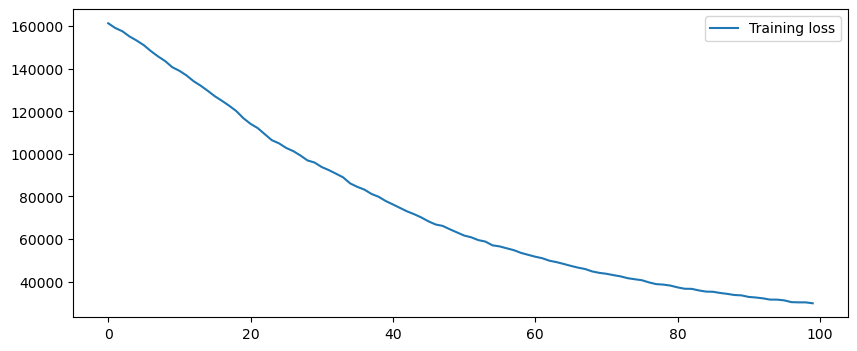

     prediction :  [286.9385681152344, 286.9385681152344, 286.9385681152344, 286.9385681152344, 286.9385681152344, 286.9385681152344, 286.9385681152344, 286.9385681152344, 286.9385681152344]
     true       :  tensor([392., 346., 294., 289., 379., 460., 404., 317., 364.])
     RMSLE SCORE :  0.06812929029519264


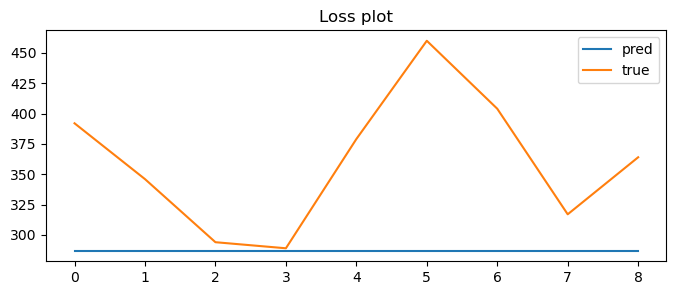

## PET SUPPLIES_11
Epoch: 0000 train loss : 1.2946
Epoch: 0020 train loss : 1.2315
Epoch: 0040 train loss : 1.2318
Epoch: 0060 train loss : 1.2321
Epoch: 0080 train loss : 1.2274


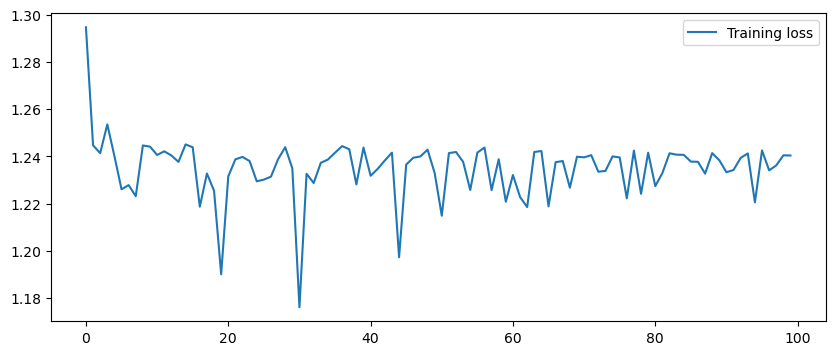

     prediction :  [0.6270243525505066, 0.6296882033348083, 0.6331404447555542, 0.6321079134941101, 0.6325279474258423, 0.6319186091423035, 0.6326896548271179, 0.6296094655990601, 0.6313033103942871]
     true       :  tensor([2., 2., 2., 2., 1., 2., 3., 1., 2.])
     RMSLE SCORE :  0.3461188738918324


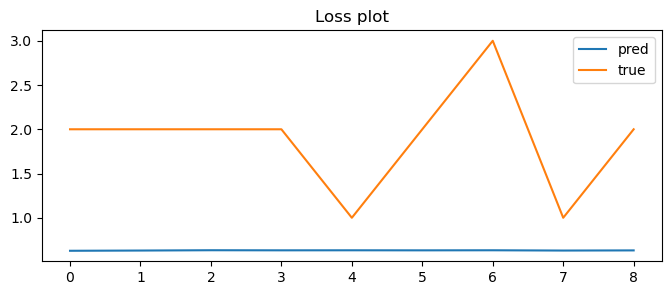

## PLAYERS AND ELECTRONICS_11
Epoch: 0000 train loss : 62.8127
Epoch: 0020 train loss : 45.6966
Epoch: 0040 train loss : 46.8701
Epoch: 0060 train loss : 46.9345
Epoch: 0080 train loss : 46.7289


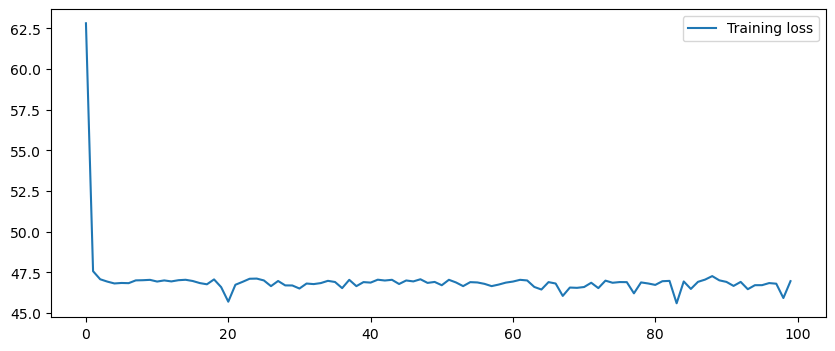

     prediction :  [5.492366313934326, 5.491154670715332, 5.488050937652588, 5.482967376708984, 5.480857849121094, 5.482916355133057, 5.488036155700684, 5.484648704528809, 5.465953826904297]
     true       :  tensor([19., 13.,  9.,  8.,  9., 13., 10.,  4.,  8.])
     RMSLE SCORE :  0.37643571014543054


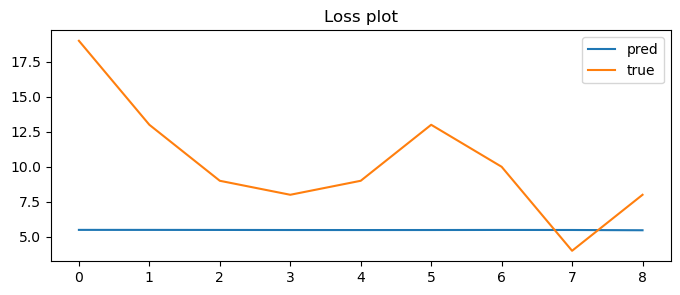

## POULTRY_11
Epoch: 0000 train loss : 339177.1562
Epoch: 0020 train loss : 263776.3125
Epoch: 0040 train loss : 207611.1406
Epoch: 0060 train loss : 162252.7188
Epoch: 0080 train loss : 128569.3281


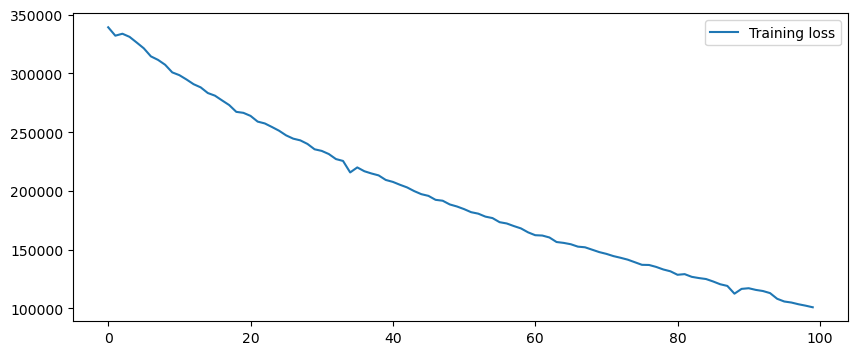

     prediction :  [317.7630920410156, 317.7630920410156, 317.7630920410156, 317.7630920410156, 317.7630920410156, 317.7630920410156, 317.7630920410156, 317.7630920410156, 317.7630920410156]
     true       :  tensor([288.9960, 383.1680, 175.3600, 466.3160, 253.4230, 512.9790, 205.8110,
        278.5800, 468.1720])
     RMSLE SCORE :  0.1303707280564568


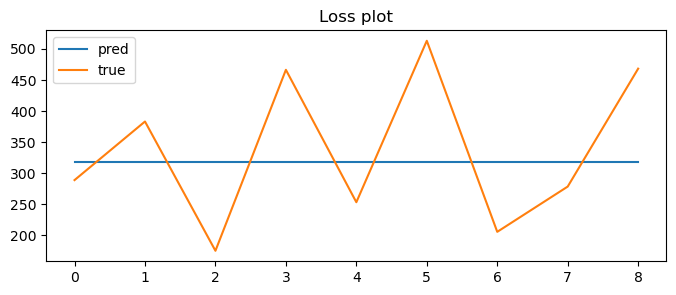

## PREPARED FOODS_11
Epoch: 0000 train loss : 2795.5056
Epoch: 0020 train loss : 869.9031
Epoch: 0040 train loss : 868.5374
Epoch: 0060 train loss : 866.1398
Epoch: 0080 train loss : 864.4822


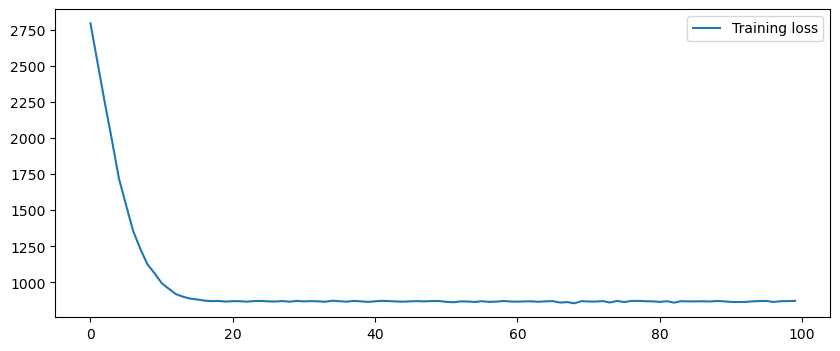

     prediction :  [45.49282455444336, 45.49285888671875, 45.49287796020508, 45.49287796020508, 45.492881774902344, 45.492881774902344, 45.492881774902344, 45.49287796020508, 45.49288558959961]
     true       :  tensor([80.9240, 45.7240, 46.7560, 51.9760, 64.3700, 62.3930, 49.3030, 55.3010,
        54.2040])
     RMSLE SCORE :  0.06925433152705641


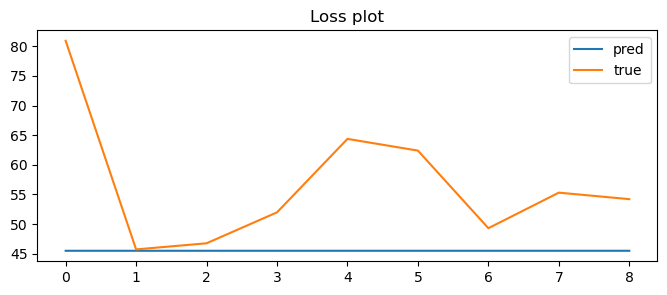

## PRODUCE_11
Epoch: 0000 train loss : 847556.5000
Epoch: 0020 train loss : 775994.8125
Epoch: 0040 train loss : 718190.6875
Epoch: 0060 train loss : 674092.4375
Epoch: 0080 train loss : 635871.3125


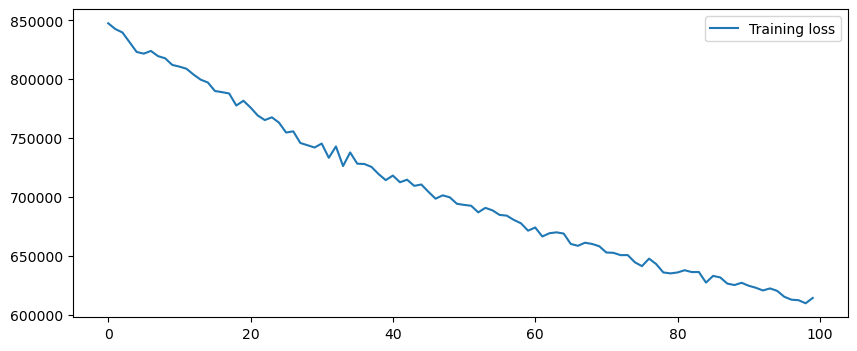

     prediction :  [124.8256607055664, 124.8256607055664, 124.8256607055664, 124.8256607055664, 124.8256607055664, 124.8256607055664, 124.8256607055664, 124.8256607055664, 124.8256607055664]
     true       :  tensor([2074.8879,  928.1260,  879.2350,  979.4270,  990.5330, 1298.2070,
        1068.0750, 1746.5430, 1111.9200])
     RMSLE SCORE :  5.0910285825994155


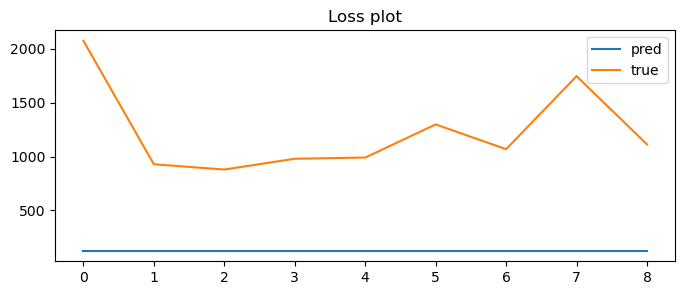

## SCHOOL AND OFFICE SUPPLIES_11
Epoch: 0000 train loss : 101.1896
Epoch: 0020 train loss : 96.8389
Epoch: 0040 train loss : 96.8088
Epoch: 0060 train loss : 96.8676
Epoch: 0080 train loss : 96.8034


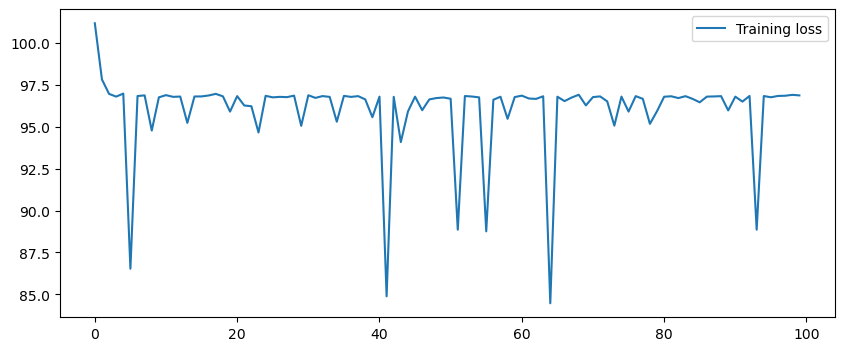

     prediction :  [3.1465072631835938, 3.132638931274414, 3.155191421508789, 3.0990614891052246, 3.1559267044067383, 3.1556835174560547, 3.153329849243164, 3.1602892875671387, 3.13521671295166]
     true       :  tensor([ 5., 16.,  1., 15., 17., 14., 20.,  6., 25.])
     RMSLE SCORE :  1.622184922691624


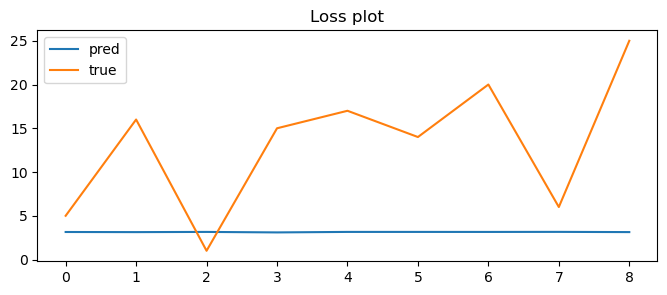

## SEAFOOD_11
Epoch: 0000 train loss : 70.2624
Epoch: 0020 train loss : 36.4078
Epoch: 0040 train loss : 36.4174
Epoch: 0060 train loss : 36.1316
Epoch: 0080 train loss : 36.1077


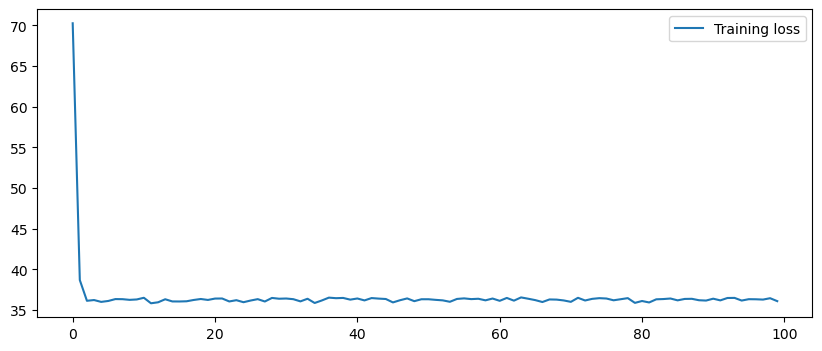

     prediction :  [7.440651893615723, 7.432924270629883, 7.43145751953125, 7.424332618713379, 7.431306838989258, 7.4398932456970215, 7.432933330535889, 7.431343078613281, 7.4273600578308105]
     true       :  tensor([ 7.,  7.,  3.,  6., 16.,  7.,  6.,  5.,  9.])
     RMSLE SCORE :  0.14114601299552787


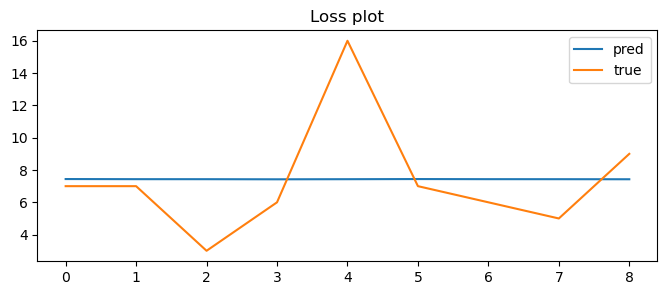

## AUTOMOTIVE_12
Epoch: 0000 train loss : 18.0433
Epoch: 0020 train loss : 10.2797
Epoch: 0040 train loss : 10.2538
Epoch: 0060 train loss : 10.2406
Epoch: 0080 train loss : 10.2319


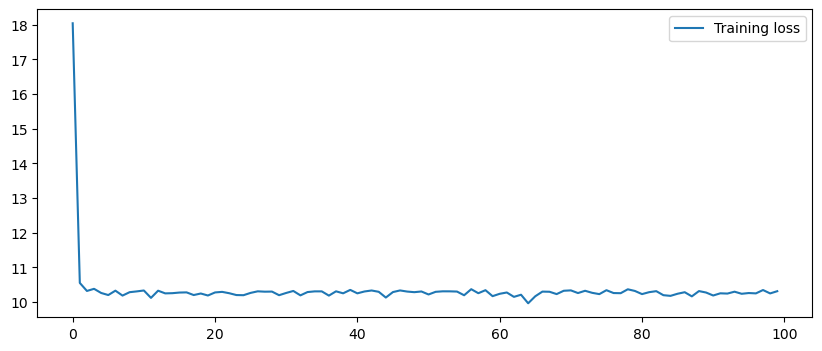

     prediction :  [4.378921985626221, 4.389682769775391, 4.374621868133545, 4.385143756866455, 4.385326862335205, 4.378893852233887, 4.385210990905762, 4.37888765335083, 4.374402046203613]
     true       :  tensor([8., 3., 6., 6., 4., 6., 4., 3., 3.])
     RMSLE SCORE :  0.08309369611297021


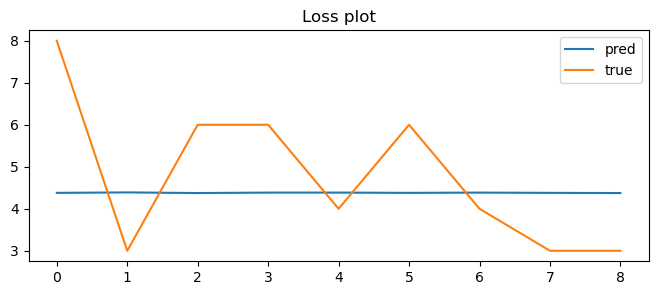

## BABY CARE_12
Epoch: 0000 train loss : 0.1108
Epoch: 0020 train loss : 0.1114
Epoch: 0040 train loss : 0.1113
Epoch: 0060 train loss : 0.1113
Epoch: 0080 train loss : 0.1114


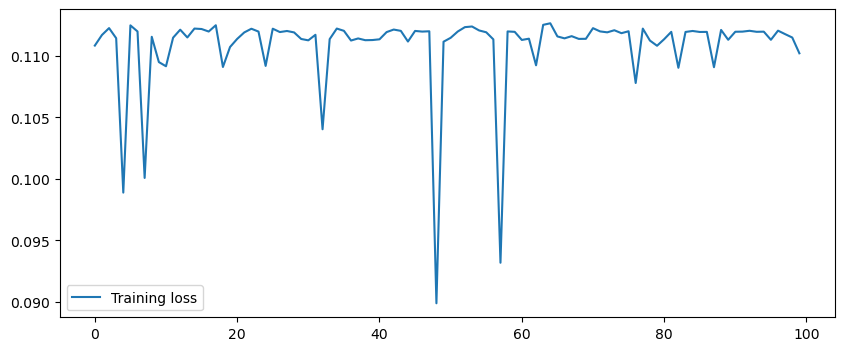

     prediction :  [0.06102143973112106, 0.05909104645252228, 0.05800570175051689, 0.05982344225049019, 0.058345772325992584, 0.05998152866959572, 0.05842210724949837, 0.05768832936882973, 0.06114490330219269]
     true       :  tensor([0., 0., 1., 0., 1., 0., 0., 2., 0.])
     RMSLE SCORE :  0.2130780615070598


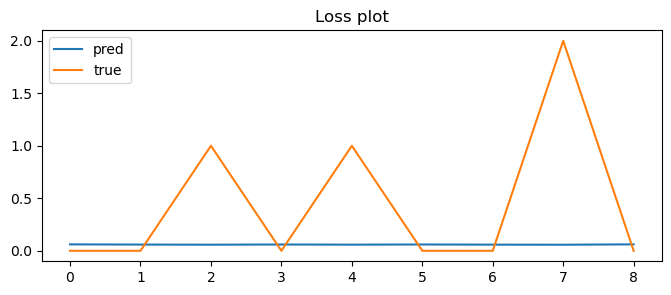

## BEAUTY_12
Epoch: 0000 train loss : 1.4127
Epoch: 0020 train loss : 1.1761
Epoch: 0040 train loss : 1.1920
Epoch: 0060 train loss : 1.1928
Epoch: 0080 train loss : 1.1884


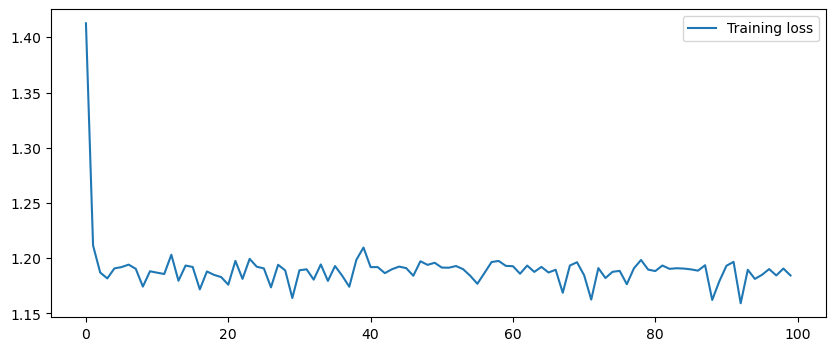

     prediction :  [0.9457098245620728, 0.9467895030975342, 0.9406832456588745, 0.9497009515762329, 0.9462646245956421, 0.941866397857666, 0.9494311809539795, 0.9464219808578491, 0.9446984529495239]
     true       :  tensor([2., 1., 0., 1., 1., 0., 1., 2., 0.])
     RMSLE SCORE :  0.18886996853264


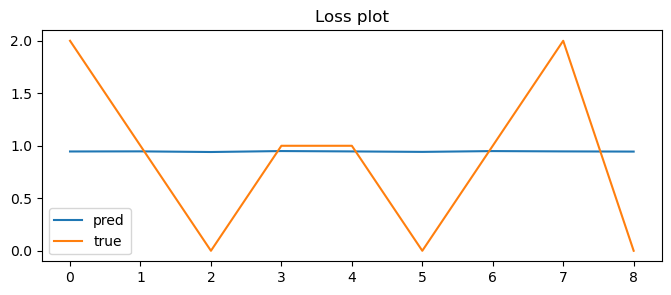

## BEVERAGES_12
Epoch: 0000 train loss : 1728377.6250
Epoch: 0020 train loss : 1660432.0000
Epoch: 0040 train loss : 1598555.7500
Epoch: 0060 train loss : 1522859.7500
Epoch: 0080 train loss : 1458686.1250


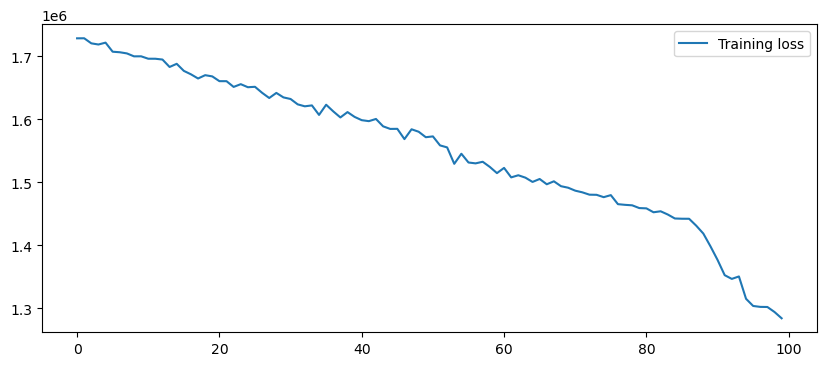

     prediction :  [199.9757537841797, 199.9757537841797, 199.9757537841797, 199.9757537841797, 199.9757537841797, 199.9757537841797, 199.9757537841797, 199.9757537841797, 199.9757537841797]
     true       :  tensor([1338., 1392., 1171., 1192., 1761., 1496., 1538., 1277., 1461.])
     RMSLE SCORE :  3.7639513982282153


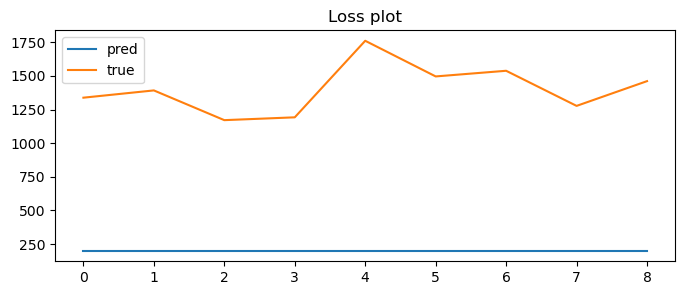

## BOOKS_12
Epoch: 0000 train loss : 0.0014
Epoch: 0020 train loss : 0.0000
Epoch: 0040 train loss : 0.0000
Epoch: 0060 train loss : 0.0000
Epoch: 0080 train loss : 0.0000


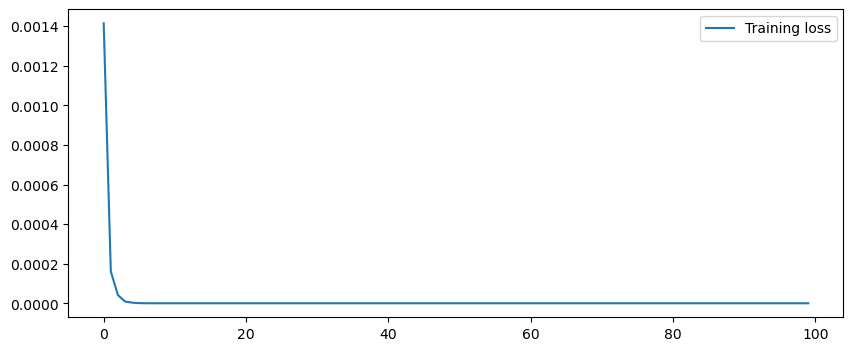

     prediction :  [3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09, 3.725290298461914e-09]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  1.3877787756115668e-17


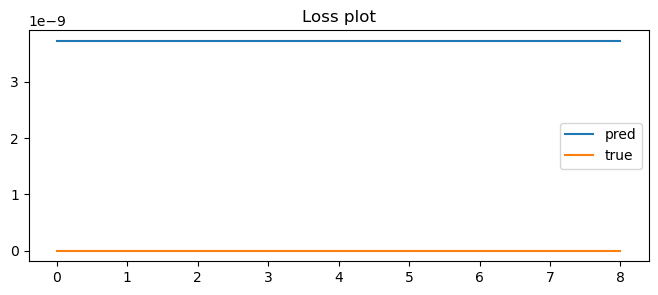

## BREAD/BAKERY_12
Epoch: 0000 train loss : 40878.8359
Epoch: 0020 train loss : 16344.4717
Epoch: 0040 train loss : 8497.2461
Epoch: 0060 train loss : 6330.0664
Epoch: 0080 train loss : 6022.9692


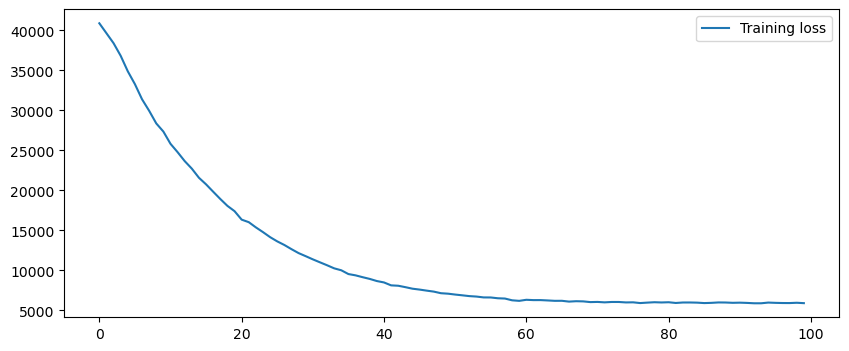

     prediction :  [186.8339385986328, 186.8339385986328, 186.8339385986328, 186.8339385986328, 186.8339385986328, 186.8339385986328, 186.8339385986328, 186.8339385986328, 186.8339385986328]
     true       :  tensor([139., 151., 145., 116., 163., 153., 177., 144., 145.])
     RMSLE SCORE :  0.06777601210035289


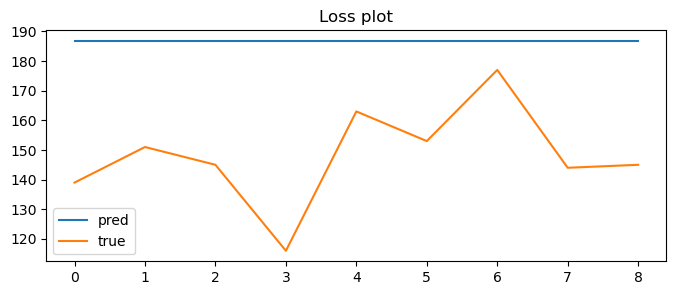

## CELEBRATION_12
Epoch: 0000 train loss : 54.4399
Epoch: 0020 train loss : 41.5803
Epoch: 0040 train loss : 41.4304
Epoch: 0060 train loss : 41.5965
Epoch: 0080 train loss : 41.6530


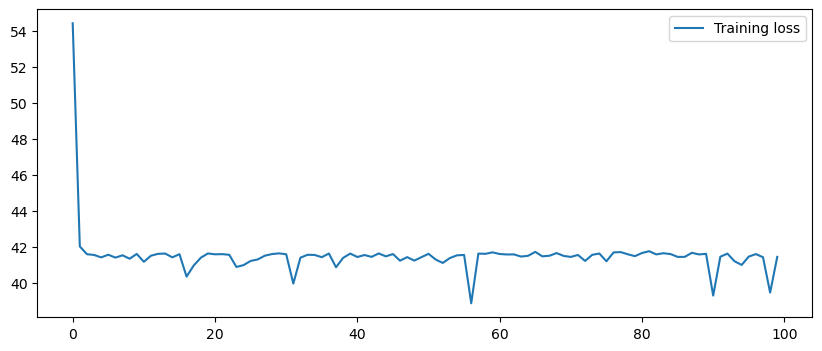

     prediction :  [4.925511837005615, 4.91658878326416, 4.904404163360596, 4.904006004333496, 4.890728950500488, 4.916038513183594, 4.908778190612793, 4.904122352600098, 4.908135414123535]
     true       :  tensor([14.,  8.,  8.,  4., 14., 10.,  8.,  8.,  5.])
     RMSLE SCORE :  0.31746757585753405


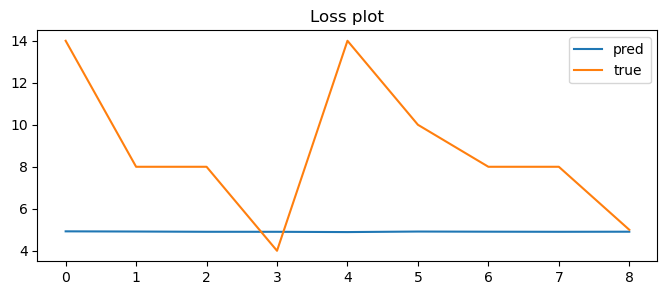

## CLEANING_12
Epoch: 0000 train loss : 623305.5000
Epoch: 0020 train loss : 560960.7500
Epoch: 0040 train loss : 490418.3750
Epoch: 0060 train loss : 435686.0625
Epoch: 0080 train loss : 386930.7812


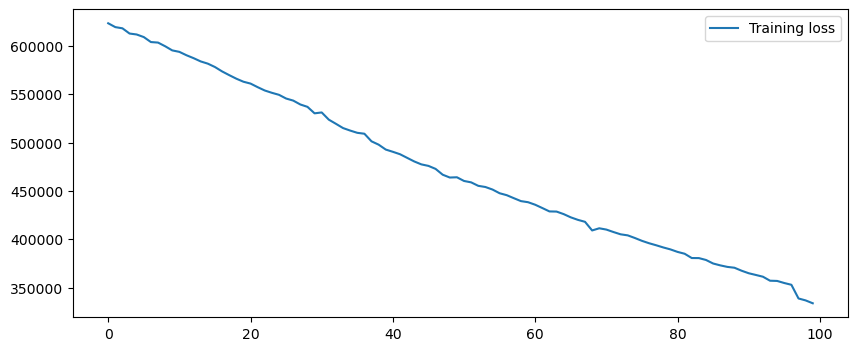

     prediction :  [222.22242736816406, 222.22242736816406, 222.22242736816406, 222.22242736816406, 222.22242736816406, 222.22242736816406, 222.22242736816406, 222.22242736816406, 222.22242736816406]
     true       :  tensor([755., 612., 516., 639., 687., 878., 818., 836., 731.])
     RMSLE SCORE :  1.3684441657357325


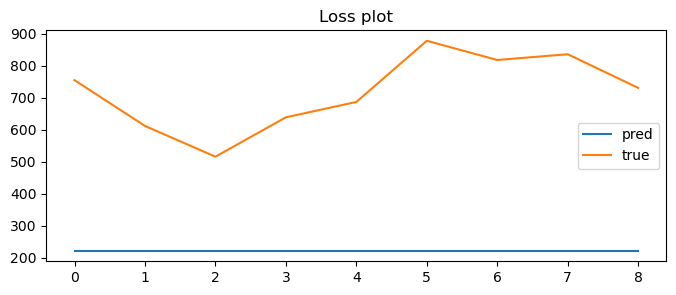

## DAIRY_12
Epoch: 0000 train loss : 111062.0000
Epoch: 0020 train loss : 63574.5859
Epoch: 0040 train loss : 38030.7109
Epoch: 0060 train loss : 26993.5508
Epoch: 0080 train loss : 22918.1484


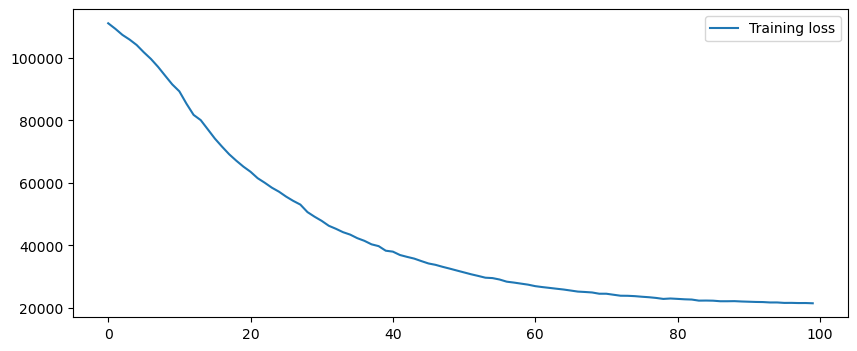

     prediction :  [279.99017333984375, 279.99017333984375, 279.99017333984375, 279.99017333984375, 279.99017333984375, 279.99017333984375, 279.99017333984375, 279.99017333984375, 279.99017333984375]
     true       :  tensor([328., 400., 356., 299., 347., 332., 358., 343., 357.])
     RMSLE SCORE :  0.04968677980858698


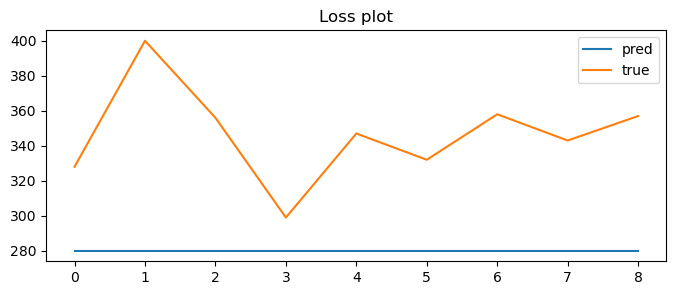

## DELI_12
Epoch: 0000 train loss : 39082.2148
Epoch: 0020 train loss : 14340.7617
Epoch: 0040 train loss : 7063.5498
Epoch: 0060 train loss : 5579.2368
Epoch: 0080 train loss : 5409.2666


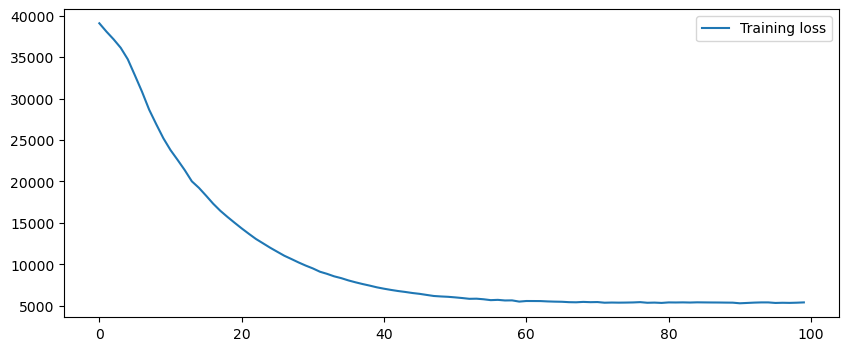

     prediction :  [183.91433715820312, 183.91433715820312, 183.91433715820312, 183.91433715820312, 183.91433715820312, 183.91433715820312, 183.91433715820312, 183.91433715820312, 183.91433715820312]
     true       :  tensor([181., 187., 201., 219., 223., 195., 258., 240., 224.])
     RMSLE SCORE :  0.03343072937341729


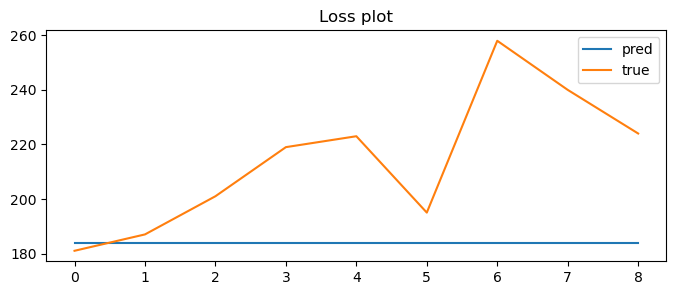

## EGGS_12
Epoch: 0000 train loss : 8713.8887
Epoch: 0020 train loss : 3201.0977
Epoch: 0040 train loss : 3153.8152
Epoch: 0060 train loss : 3128.4919
Epoch: 0080 train loss : 3149.6753


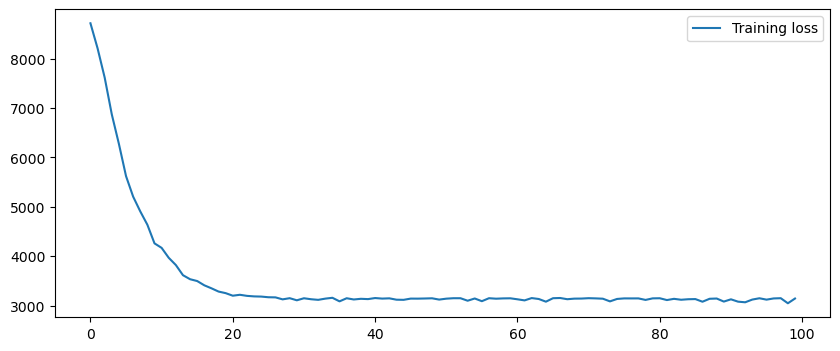

     prediction :  [76.20560455322266, 76.20560455322266, 76.20556640625, 76.20559692382812, 76.2055892944336, 76.20549011230469, 76.20560455322266, 76.20560455322266, 76.20559692382812]
     true       :  tensor([168.,  35.,  54.,  80.,  22., 112.,  53., 291.,  30.])
     RMSLE SCORE :  0.6283124545291814


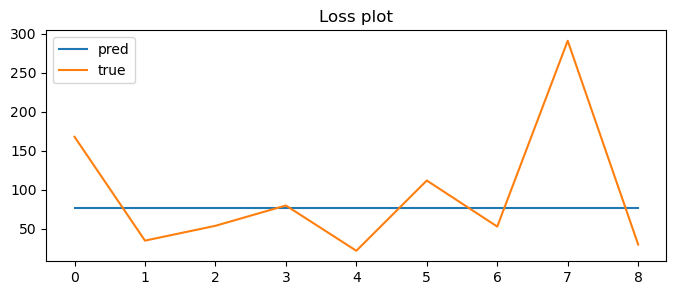

## FROZEN FOODS_12
Epoch: 0000 train loss : 4826.9561
Epoch: 0020 train loss : 2944.0137
Epoch: 0040 train loss : 2946.4470
Epoch: 0060 train loss : 2948.9473
Epoch: 0080 train loss : 2952.1028


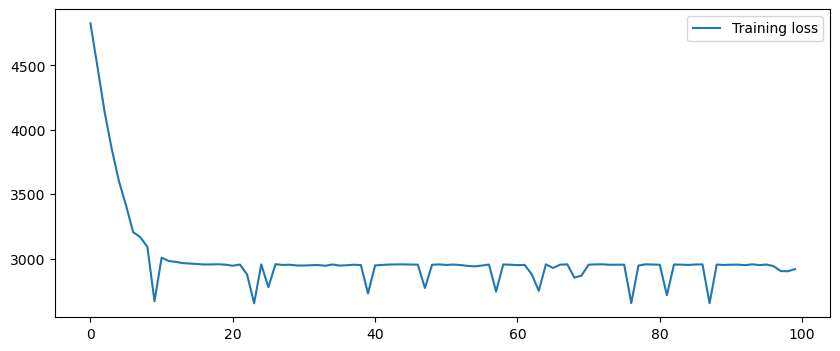

     prediction :  [45.01512908935547, 45.01522445678711, 45.01518630981445, 45.01531982421875, 45.01533126831055, 45.01537322998047, 45.01532745361328, 45.01527404785156, 45.01500701904297]
     true       :  tensor([26., 24., 33., 34., 66., 35., 29., 19., 37.])
     RMSLE SCORE :  0.21535748832484702


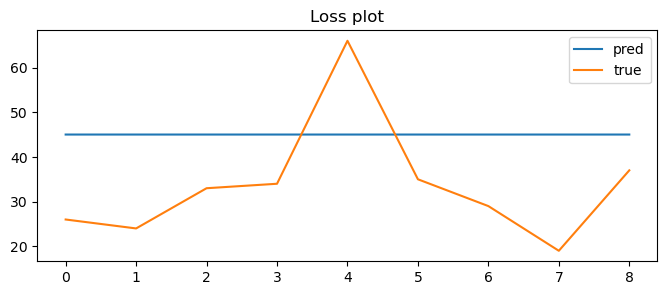

## GROCERY I_12
Epoch: 0000 train loss : 6339818.5000
Epoch: 0020 train loss : 6228567.0000
Epoch: 0040 train loss : 6096915.5000
Epoch: 0060 train loss : 5983672.5000
Epoch: 0080 train loss : 5793283.0000


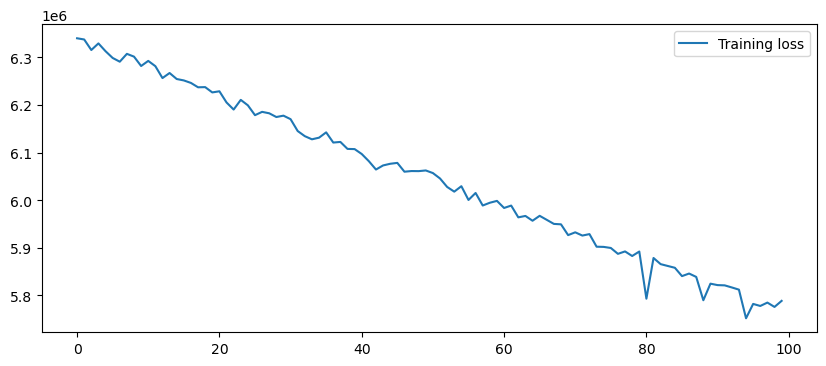

     prediction :  [111.36839294433594, 111.36839294433594, 111.36839294433594, 111.36839294433594, 111.36839294433594, 111.36839294433594, 111.36839294433594, 111.36839294433594, 111.36839294433594]
     true       :  tensor([2399., 2287., 2319., 2229., 2553., 2509., 2714., 2309., 2519.])
     RMSLE SCORE :  9.434503678247628


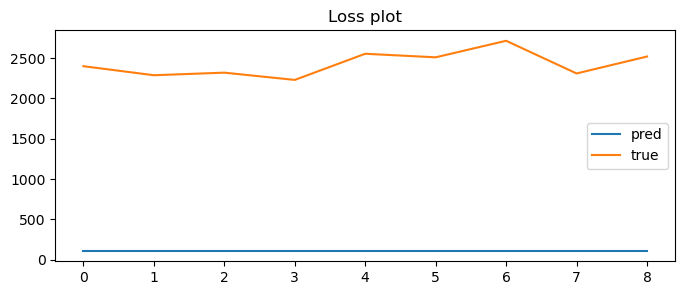

## GROCERY II_12
Epoch: 0000 train loss : 64.3858
Epoch: 0020 train loss : 42.1963
Epoch: 0040 train loss : 42.2845
Epoch: 0060 train loss : 42.3898
Epoch: 0080 train loss : 41.9187


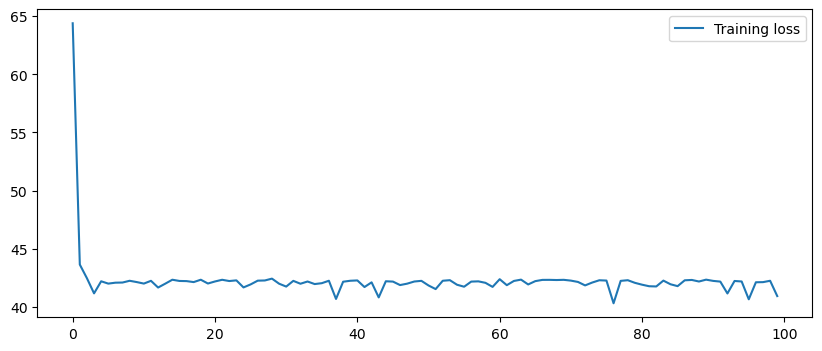

     prediction :  [6.027109622955322, 6.0247721672058105, 6.008737087249756, 6.013967037200928, 6.014010906219482, 6.036165237426758, 6.002334117889404, 6.0245890617370605, 6.014095783233643]
     true       :  tensor([ 5.,  1.,  2.,  2., 14.,  0.,  5.,  2., 11.])
     RMSLE SCORE :  0.9405688910173247


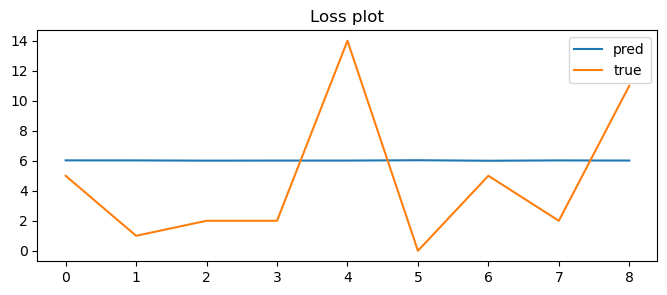

## HARDWARE_12
Epoch: 0000 train loss : 2.0353
Epoch: 0020 train loss : 1.6839
Epoch: 0040 train loss : 1.6788
Epoch: 0060 train loss : 1.6761
Epoch: 0080 train loss : 1.6546


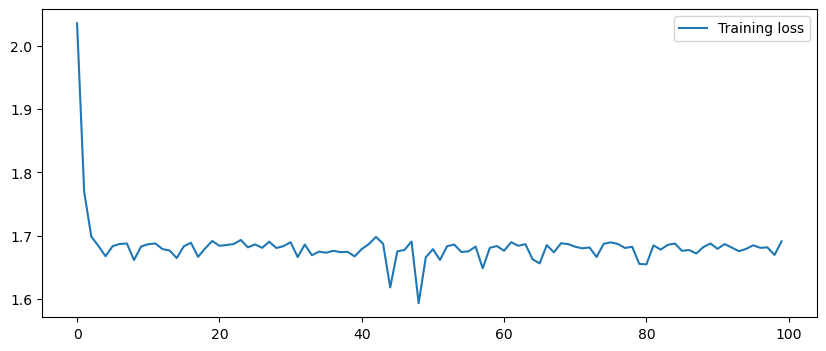

     prediction :  [0.9830559492111206, 0.9833042621612549, 0.9809285998344421, 0.9860555529594421, 0.9849081039428711, 0.9854059815406799, 0.9827443957328796, 0.9846450686454773, 0.9879774451255798]
     true       :  tensor([0., 2., 2., 1., 0., 1., 2., 0., 0.])
     RMSLE SCORE :  0.266204423717194


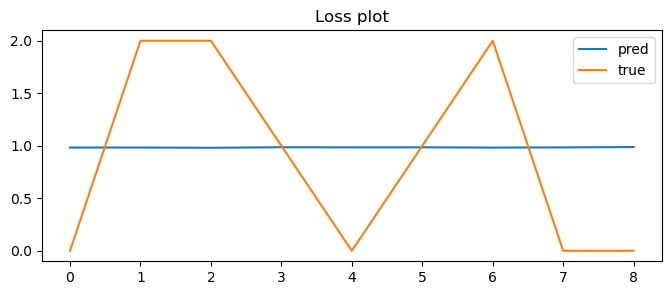

## HOME AND KITCHEN I_12
Epoch: 0000 train loss : 208.3519
Epoch: 0020 train loss : 149.6094
Epoch: 0040 train loss : 149.6204
Epoch: 0060 train loss : 149.8777
Epoch: 0080 train loss : 149.9566


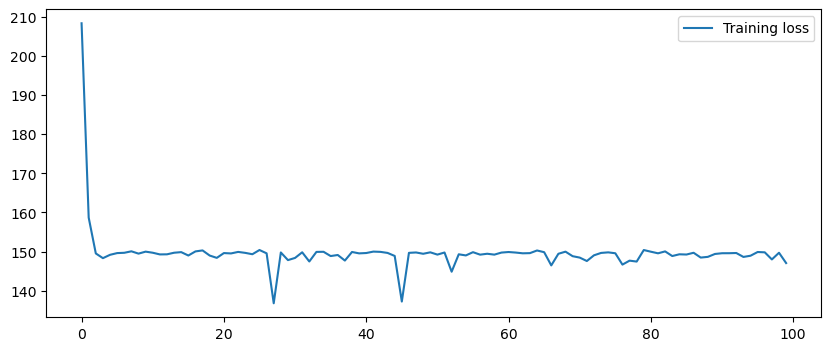

     prediction :  [8.875723838806152, 8.871647834777832, 8.859416961669922, 8.85727310180664, 8.874642372131348, 8.875128746032715, 8.870150566101074, 8.860749244689941, 8.874825477600098]
     true       :  tensor([11.,  4.,  4., 18., 20., 10.,  5., 19., 25.])
     RMSLE SCORE :  0.40648907446140514


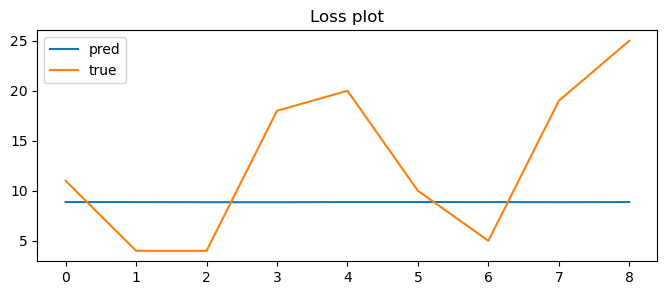

## HOME AND KITCHEN II_12
Epoch: 0000 train loss : 81.5635
Epoch: 0020 train loss : 55.2439
Epoch: 0040 train loss : 55.2710
Epoch: 0060 train loss : 55.1067
Epoch: 0080 train loss : 55.3177


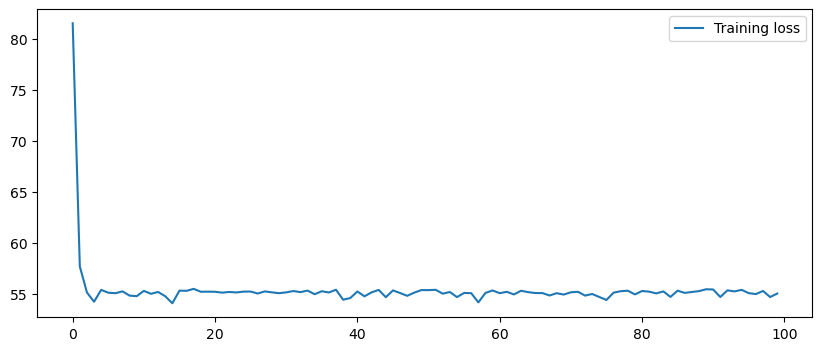

     prediction :  [6.426571369171143, 6.474396228790283, 6.419924736022949, 6.464003562927246, 6.446986198425293, 6.468518257141113, 6.4687347412109375, 6.453609466552734, 6.427837371826172]
     true       :  tensor([17.,  7., 14., 11., 15., 15., 12.,  7., 10.])
     RMSLE SCORE :  0.34900038387076937


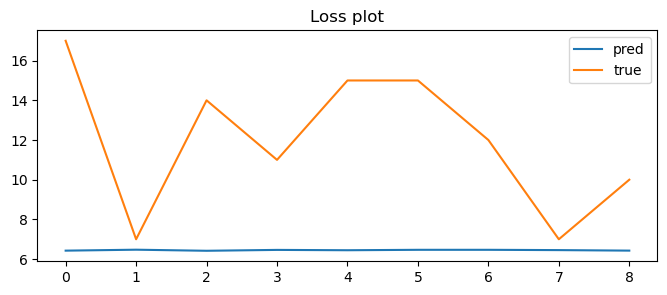

## HOME APPLIANCES_12
Epoch: 0000 train loss : 0.3053
Epoch: 0020 train loss : 0.2933
Epoch: 0040 train loss : 0.2916
Epoch: 0060 train loss : 0.2932
Epoch: 0080 train loss : 0.2930


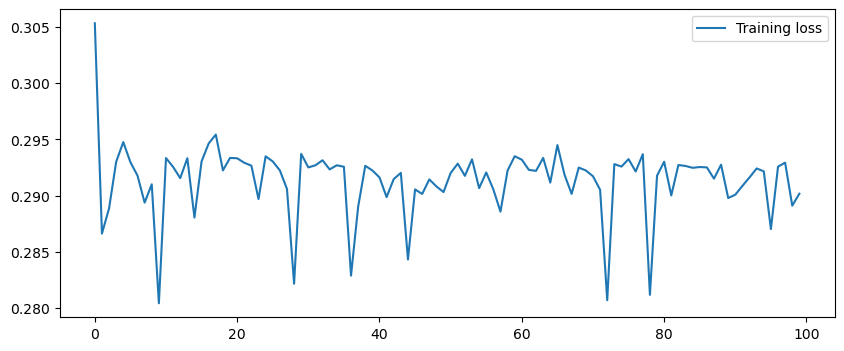

     prediction :  [0.23100580275058746, 0.2309800088405609, 0.2309800088405609, 0.2309800088405609, 0.2309800088405609, 0.2309800088405609, 0.2309800088405609, 0.2309800088405609, 0.2309800088405609]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.04318621620121754


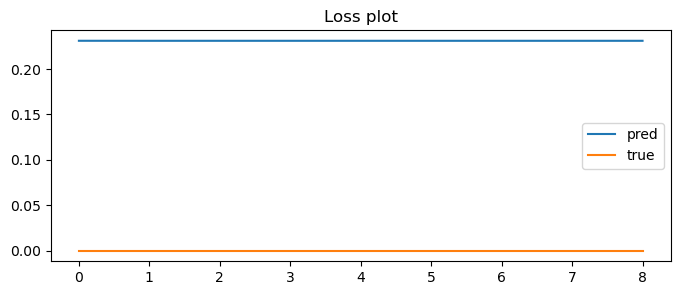

## HOME CARE_12
Epoch: 0000 train loss : 18601.3848
Epoch: 0020 train loss : 10641.5781
Epoch: 0040 train loss : 10032.6143
Epoch: 0060 train loss : 10083.4023
Epoch: 0080 train loss : 10051.6172


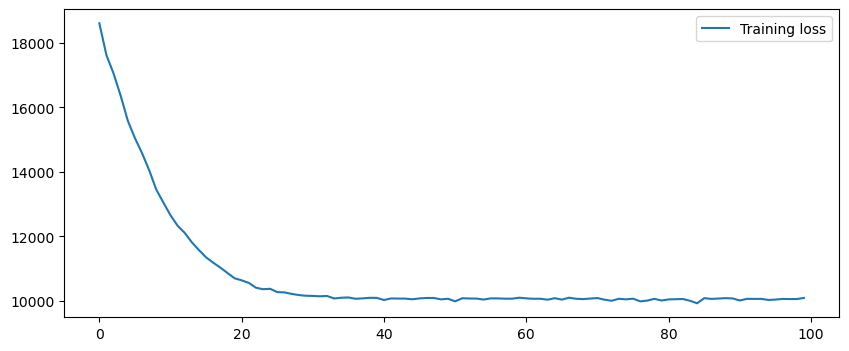

     prediction :  [92.30009460449219, 92.30009460449219, 92.30009460449219, 92.30009460449219, 92.30009460449219, 92.30009460449219, 92.30009460449219, 92.30009460449219, 92.30009460449219]
     true       :  tensor([169., 184., 160., 155., 169., 175., 183., 184., 200.])
     RMSLE SCORE :  0.40800436523613154


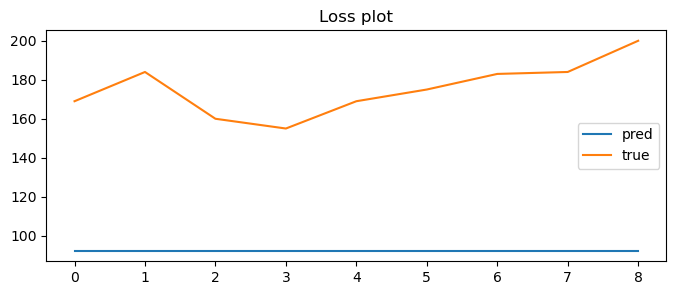

## LADIESWEAR_12
Epoch: 0000 train loss : 9.5444
Epoch: 0020 train loss : 8.9647
Epoch: 0040 train loss : 9.0080
Epoch: 0060 train loss : 8.9889
Epoch: 0080 train loss : 8.8895


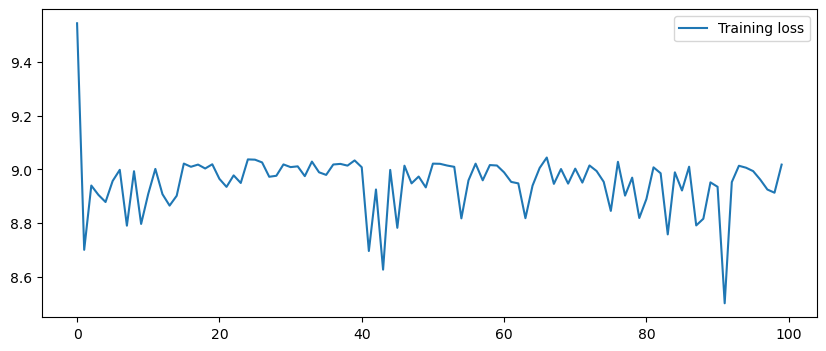

     prediction :  [0.9165295362472534, 0.9165295362472534, 0.9165295362472534, 0.9165295362472534, 0.9165295362472534, 0.9165295362472534, 0.9165295362472534, 0.9165295362472534, 0.9165295362472534]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.42317108873238135


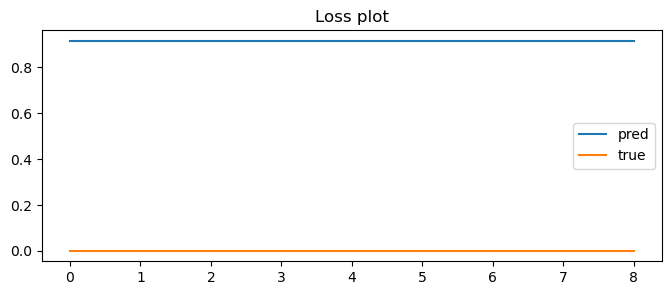

## LAWN AND GARDEN_12
Epoch: 0000 train loss : 0.0540
Epoch: 0020 train loss : 0.0495
Epoch: 0040 train loss : 0.0492
Epoch: 0060 train loss : 0.0491
Epoch: 0080 train loss : 0.0492


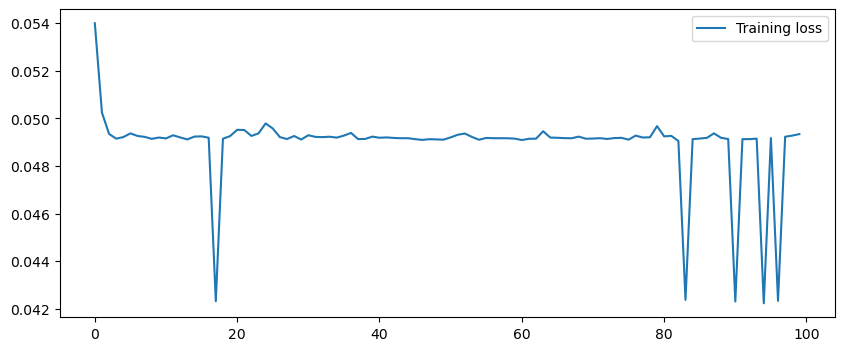

     prediction :  [0.02364988625049591, 0.02364988625049591, 0.02364988625049591, 0.02364988625049591, 0.02364988625049591, 0.02364988625049591, 0.02364988625049591, 0.02364988625049591, 0.02364988625049591]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.0005463700643079655


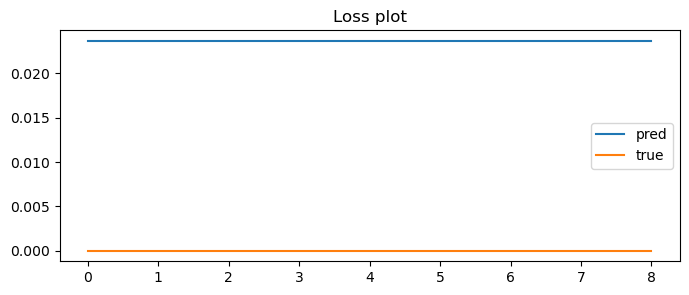

## LINGERIE_12
Epoch: 0000 train loss : 61.0745
Epoch: 0020 train loss : 31.9760
Epoch: 0040 train loss : 32.2710
Epoch: 0060 train loss : 32.6525
Epoch: 0080 train loss : 32.5884


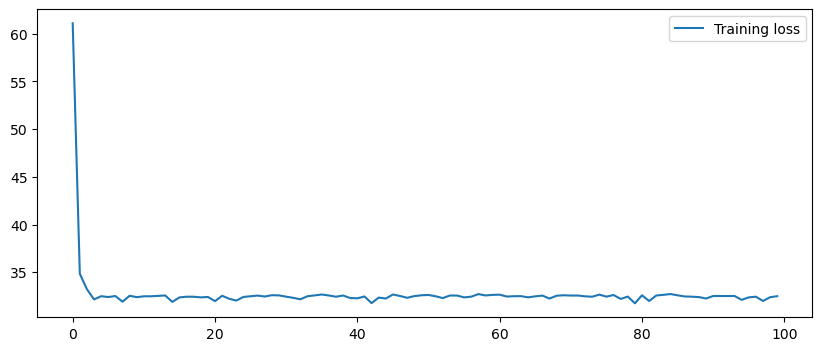

     prediction :  [6.95277738571167, 6.956584930419922, 6.964531898498535, 6.932418346405029, 6.947050094604492, 6.924458026885986, 6.950221061706543, 6.950257778167725, 6.9322075843811035]
     true       :  tensor([ 8., 18.,  1.,  4.,  0.,  5.,  5.,  1.,  5.])
     RMSLE SCORE :  1.036786468346019


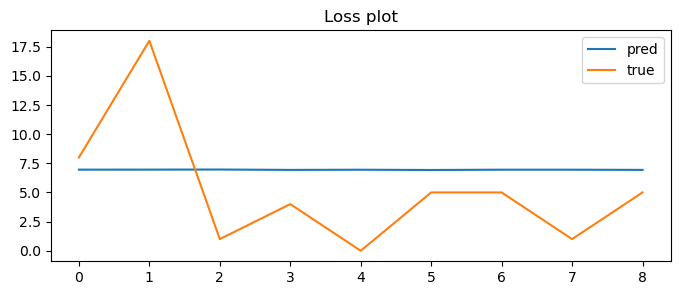

## LIQUOR,WINE,BEER_12
Epoch: 0000 train loss : 3160.9519
Epoch: 0020 train loss : 1846.6525
Epoch: 0040 train loss : 1846.3712
Epoch: 0060 train loss : 1806.7644
Epoch: 0080 train loss : 1850.9980


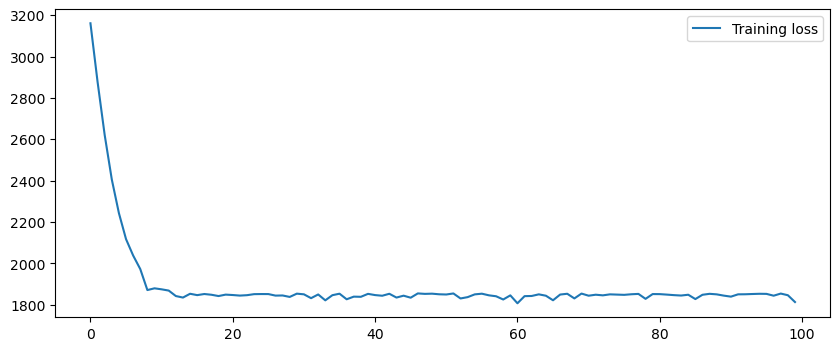

     prediction :  [37.861724853515625, 37.86262512207031, 37.8625373840332, 37.862552642822266, 37.8626594543457, 37.86265182495117, 37.862247467041016, 37.862144470214844, 37.86256790161133]
     true       :  tensor([37., 26., 27., 52., 51., 18., 16., 29., 17.])
     RMSLE SCORE :  0.25297027755201396


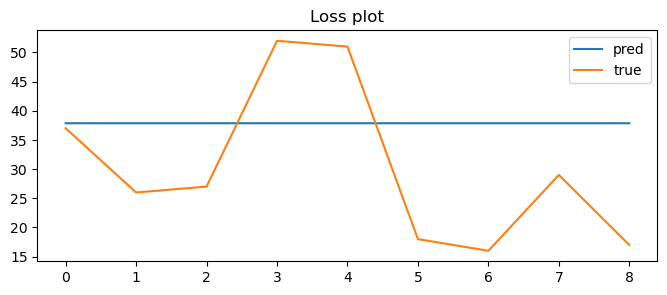

## MAGAZINES_12
Epoch: 0000 train loss : 2.0127
Epoch: 0020 train loss : 1.9464
Epoch: 0040 train loss : 1.9441
Epoch: 0060 train loss : 1.9501
Epoch: 0080 train loss : 1.8491


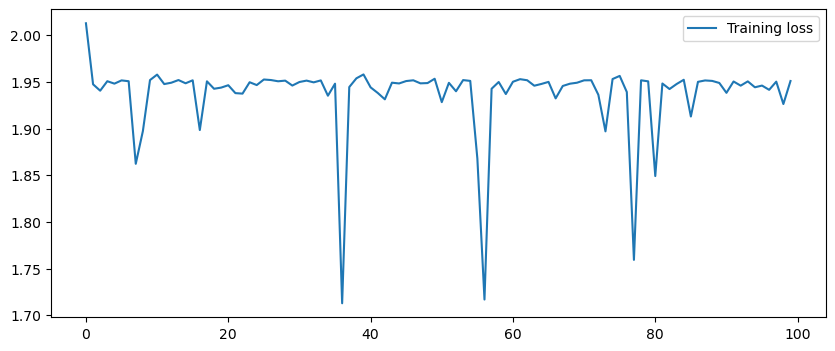

     prediction :  [0.5460730791091919, 0.5415509939193726, 0.5394141674041748, 0.5385202169418335, 0.5381463170051575, 0.5436461567878723, 0.5454491972923279, 0.5411844253540039, 0.5331948399543762]
     true       :  tensor([1., 1., 1., 1., 3., 2., 1., 0., 2.])
     RMSLE SCORE :  0.25893950160360446


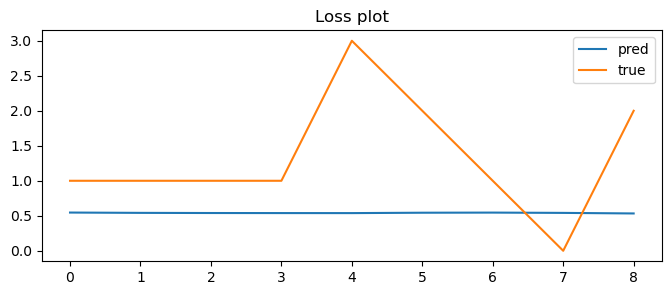

## MEATS_12
Epoch: 0000 train loss : 19545.4434
Epoch: 0020 train loss : 4686.1675
Epoch: 0040 train loss : 2045.3182
Epoch: 0060 train loss : 1810.6771
Epoch: 0080 train loss : 1819.9042


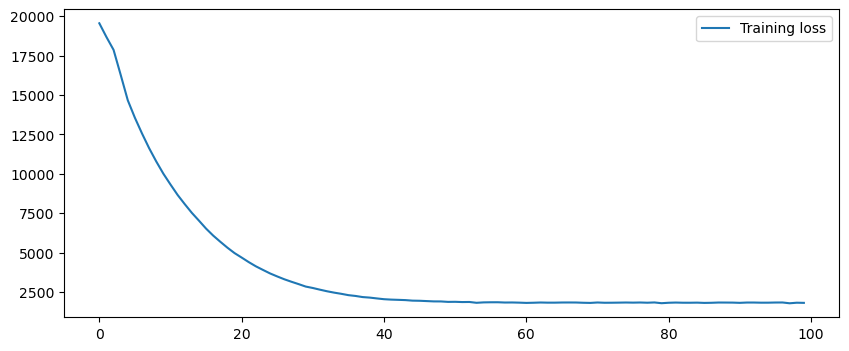

     prediction :  [134.2237548828125, 134.2237548828125, 134.2237548828125, 134.2237548828125, 134.2237548828125, 134.2237548828125, 134.2237548828125, 134.2237548828125, 134.2237548828125]
     true       :  tensor([165.1830, 128.5570, 176.9240, 114.6230, 115.3430, 132.0960, 154.9680,
        211.6830, 139.4800])
     RMSLE SCORE :  0.043772230841398134


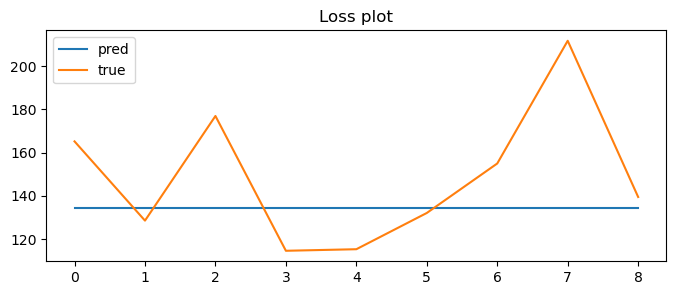

## PERSONAL CARE_12
Epoch: 0000 train loss : 26549.8418
Epoch: 0020 train loss : 9679.6211
Epoch: 0040 train loss : 5830.4507
Epoch: 0060 train loss : 5472.2539
Epoch: 0080 train loss : 5456.7812


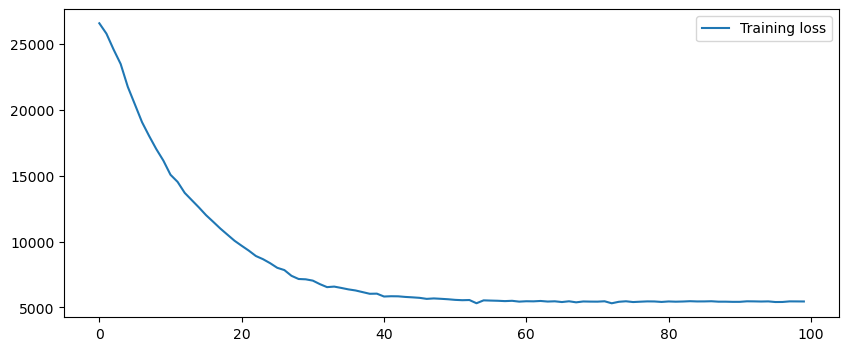

     prediction :  [147.00083923339844, 147.00083923339844, 147.00083923339844, 147.00083923339844, 147.00083923339844, 147.00083923339844, 147.00083923339844, 147.00083923339844, 147.00083923339844]
     true       :  tensor([174., 155., 131., 117., 207., 188., 161., 156., 183.])
     RMSLE SCORE :  0.0366582254129974


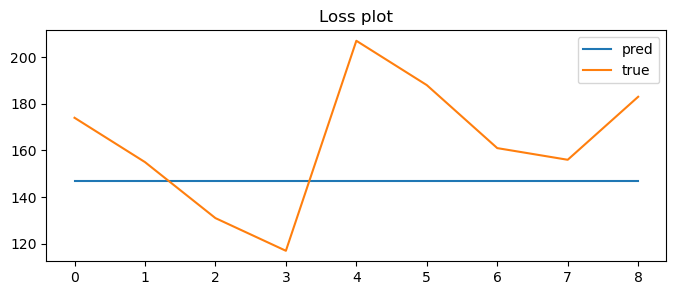

## PET SUPPLIES_12
Epoch: 0000 train loss : 0.4419
Epoch: 0020 train loss : 0.3933
Epoch: 0040 train loss : 0.3862
Epoch: 0060 train loss : 0.3951
Epoch: 0080 train loss : 0.3873


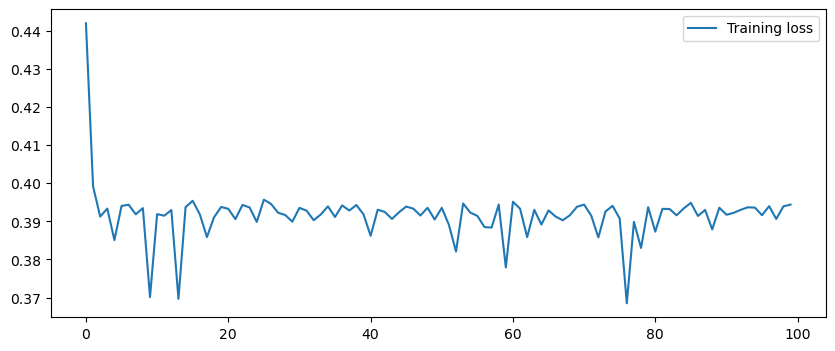

     prediction :  [0.2856546640396118, 0.2838204801082611, 0.28308188915252686, 0.2825227379798889, 0.2822408676147461, 0.2820179760456085, 0.2812187671661377, 0.282998263835907, 0.2841949164867401]
     true       :  tensor([0., 0., 0., 0., 0., 1., 1., 0., 2.])
     RMSLE SCORE :  0.16550253609918666


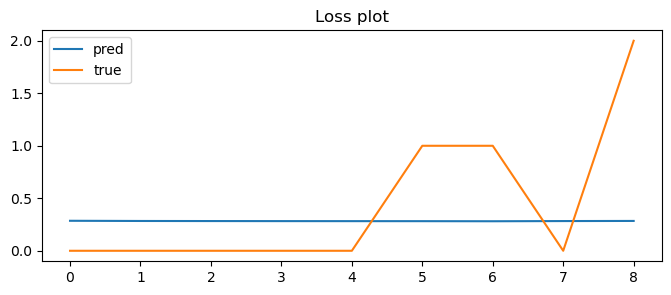

## PLAYERS AND ELECTRONICS_12
Epoch: 0000 train loss : 13.1747
Epoch: 0020 train loss : 10.9712
Epoch: 0040 train loss : 10.8601
Epoch: 0060 train loss : 10.9569
Epoch: 0080 train loss : 10.8868


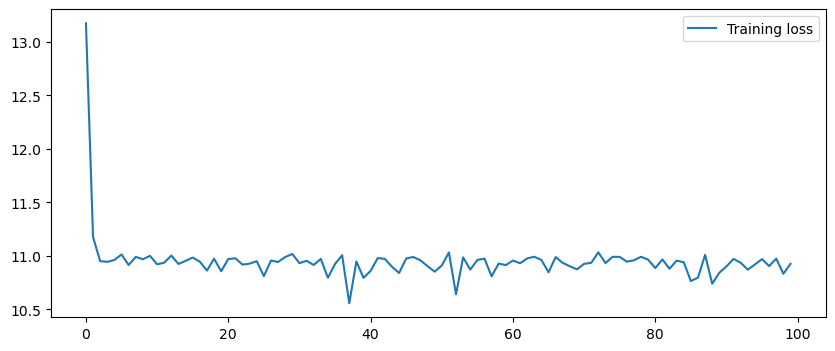

     prediction :  [2.202821731567383, 2.2127809524536133, 2.214177131652832, 2.2142140865325928, 2.2216949462890625, 2.227872371673584, 2.240377426147461, 2.2369229793548584, 2.229321241378784]
     true       :  tensor([2., 2., 2., 3., 4., 8., 6., 4., 1.])
     RMSLE SCORE :  0.2575626824628554


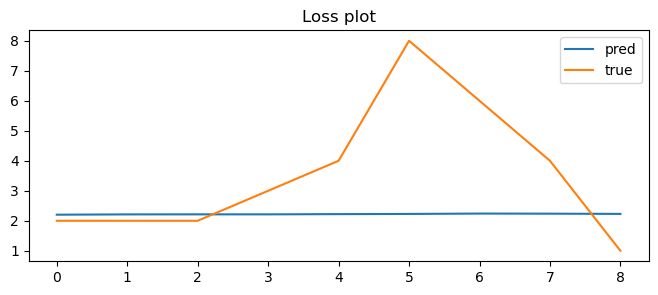

## POULTRY_12
Epoch: 0000 train loss : 46157.7031
Epoch: 0020 train loss : 22124.1699
Epoch: 0040 train loss : 15071.0820
Epoch: 0060 train loss : 13585.1064
Epoch: 0080 train loss : 13360.4248


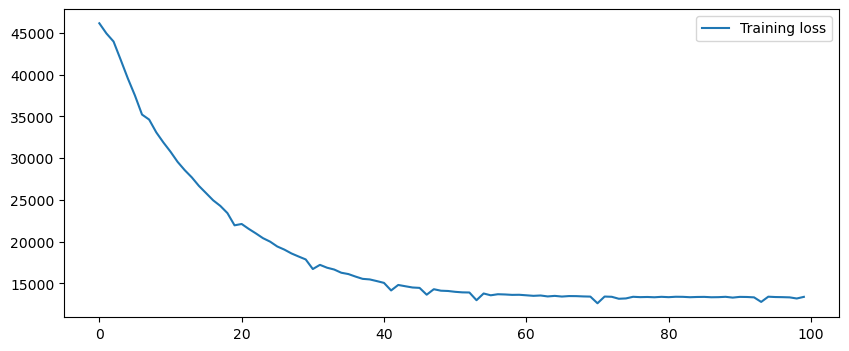

     prediction :  [180.8294677734375, 180.8294677734375, 180.8294677734375, 180.8294677734375, 180.8294677734375, 180.8294677734375, 180.8294677734375, 180.8294677734375, 180.8294677734375]
     true       :  tensor([114.6470,  93.9140, 194.8140, 136.9970, 160.9590, 125.7860, 128.4980,
        133.1770,  65.8770])
     RMSLE SCORE :  0.22893005122934973


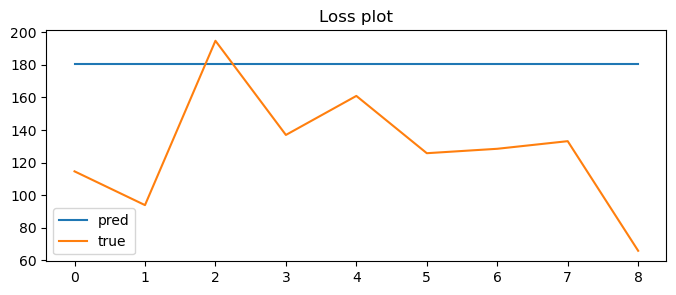

## PREPARED FOODS_12
Epoch: 0000 train loss : 1182.0736
Epoch: 0020 train loss : 414.0735
Epoch: 0040 train loss : 413.3444
Epoch: 0060 train loss : 412.3504
Epoch: 0080 train loss : 412.9403


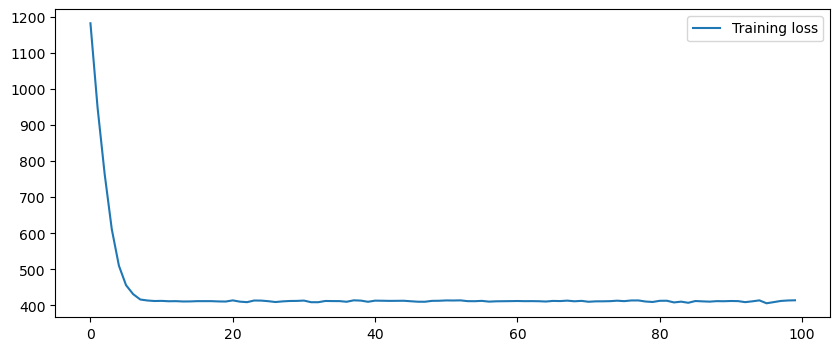

     prediction :  [29.49782943725586, 29.497947692871094, 29.497962951660156, 29.497961044311523, 29.497901916503906, 29.49795150756836, 29.4979305267334, 29.497949600219727, 29.497962951660156]
     true       :  tensor([46., 94., 63., 40., 56., 44., 50., 57., 68.])
     RMSLE SCORE :  0.4446198635822436


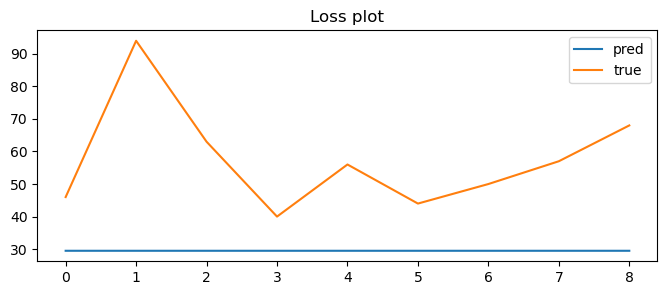

## PRODUCE_12
Epoch: 0000 train loss : 55407.4766
Epoch: 0020 train loss : 36892.0430
Epoch: 0040 train loss : 31130.0020
Epoch: 0060 train loss : 29623.8887
Epoch: 0080 train loss : 29401.8340


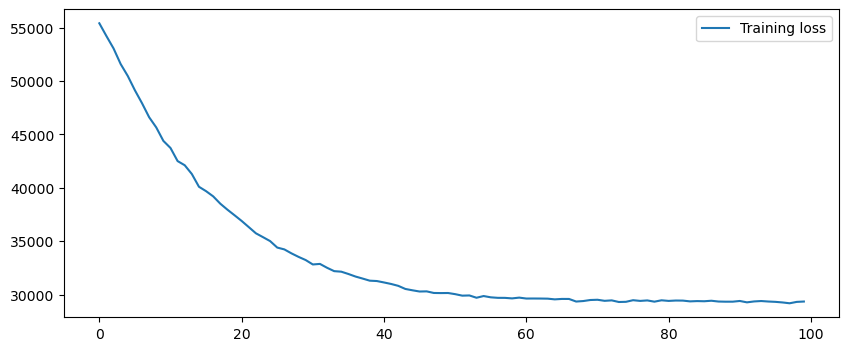

     prediction :  [149.736572265625, 149.736572265625, 149.736572265625, 149.736572265625, 149.736572265625, 149.736572265625, 149.736572265625, 149.736572265625, 149.736572265625]
     true       :  tensor([364.1810, 268.5490, 357.7160, 291.5070, 347.3990, 313.4750, 328.0280,
        319.8970, 302.4450])
     RMSLE SCORE :  0.5804978501352835


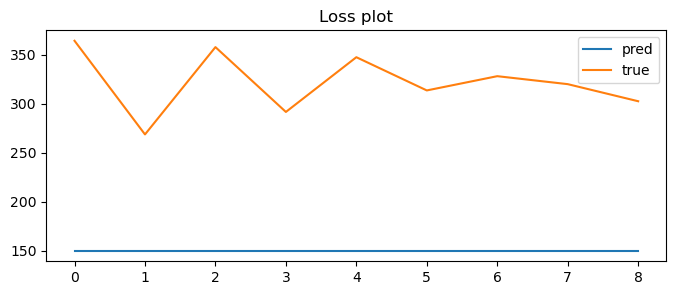

## SCHOOL AND OFFICE SUPPLIES_12
Epoch: 0000 train loss : 9.2739
Epoch: 0020 train loss : 9.1588
Epoch: 0040 train loss : 9.1512
Epoch: 0060 train loss : 8.8333
Epoch: 0080 train loss : 9.1565


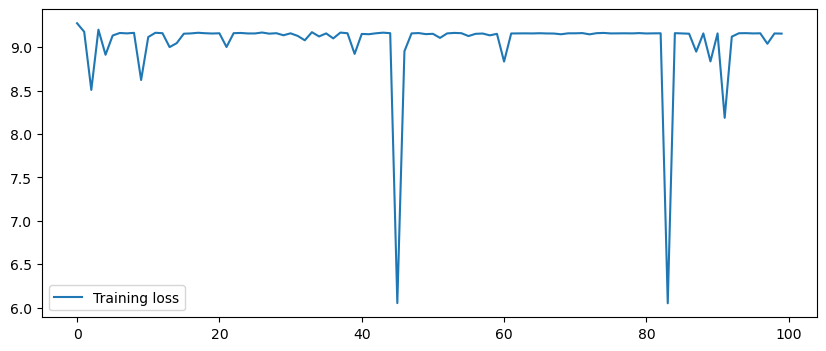

     prediction :  [0.4592478275299072, 0.49950188398361206, 0.47289663553237915, 0.4846247434616089, 0.44815540313720703, 0.4751245677471161, 0.4960091710090637, 0.49196478724479675, 0.47039908170700073]
     true       :  tensor([1., 2., 1., 6., 9., 2., 0., 2., 2.])
     RMSLE SCORE :  0.9416689055556904


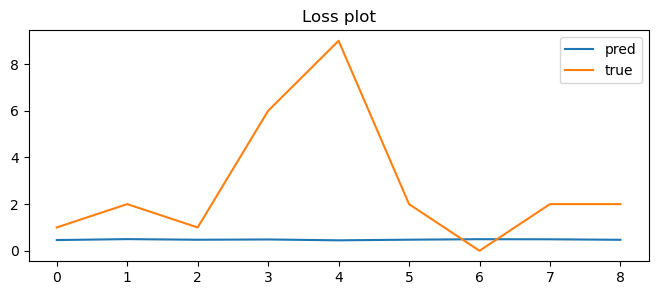

## SEAFOOD_12
Epoch: 0000 train loss : 7.1255
Epoch: 0020 train loss : 5.9224
Epoch: 0040 train loss : 5.8886
Epoch: 0060 train loss : 5.9241
Epoch: 0080 train loss : 5.9103


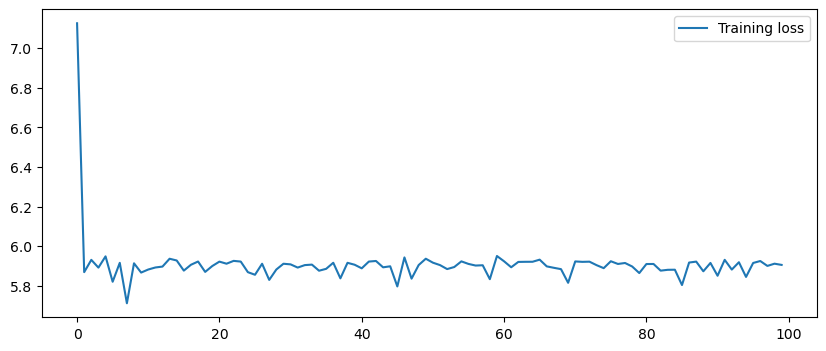

     prediction :  [2.0341293811798096, 2.0342514514923096, 2.0406453609466553, 2.039510488510132, 2.0377748012542725, 2.030259847640991, 2.040611743927002, 2.0416183471679688, 2.0387425422668457]
     true       :  tensor([3., 6., 2., 4., 4., 3., 7., 1., 6.])
     RMSLE SCORE :  0.3507159138698921


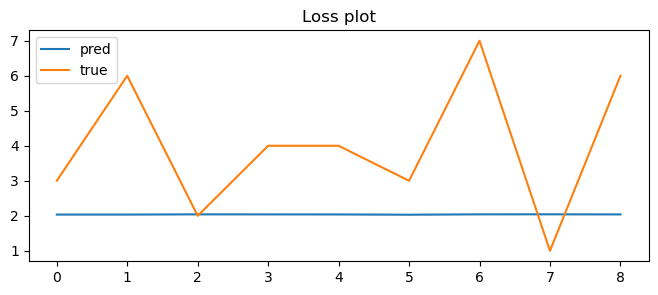

## AUTOMOTIVE_13
Epoch: 0000 train loss : 26.7230
Epoch: 0020 train loss : 12.2018
Epoch: 0040 train loss : 11.8299
Epoch: 0060 train loss : 12.2197
Epoch: 0080 train loss : 12.0711


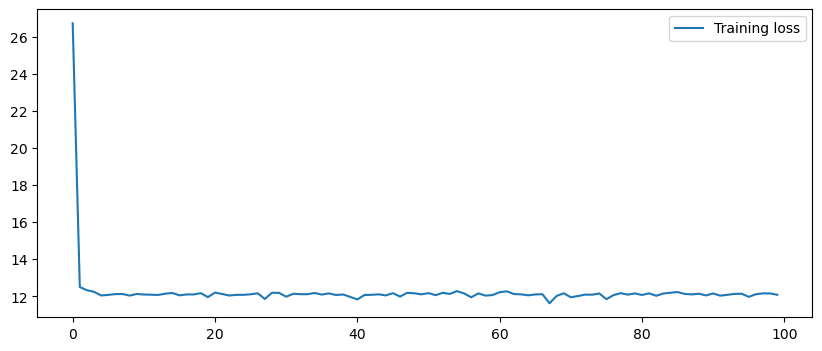

     prediction :  [5.274149417877197, 5.267500400543213, 5.279129981994629, 5.267584323883057, 5.29941463470459, 5.290152549743652, 5.292333602905273, 5.287139892578125, 5.295953273773193]
     true       :  tensor([ 1.,  3.,  1., 12.,  6.,  7.,  5.,  9.,  4.])
     RMSLE SCORE :  0.4099623892516267


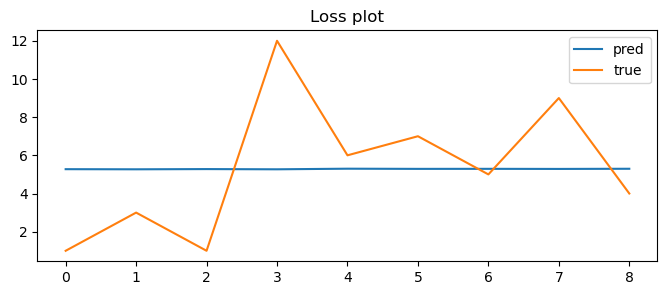

## BABY CARE_13
Epoch: 0000 train loss : 0.0014
Epoch: 0020 train loss : 0.0000
Epoch: 0040 train loss : 0.0000
Epoch: 0060 train loss : 0.0000
Epoch: 0080 train loss : 0.0000


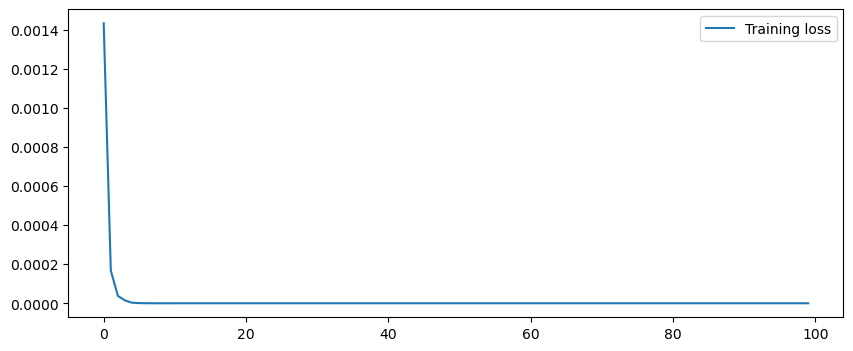

     prediction :  [0, 0, 0, 0, 0, 0, 0, 0, 0]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.0


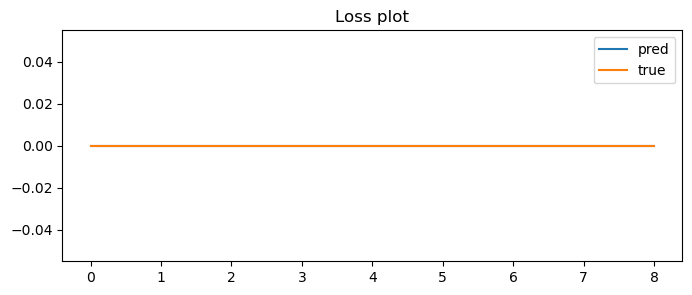

## BEAUTY_13
Epoch: 0000 train loss : 1.7299
Epoch: 0020 train loss : 1.3637
Epoch: 0040 train loss : 1.3591
Epoch: 0060 train loss : 1.3601
Epoch: 0080 train loss : 1.3591


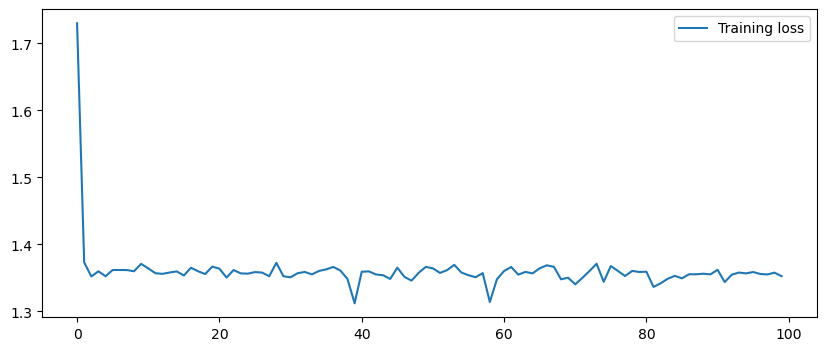

     prediction :  [1.0845692157745361, 1.081390142440796, 1.0858759880065918, 1.0850685834884644, 1.084643006324768, 1.0844979286193848, 1.0856385231018066, 1.1018011569976807, 1.0818086862564087]
     true       :  tensor([1., 2., 1., 1., 1., 0., 5., 1., 1.])
     RMSLE SCORE :  0.2000852750110884


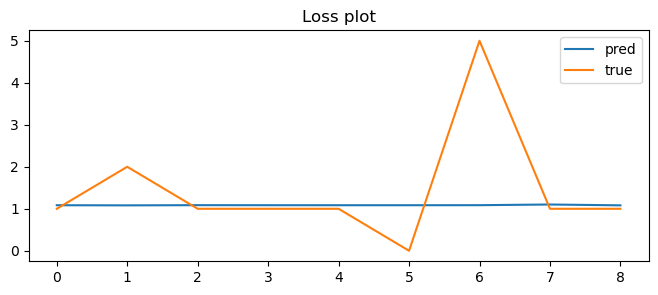

## BEVERAGES_13
Epoch: 0000 train loss : 1769361.0000
Epoch: 0020 train loss : 1659758.0000
Epoch: 0040 train loss : 1505737.5000
Epoch: 0060 train loss : 1346982.5000
Epoch: 0080 train loss : 1193044.5000


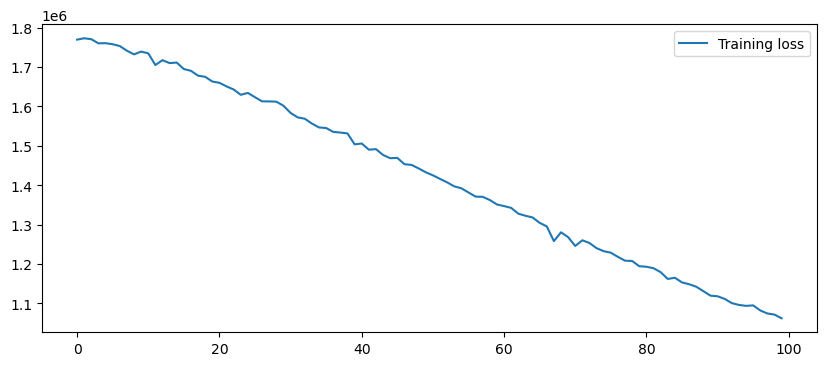

     prediction :  [347.4631042480469, 347.4631042480469, 347.4631042480469, 347.4631042480469, 347.4631042480469, 347.4631042480469, 347.4631042480469, 347.4631042480469, 347.4631042480469]
     true       :  tensor([1358., 1129., 1022., 1331., 1846., 1069., 1457., 1062., 1205.])
     RMSLE SCORE :  1.6742422989903618


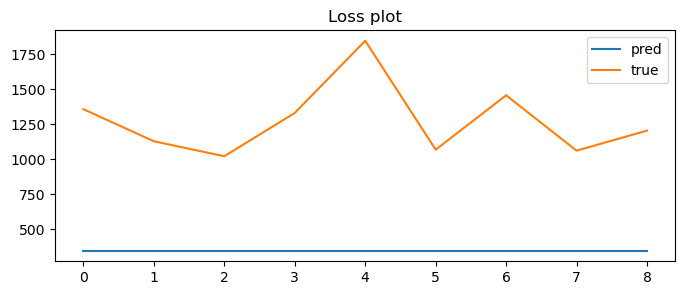

## BOOKS_13
Epoch: 0000 train loss : 0.0030
Epoch: 0020 train loss : 0.0000
Epoch: 0040 train loss : 0.0000
Epoch: 0060 train loss : 0.0000
Epoch: 0080 train loss : 0.0000


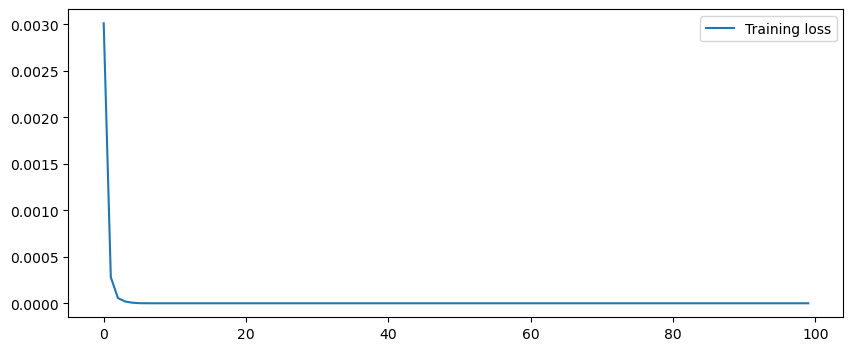

     prediction :  [0, 0, 0, 0, 0, 0, 0, 0, 0]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.0


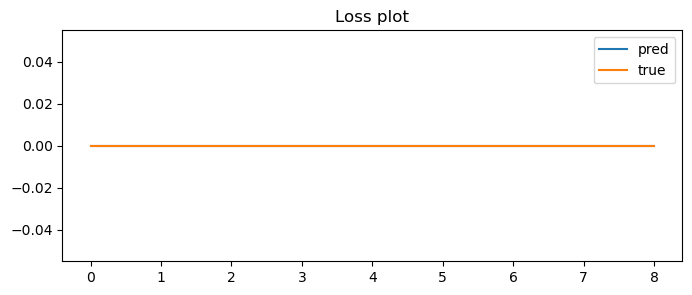

## BREAD/BAKERY_13
Epoch: 0000 train loss : 37587.2344
Epoch: 0020 train loss : 20314.6094
Epoch: 0040 train loss : 13836.2090
Epoch: 0060 train loss : 12538.4844
Epoch: 0080 train loss : 12400.6279


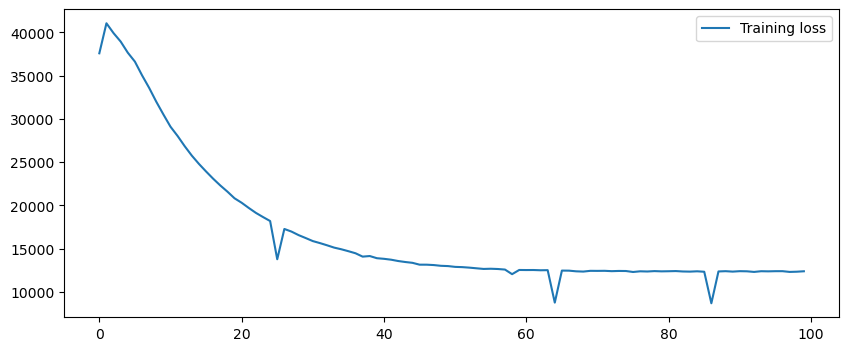

     prediction :  [172.12208557128906, 172.12208557128906, 172.12208557128906, 172.12208557128906, 172.12208557128906, 172.12208557128906, 172.12208557128906, 172.12208557128906, 172.12208557128906]
     true       :  tensor([105.,  93.,  91.,  93., 152.,  95.,  91.,  77.,  84.])
     RMSLE SCORE :  0.3656188627994847


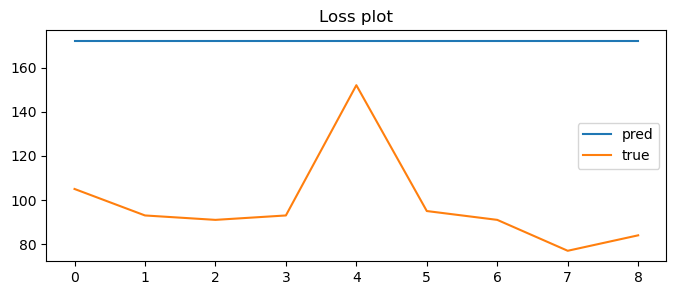

## CELEBRATION_13
Epoch: 0000 train loss : 48.2638
Epoch: 0020 train loss : 44.6432
Epoch: 0040 train loss : 44.5646
Epoch: 0060 train loss : 44.5464
Epoch: 0080 train loss : 38.3300


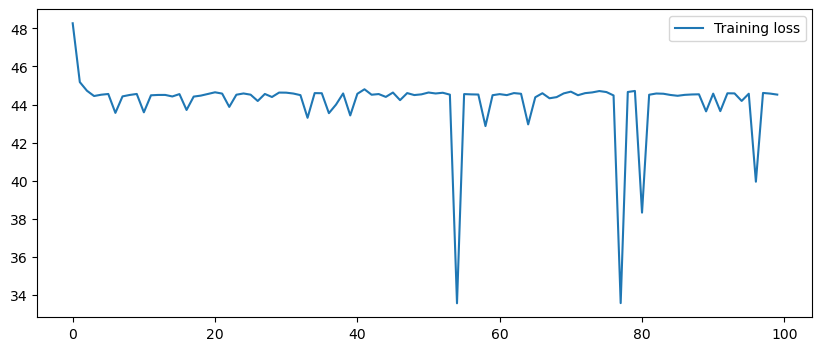

     prediction :  [3.3402557373046875, 3.350555658340454, 3.3132009506225586, 3.312103509902954, 3.3398685455322266, 3.3777146339416504, 3.3335061073303223, 3.3332033157348633, 3.362455129623413]
     true       :  tensor([ 6.,  1.,  1.,  4., 22.,  3.,  3., 10., 11.])
     RMSLE SCORE :  0.6813708726241888


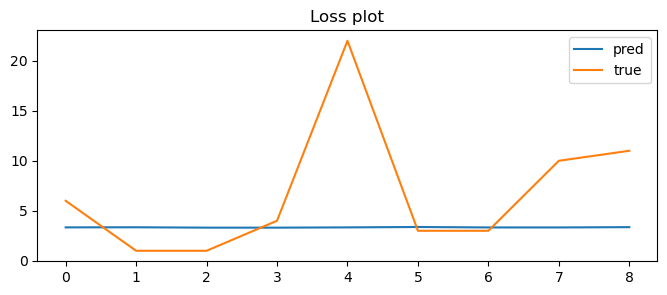

## CLEANING_13
Epoch: 0000 train loss : 765935.6875
Epoch: 0020 train loss : 715706.1875
Epoch: 0040 train loss : 606565.3125
Epoch: 0060 train loss : 514478.2500
Epoch: 0080 train loss : 448827.4688


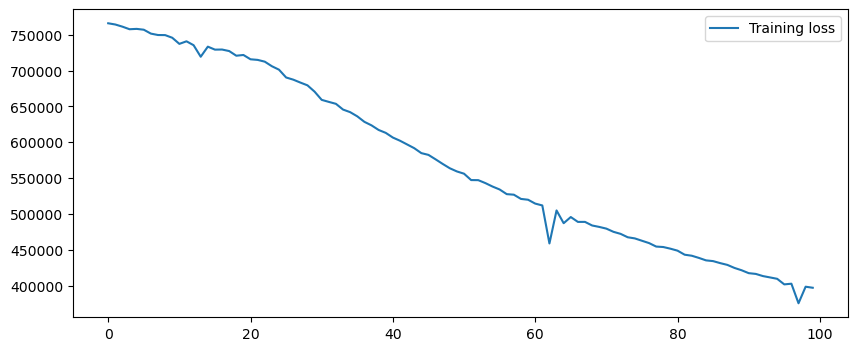

     prediction :  [293.00146484375, 293.00146484375, 293.00146484375, 293.00146484375, 293.00146484375, 293.00146484375, 293.00146484375, 293.00146484375, 293.00146484375]
     true       :  tensor([776., 564., 429., 512., 860., 500., 616., 619., 931.])
     RMSLE SCORE :  0.6335245433207766


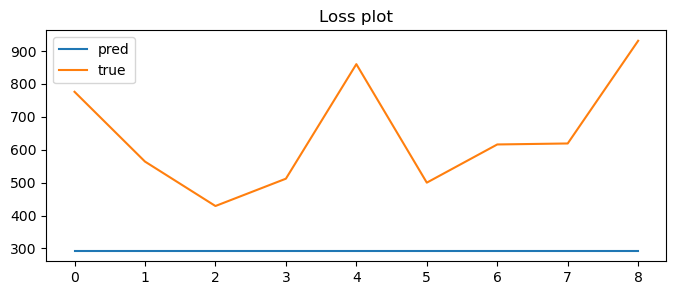

## DAIRY_13
Epoch: 0000 train loss : 79251.3906
Epoch: 0020 train loss : 43510.6211
Epoch: 0040 train loss : 25351.9492
Epoch: 0060 train loss : 17753.6602
Epoch: 0080 train loss : 15007.2070


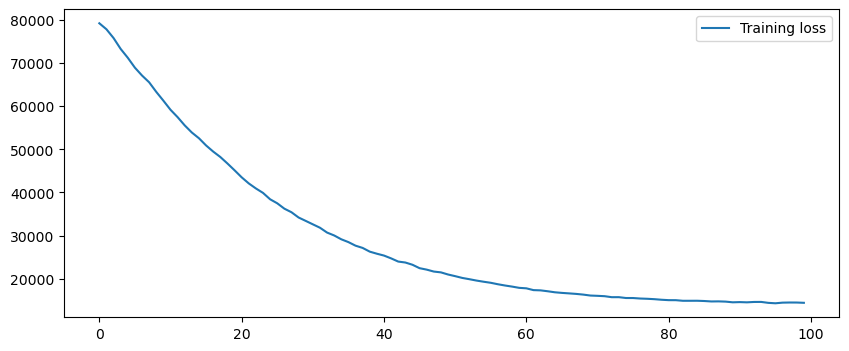

     prediction :  [244.3061981201172, 244.3061981201172, 244.3061981201172, 244.3061981201172, 244.3061981201172, 244.3061981201172, 244.3061981201172, 244.3061981201172, 244.3061981201172]
     true       :  tensor([299., 232., 182., 287., 306., 182., 296., 222., 328.])
     RMSLE SCORE :  0.046976146489154345


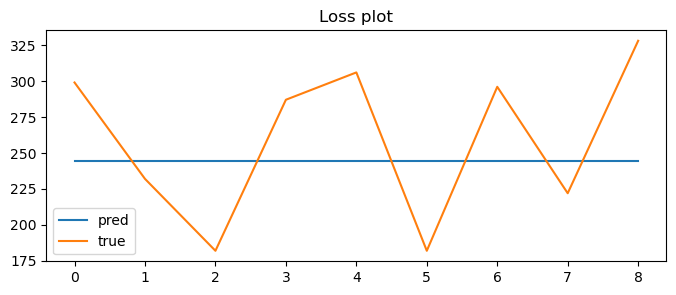

## DELI_13
Epoch: 0000 train loss : 26678.7344
Epoch: 0020 train loss : 8560.6797
Epoch: 0040 train loss : 4121.4971
Epoch: 0060 train loss : 3599.4036
Epoch: 0080 train loss : 3570.0107


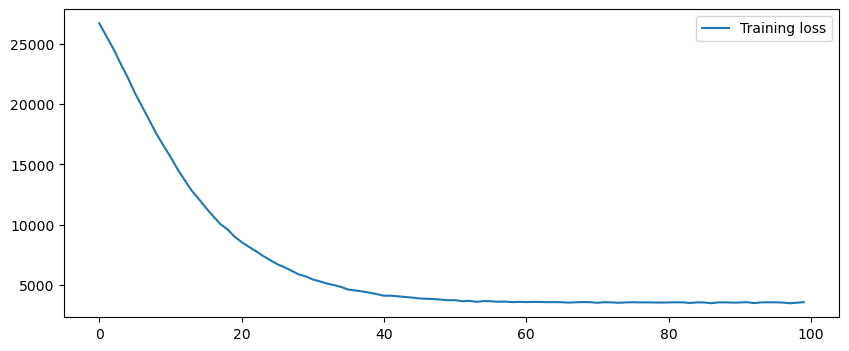

     prediction :  [152.87123107910156, 152.87123107910156, 152.87123107910156, 152.87123107910156, 152.87123107910156, 152.87123107910156, 152.87123107910156, 152.87123107910156, 152.87123107910156]
     true       :  tensor([169., 166., 105., 158., 163.,  91., 178., 145., 171.])
     RMSLE SCORE :  0.051471713553500796


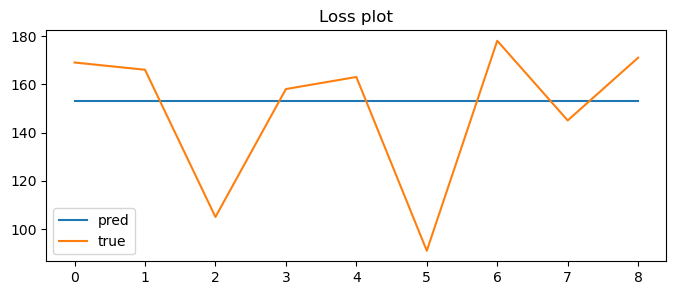

## EGGS_13
Epoch: 0000 train loss : 4212.7637
Epoch: 0020 train loss : 1834.0608
Epoch: 0040 train loss : 1833.0944
Epoch: 0060 train loss : 1831.4215
Epoch: 0080 train loss : 1814.0487


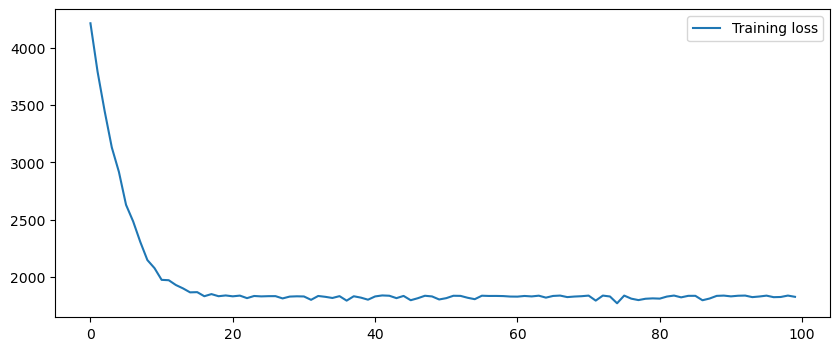

     prediction :  [51.39726638793945, 51.39397048950195, 51.39680862426758, 51.39619827270508, 51.396541595458984, 51.39726257324219, 51.397254943847656, 51.39720916748047, 51.39714431762695]
     true       :  tensor([10., 23., 17., 20., 77., 58., 48., 33., 19.])
     RMSLE SCORE :  0.7016972045388093


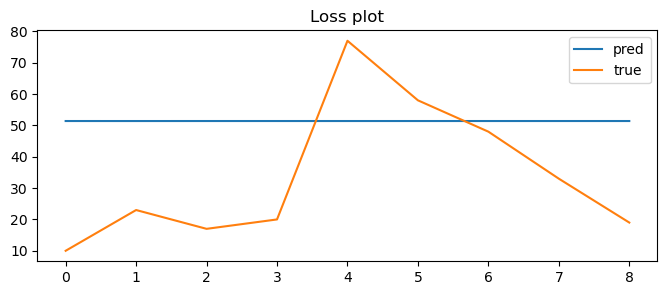

## FROZEN FOODS_13
Epoch: 0000 train loss : 6341.8369
Epoch: 0020 train loss : 5510.3105
Epoch: 0040 train loss : 5511.0000
Epoch: 0060 train loss : 5509.5752
Epoch: 0080 train loss : 5501.3018


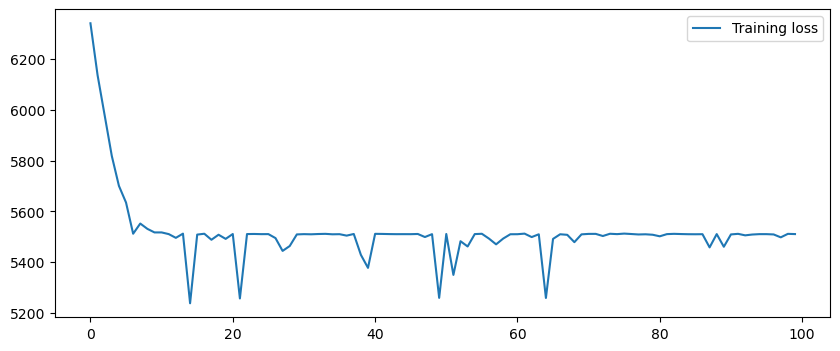

     prediction :  [31.48129653930664, 31.480085372924805, 31.480613708496094, 31.480852127075195, 31.481388092041016, 31.4814453125, 31.480297088623047, 31.480928421020508, 31.481447219848633]
     true       :  tensor([15., 18., 20., 32., 29., 16., 21., 40., 11.])
     RMSLE SCORE :  0.28915682421678074


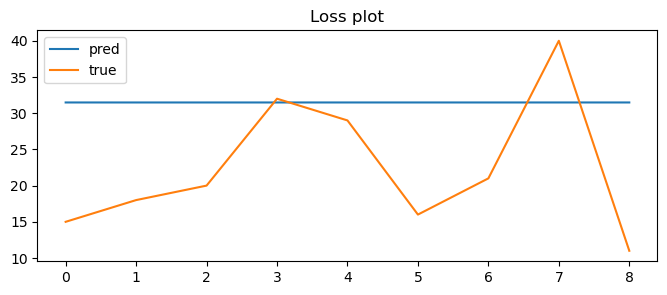

## GROCERY I_13
Epoch: 0000 train loss : 8036394.0000
Epoch: 0020 train loss : 7932851.5000
Epoch: 0040 train loss : 7766571.5000
Epoch: 0060 train loss : 7679711.5000
Epoch: 0080 train loss : 7532682.0000


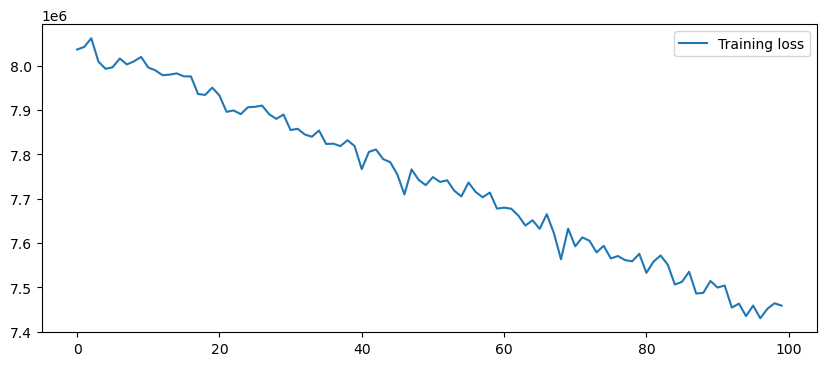

     prediction :  [120.15719604492188, 120.15719604492188, 120.15719604492188, 120.15719604492188, 120.15719604492188, 120.15719604492188, 120.15719604492188, 120.15719604492188, 120.15719604492188]
     true       :  tensor([2907., 2885., 1727., 2302., 3166., 1606., 2349., 2117., 2389.])
     RMSLE SCORE :  8.787842010467335


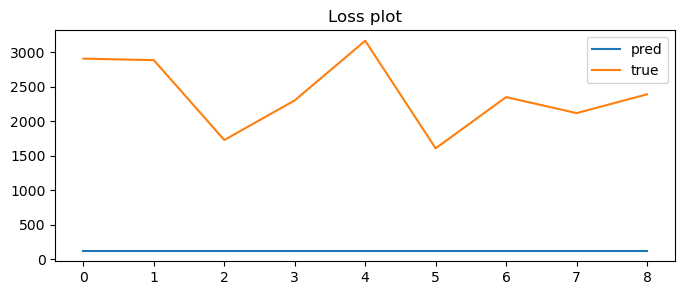

## GROCERY II_13
Epoch: 0000 train loss : 96.5792
Epoch: 0020 train loss : 58.6884
Epoch: 0040 train loss : 58.1446
Epoch: 0060 train loss : 58.8861
Epoch: 0080 train loss : 58.7363


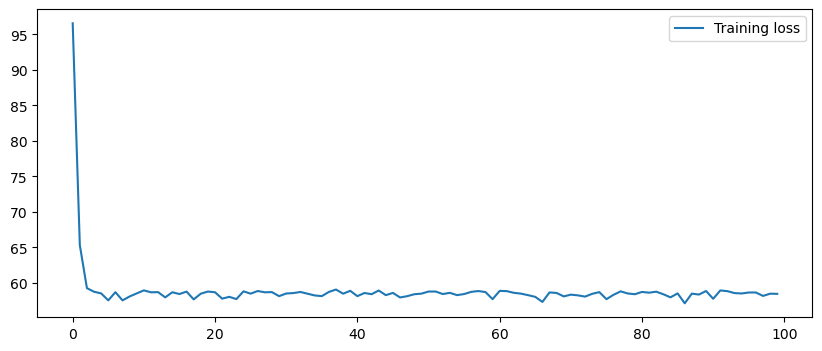

     prediction :  [7.256779670715332, 7.236626625061035, 7.252819061279297, 7.257736682891846, 7.248593330383301, 7.237089157104492, 7.250003337860107, 7.251248359680176, 7.242064476013184]
     true       :  tensor([0., 5., 9., 3., 0., 2., 4., 1., 6.])
     RMSLE SCORE :  1.4308392365890445


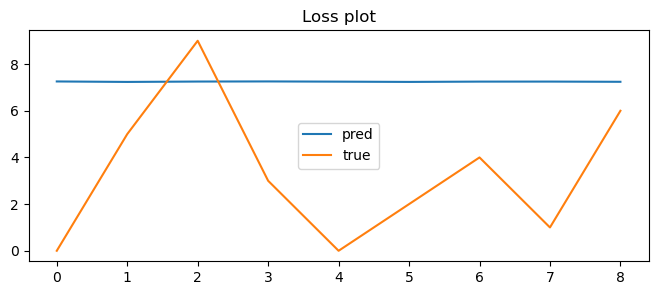

## HARDWARE_13
Epoch: 0000 train loss : 1.3233
Epoch: 0020 train loss : 1.2823
Epoch: 0040 train loss : 1.2787
Epoch: 0060 train loss : 1.2872
Epoch: 0080 train loss : 1.2855


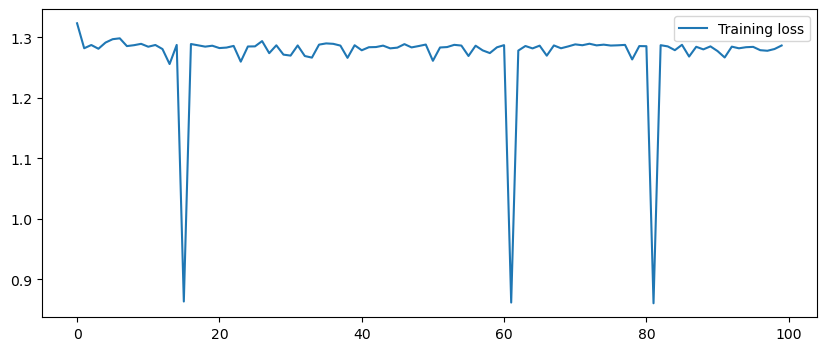

     prediction :  [0.5583820343017578, 0.5629746317863464, 0.5586963891983032, 0.5593984127044678, 0.5608265399932861, 0.5613516569137573, 0.5617207884788513, 0.5618587136268616, 0.5619866847991943]
     true       :  tensor([0., 0., 1., 1., 1., 1., 1., 0., 3.])
     RMSLE SCORE :  0.1985931608924316


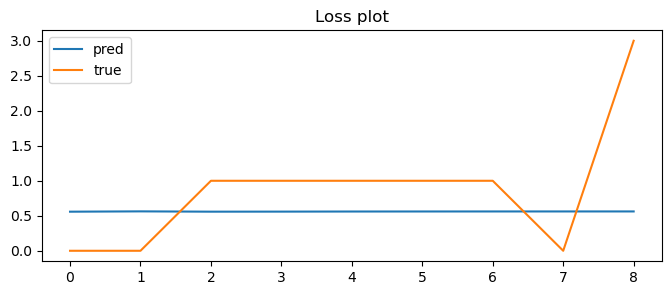

## HOME AND KITCHEN I_13
Epoch: 0000 train loss : 349.7571
Epoch: 0020 train loss : 288.3756
Epoch: 0040 train loss : 268.9728
Epoch: 0060 train loss : 288.9209
Epoch: 0080 train loss : 286.7484


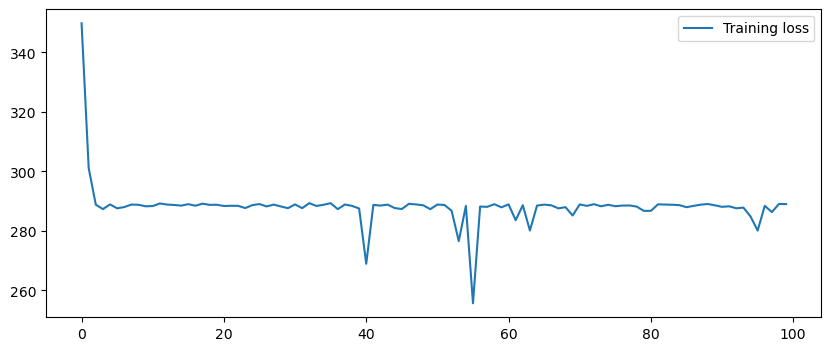

     prediction :  [9.752739906311035, 9.746929168701172, 9.761066436767578, 9.732481956481934, 9.728636741638184, 9.75001335144043, 9.739619255065918, 9.755711555480957, 9.735173225402832]
     true       :  tensor([ 9., 27.,  2.,  1., 10.,  5., 14.,  3.,  6.])
     RMSLE SCORE :  0.7766877228123339


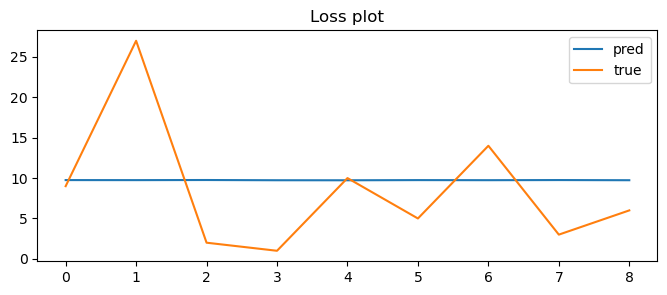

## HOME AND KITCHEN II_13
Epoch: 0000 train loss : 148.8257
Epoch: 0020 train loss : 125.5986
Epoch: 0040 train loss : 126.3754
Epoch: 0060 train loss : 126.4701
Epoch: 0080 train loss : 125.4872


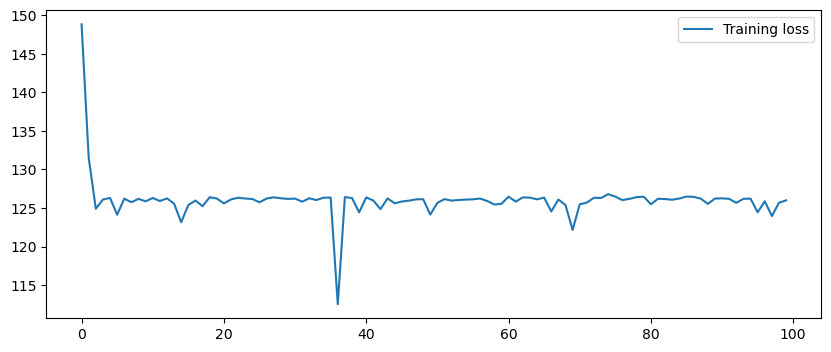

     prediction :  [7.287426948547363, 7.297552585601807, 7.29115629196167, 7.294580459594727, 7.281857013702393, 7.298557758331299, 7.277977466583252, 7.258216857910156, 7.287220478057861]
     true       :  tensor([16.,  8., 11.,  4., 17.,  3.,  0.,  5., 34.])
     RMSLE SCORE :  0.9661902410193842


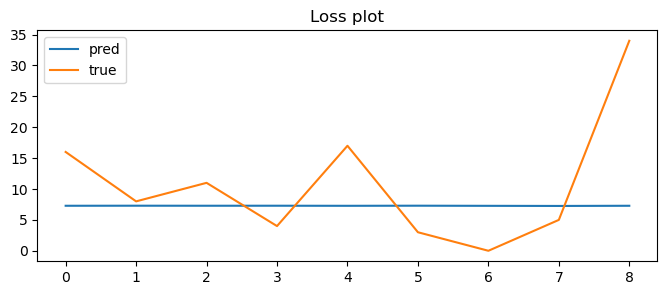

## HOME APPLIANCES_13
Epoch: 0000 train loss : 0.2229
Epoch: 0020 train loss : 0.2073
Epoch: 0040 train loss : 0.2134
Epoch: 0060 train loss : 0.2126
Epoch: 0080 train loss : 0.2128


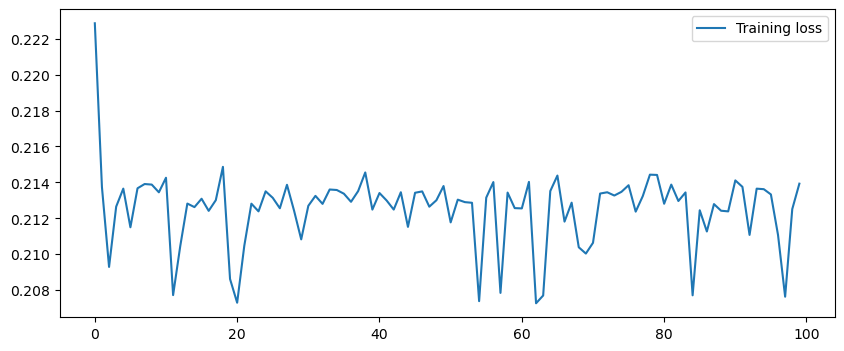

     prediction :  [0.19920948147773743, 0.19920948147773743, 0.19920948147773743, 0.19920948147773743, 0.19920948147773743, 0.19920948147773743, 0.19920948147773743, 0.19920948147773743, 0.19920948147773743]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.033001290893107924


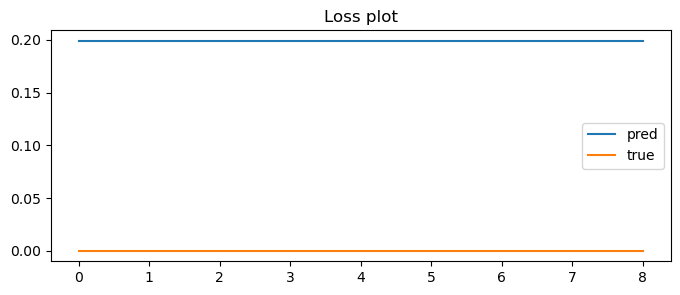

## HOME CARE_13
Epoch: 0000 train loss : 18255.6191
Epoch: 0020 train loss : 10335.2354
Epoch: 0040 train loss : 9755.5156
Epoch: 0060 train loss : 9747.4912
Epoch: 0080 train loss : 9751.4355


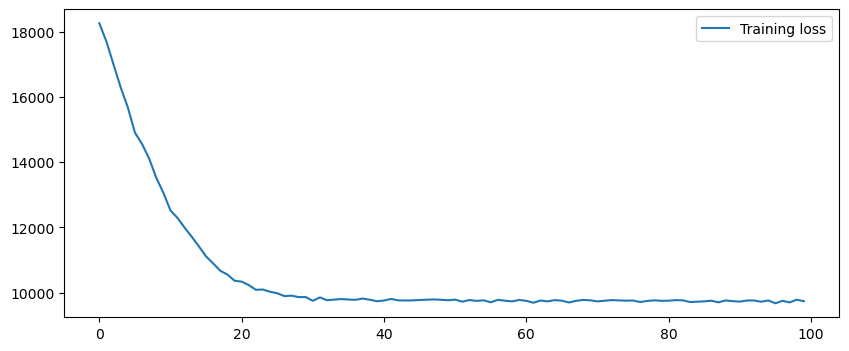

     prediction :  [91.37092590332031, 91.37092590332031, 91.37092590332031, 91.37092590332031, 91.37092590332031, 91.37092590332031, 91.37092590332031, 91.37092590332031, 91.37092590332031]
     true       :  tensor([189., 104., 114., 107., 200., 130., 129., 137., 154.])
     RMSLE SCORE :  0.20904825935054006


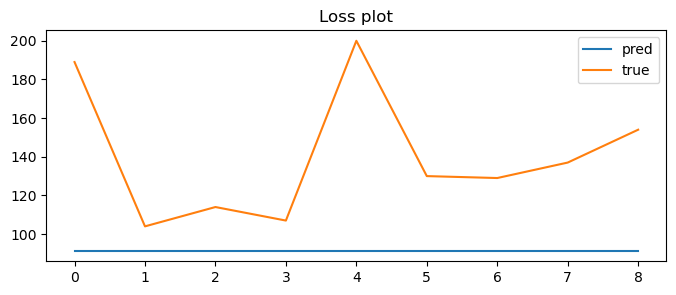

## LADIESWEAR_13
Epoch: 0000 train loss : 19.3599
Epoch: 0020 train loss : 17.4255
Epoch: 0040 train loss : 17.2267
Epoch: 0060 train loss : 17.3924
Epoch: 0080 train loss : 17.4652


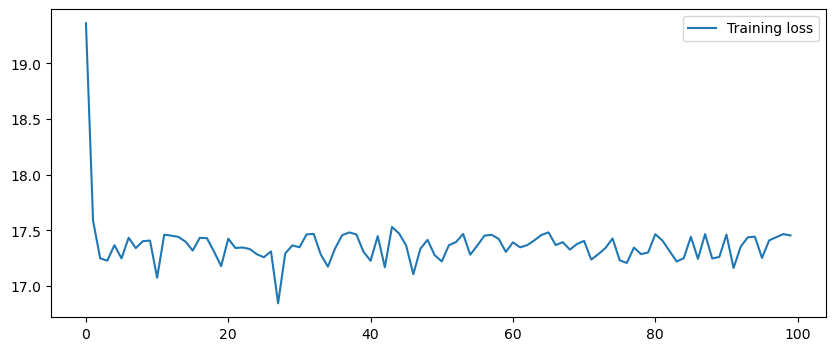

     prediction :  [2.610776424407959, 2.6458070278167725, 2.635009288787842, 2.620802640914917, 2.619645833969116, 2.6480746269226074, 2.6427531242370605, 2.6291615962982178, 2.628014326095581]
     true       :  tensor([8., 4., 2., 2., 9., 6., 3., 3., 3.])
     RMSLE SCORE :  0.27680889499918204


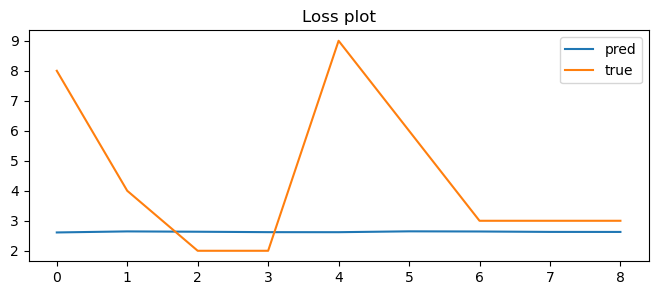

## LAWN AND GARDEN_13
Epoch: 0000 train loss : 0.0738
Epoch: 0020 train loss : 0.0683
Epoch: 0040 train loss : 0.0684
Epoch: 0060 train loss : 0.0684
Epoch: 0080 train loss : 0.0682


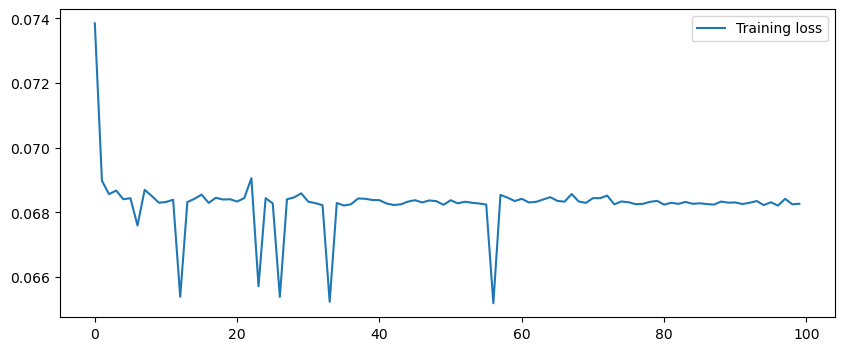

     prediction :  [0.011321401223540306, 0.011321401223540306, 0.011321401223540306, 0.011321401223540306, 0.011321401223540306, 0.011321401223540306, 0.011321401223540306, 0.011321401223540306, 0.011321401223540306]
     true       :  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
     RMSLE SCORE :  0.00012673792110767527


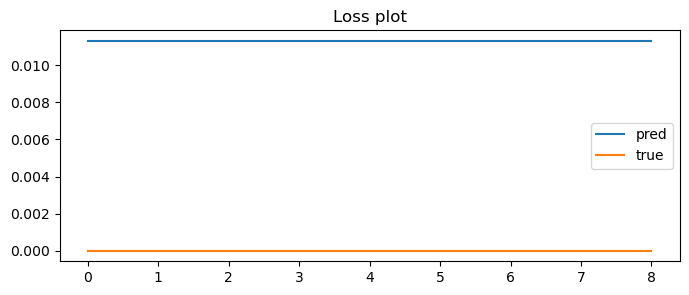

## LINGERIE_13
Epoch: 0000 train loss : 13.3506
Epoch: 0020 train loss : 9.7260
Epoch: 0040 train loss : 9.7427
Epoch: 0060 train loss : 9.7077
Epoch: 0080 train loss : 9.7351


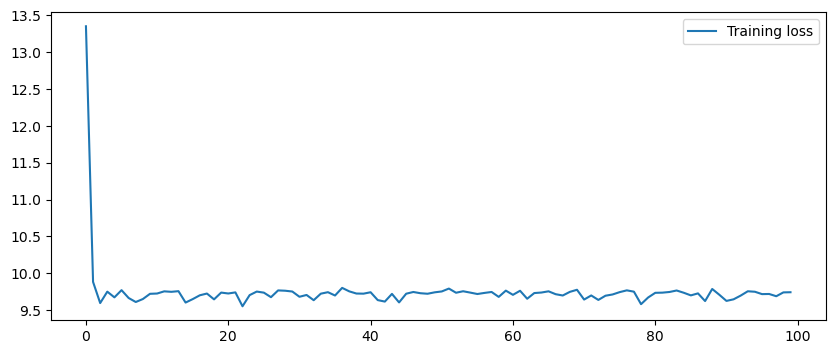

     prediction :  [3.0721306800842285, 3.0789101123809814, 3.0723490715026855, 3.0891404151916504, 3.1089532375335693, 3.0990540981292725, 3.0739145278930664, 3.0791549682617188, 3.084909200668335]
     true       :  tensor([ 1.,  0.,  3., 15.,  6.,  0.,  1.,  2.,  6.])
     RMSLE SCORE :  0.834239452179057


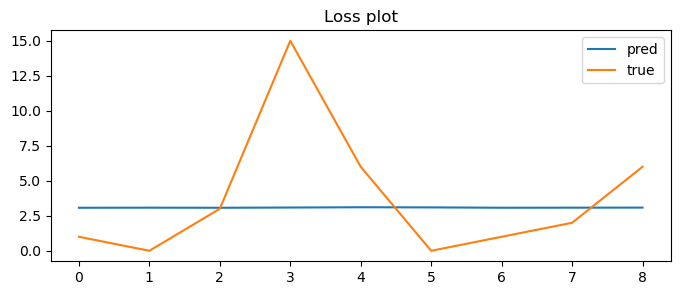

## LIQUOR,WINE,BEER_13
Epoch: 0000 train loss : 2044.8162
Epoch: 0020 train loss : 1136.7190
Epoch: 0040 train loss : 1163.0714
Epoch: 0060 train loss : 1170.7014
Epoch: 0080 train loss : 1166.8091


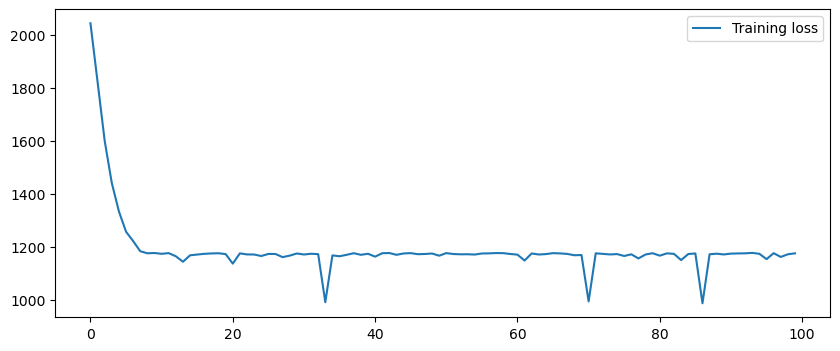

     prediction :  [31.010120391845703, 31.01068115234375, 31.01087188720703, 31.01093292236328, 31.011009216308594, 31.010997772216797, 31.00957489013672, 31.010103225708008, 31.010828018188477]
     true       :  tensor([21., 28., 31., 48., 88., 11., 14., 24., 15.])
     RMSLE SCORE :  0.3840585072007002


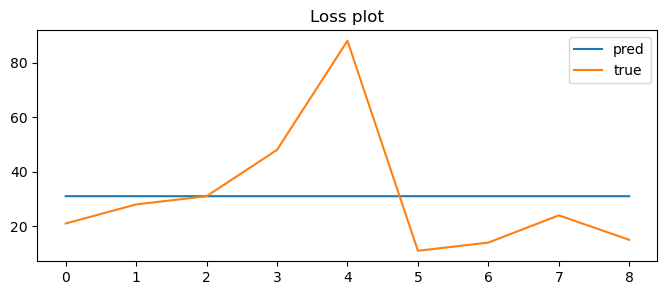

## MAGAZINES_13
Epoch: 0000 train loss : 0.7150
Epoch: 0020 train loss : 0.7006
Epoch: 0040 train loss : 0.7031
Epoch: 0060 train loss : 0.7031
Epoch: 0080 train loss : 0.6974


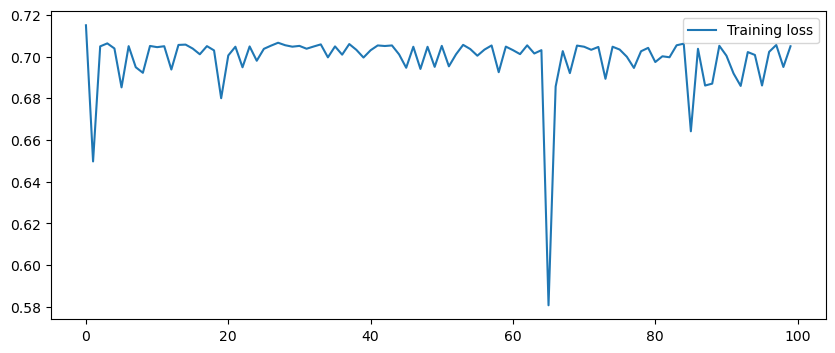

     prediction :  [0.2997516691684723, 0.28829723596572876, 0.2966552972793579, 0.2929948568344116, 0.2859627306461334, 0.30399248003959656, 0.28989970684051514, 0.28502073884010315, 0.2897726595401764]
     true       :  tensor([0., 2., 1., 0., 4., 0., 0., 1., 0.])
     RMSLE SCORE :  0.36408423281483604


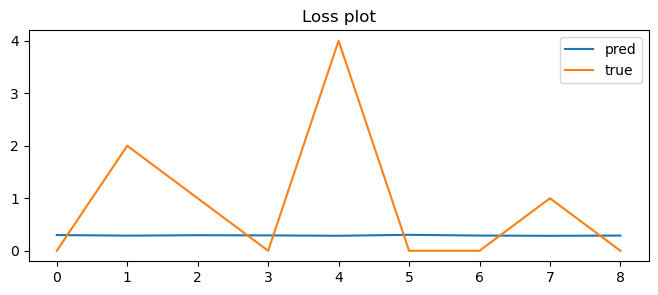

## MEATS_13
Epoch: 0000 train loss : 25165.7539
Epoch: 0020 train loss : 7085.9443
Epoch: 0040 train loss : 2822.2415
Epoch: 0060 train loss : 2325.8208
Epoch: 0080 train loss : 2293.2366


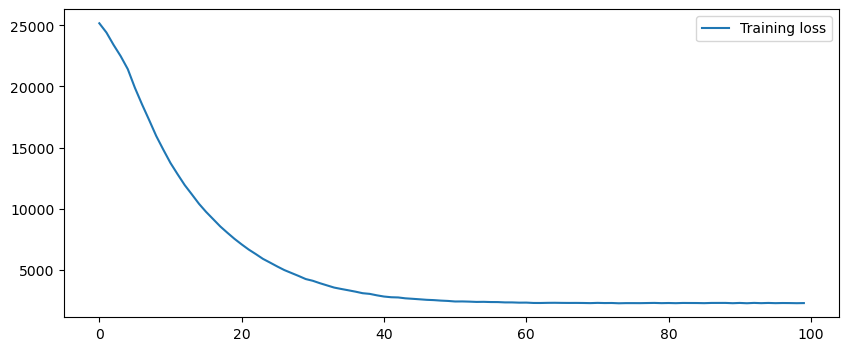

     prediction :  [152.084228515625, 152.084228515625, 152.084228515625, 152.084228515625, 152.084228515625, 152.084228515625, 152.084228515625, 152.084228515625, 152.084228515625]
     true       :  tensor([180.3000, 132.2360, 205.8630, 164.8100, 169.8140,  83.0100, 187.3980,
        139.8080, 108.5750])
     RMSLE SCORE :  0.07543041579494823


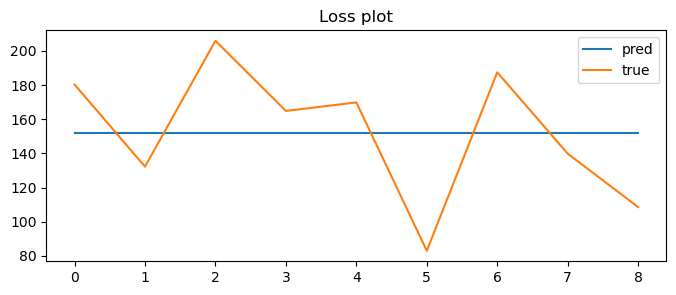

## PERSONAL CARE_13
Epoch: 0000 train loss : 35046.2227
Epoch: 0020 train loss : 12916.1172
Epoch: 0040 train loss : 6682.5723
Epoch: 0060 train loss : 5489.5908
Epoch: 0080 train loss : 5373.2925


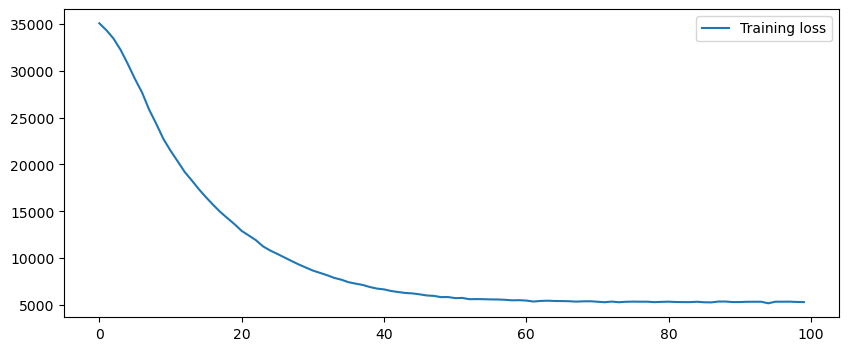

     prediction :  [173.16656494140625, 173.16656494140625, 173.16656494140625, 173.16656494140625, 173.16656494140625, 173.16656494140625, 173.16656494140625, 173.16656494140625, 173.16656494140625]
     true       :  tensor([263., 119., 125., 129., 304., 115., 171., 163., 177.])
     RMSLE SCORE :  0.1094980060294626


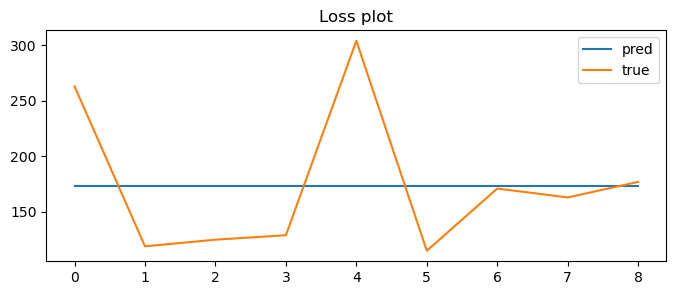

## PET SUPPLIES_13
Epoch: 0000 train loss : 0.1908
Epoch: 0020 train loss : 0.1702
Epoch: 0040 train loss : 0.1790
Epoch: 0060 train loss : 0.1843
Epoch: 0080 train loss : 0.1843


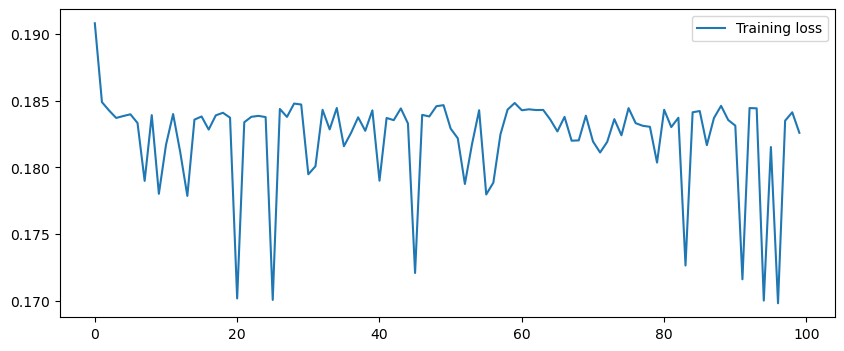

     prediction :  [0.11697007715702057, 0.11640284210443497, 0.11613372713327408, 0.11601652204990387, 0.11586430668830872, 0.1176282986998558, 0.11642958968877792, 0.11885374784469604, 0.11749852448701859]
     true       :  tensor([0., 0., 0., 1., 0., 2., 0., 0., 0.])
     RMSLE SCORE :  0.15564831936766133


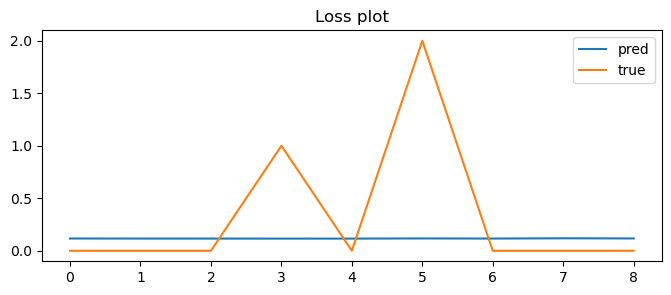

## PLAYERS AND ELECTRONICS_13
Epoch: 0000 train loss : 9.8644
Epoch: 0020 train loss : 8.6523


KeyboardInterrupt: 

In [34]:
for fs in tqdm(train_set["family_store"].unique()):  
    print(f"## {fs}")  
    ## Generate Single DataSet
    single_tr = train_set[train_set.family_store == fs].drop(columns="family_store")
    single_val = valid_set[valid_set.family_store == fs].drop(columns="family_store")
    
    trainX, trainY = build_dataset(np.array(single_tr), seq_length)
    validX, validY = build_dataset(np.array(single_val), seq_length)
    
    trainX_tensor = torch.FloatTensor(trainX)
    trainY_tensor = torch.FloatTensor(trainY)

    validX_tensor = torch.FloatTensor(validX)
    validY_tensor = torch.FloatTensor(validY)

    dataset = TensorDataset(trainX_tensor, trainY_tensor)
    dataloader = DataLoader(dataset,
                            batch_size=batch,
                            shuffle=True,  
                            drop_last=True)    
    
    ## Training Model
    net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
    model, train_hist = train_model(
        net, 
        dataloader, 
        num_epochs = epochs, 
        lr = learning_rate, 
        verbose = 20, 
        patience = 10
        )

    ## Loss plot for each epoch
    fig = plt.figure(figsize=(10, 4))
    plt.plot(train_hist, label="Training loss")
    plt.legend()
    plt.show()
    
    ## prediction
    with torch.no_grad(): 
        pred = []
        
    for pr in range(len(validX_tensor)):
        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(validX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)
    
    pred = after_process(pred)
        
    print("     prediction : ", pred)
    print("     true       : ", validY_tensor)
    print('     RMSLE SCORE : ', mean_squared_log_error(pred, validY_tensor))
    
    fig = plt.figure(figsize=(8,3))
    plt.plot(np.arange(len(pred)), pred, label = 'pred')
    plt.plot(np.arange(len(validY_tensor)), validY_tensor, label = 'true')
    plt.legend()
    plt.title("Loss plot")
    plt.show()